In [1]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

In [2]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

# Initial RSnostim equilibrium check

# Search and Replace in files

In [3]:
dataloc="/home/kabir/Project/tripartiteSynapse/mcell/stores_blocked/"
files=os.listdir(dataloc)
RSI_files=[]
for f in files:
    if "RSI" in f:
        RSI_files.append(f)
#RSI_files

In [4]:
for fn in RSI_files:
    with fi.FileInput(dataloc+fn,inplace=True, backup='.bak') as f:
        for line in f:
            print(line.replace('"ppf/"','"ppf/stores_blocked/"'), end='')

# kleak conversion to mcell

In [69]:
#from S Bandara et al 2013
J=0.07*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted kleak = ",kleak)

Ca Flux in ions/sec =  411.01111642500007
Predicted kleak =  186.74888573427603


# creating run.sh file

In [151]:
a="""for name in fnames:
    input_loc=script_folder+'/'+name.replace('V90','V80')
    output_loc=script_folder+'/'+name
    with open(input_loc,'r') as infile:
        lines=infile.readlines()
    
    lines=[line.replace("VDCC_number_presynaptic = 80","VDCC_number_presynaptic = 90") for line in lines]
        
    with open(output_loc,'w') as outfile:
        outfile.writelines(lines)
#"""            

In [5]:
#ISI range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[0]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=list(range(20,101,20))
VDCC=[90]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
#fnames=["RSI20V90.mdl","RSI30V90.mdl","RSI40V90.mdl"]
print(fnames)
#seed_num=1000

/home/kabir/Project/tripartiteSynapse/mcell/R150control
isi = [20, 40, 60, 80, 100] 
vdcc = [90]
['RSI20V90.mdl', 'RSI40V90.mdl', 'RSI60V90.mdl', 'RSI80V90.mdl', 'RSI100V90.mdl']


In [21]:
#VDCC range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[2]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=list(range(40,161,20))
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x
isi = [20] 
vdcc = [40, 60, 80, 100, 120, 140, 160]
['RSI20V40.mdl', 'RSI20V60.mdl', 'RSI20V80.mdl', 'RSI20V100.mdl', 'RSI20V120.mdl', 'RSI20V140.mdl', 'RSI20V160.mdl']


In [4]:
#3003x

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[4]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=[70]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER3x
isi = [20] 
vdcc = [70]
['RSI20V70.mdl']


In [5]:
sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"
fnames=[s+'/RS20p20hz.mdl' for s in sims]
print(fnames)

['R150control/RS20p20hz.mdl', 'R150ER2x/RS20p20hz.mdl', 'R300ER2x/RS20p20hz.mdl', 'R150ER3x/RS20p20hz.mdl', 'R300ER3x/RS20p20hz.mdl']


In [36]:
def seed_num(vdcc_num):
    #vdcc_num=int(fname.split('V')[1].replace('.mdl',''))
    if vdcc_num>=110 and vdcc_num<=160:
        return 1000
    elif vdcc_num>=90 and vdcc_num<=100:
        return (2001,10000)
    elif vdcc_num>=70 and vdcc_num<=80:
        return (3001,10000)
    elif vdcc_num>=40 and vdcc_num<=60:
        return (5000,10000)
    else:
        return 10

In [43]:
#VDCC range

sims=["ryr_old","R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]#,"stores_blocked"
#sim_type=sims[2]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"#+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=list(range(40,110,10))
#VDCC.remove(80)
#VDCC.remove(90)
print('isi = '+str(isi),'\nvdcc = '+str(VDCC))
fnames=[]
seeds=[]
for (i,v,sim) in product(isi,VDCC,sims):
    fnames.append(sim+"/RSI"+str(i)+"V"+str(v)+".mdl")
    seeds.append(seed_num(v))
print(fnames,seeds)


/home/kabir/Project/tripartiteSynapse/mcell
isi = [20] 
vdcc = [40, 50, 60, 70, 80, 90, 100]
['ryr_old/RSI20V40.mdl', 'R150control/RSI20V40.mdl', 'R150ER2x/RSI20V40.mdl', 'R300ER2x/RSI20V40.mdl', 'R150ER3x/RSI20V40.mdl', 'R300ER3x/RSI20V40.mdl', 'ryr_old/RSI20V50.mdl', 'R150control/RSI20V50.mdl', 'R150ER2x/RSI20V50.mdl', 'R300ER2x/RSI20V50.mdl', 'R150ER3x/RSI20V50.mdl', 'R300ER3x/RSI20V50.mdl', 'ryr_old/RSI20V60.mdl', 'R150control/RSI20V60.mdl', 'R150ER2x/RSI20V60.mdl', 'R300ER2x/RSI20V60.mdl', 'R150ER3x/RSI20V60.mdl', 'R300ER3x/RSI20V60.mdl', 'ryr_old/RSI20V70.mdl', 'R150control/RSI20V70.mdl', 'R150ER2x/RSI20V70.mdl', 'R300ER2x/RSI20V70.mdl', 'R150ER3x/RSI20V70.mdl', 'R300ER3x/RSI20V70.mdl', 'ryr_old/RSI20V80.mdl', 'R150control/RSI20V80.mdl', 'R150ER2x/RSI20V80.mdl', 'R300ER2x/RSI20V80.mdl', 'R150ER3x/RSI20V80.mdl', 'R300ER3x/RSI20V80.mdl', 'ryr_old/RSI20V90.mdl', 'R150control/RSI20V90.mdl', 'R150ER2x/RSI20V90.mdl', 'R300ER2x/RSI20V90.mdl', 'R150ER3x/RSI20V90.mdl', 'R300ER3x/RSI20V90.

In [38]:
#write freq.sh
with open(script_folder+'/freq.sh','w') as f:
    for name in fnames:
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(1000)+"/' pbs.py\n")
            f.write("qsub -N "+name.replace("RS20p20hz.mdl",'').replace(script_folder,'')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [45]:
#write run.sh
with open(script_folder+'/run.sh','w') as f:
    for (name,s) in zip(fnames,seeds):
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J "+str(s[0])+"-"+str(s[1])+"/' pbs.py\n")
            f.write("qsub -N "+name.replace("/RSI",'').replace(".mdl",'')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [46]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",script_folder+"/run.sh","subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

In [6]:
#sync script files to cluster
for s in sims:
    p=subprocess.call(["rsync","-arhP",script_folder+'/'+s,"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

In [280]:
outfolder='AD/RSI40V90'

In [41]:
outfolder='AD'#RSI40V90'

In [42]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

In [17]:
outfolder='R300ER3x'#'R150control'#RSI40V90'

In [18]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/result/ppf/"+outfolder,"/home/kabir/Project/tripartiteSynapse/results/ppf/"])

In [12]:
%run analysis.ipynb
def all_analysis(name,sim,data_file):
    print(sim,name,data_file)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)
    
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)

In [13]:
%run analysis.ipynb
p=Pool(ncores-2)
sims=["R150ER3x","R300ER3x"]#"R150control","R150ER2x","R300ER2x",
fnames=['RSI20V40.mdl', 'RSI20V50.mdl', 'RSI20V60.mdl', 'RSI20V70.mdl', 'RSI20V100.mdl', 'RSI20V110.mdl',\
        'RSI20V120.mdl', 'RSI20V130.mdl', 'RSI20V140.mdl', 'RSI20V150.mdl', 'RSI20V160.mdl']

data_files=['az.dat','ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']
p.starmap(all_analysis,product(fnames,sims,data_files[1:]))

R300ER3x RSI20V40.mdl ca.dat
R150ER3x RSI20V60.mdl ca.dat
R150ER3x RSI20V40.mdl ca.dat
R300ER3x RSI20V50.mdl ca.dat
R150ER3x RSI20V50.mdl ca.dat

Calculating Average of
Calculating Average ofR300ER3x RSI20V60.mdl ca.dat
 /dat/ca.dat

Calculating Average of
Calculating Average of /dat/ca.dat
RSI20V60

Calculating Average of
Calculating Average ofRSI20V40
 /dat/ca.dat
RSI20V60
 /dat/ca.dat
RSI20V40
seeds:  5000
seeds:  5000
 /dat/ca.dat
seeds:  5000
RSI20V50
 /dat/ca.dat
RSI20V50
seeds:  5000
seeds:  5000
seeds:  5000
1141 s_01142 4000 [3.9990000e-02 9.8388943e-01 1.8900000e+02 1.0670000e+04]
1142 s_01143 5001 [5.00000000e-02 5.75439072e-01 1.09000000e+02 1.60410000e+04]
1183 s_01184 4000 [3.9990000e-02 5.5452804e-01 1.2800000e+02 1.5544000e+04]
1184 s_01185 5001 [5.00000000e-02 3.76935844e-01 9.60000000e+01 1.64600000e+04]
1225 s_01226 4000 [3.99900000e-02 6.28587524e-01 2.71000000e+02 1.05830000e+04]
1226 s_01227 5001 [5.0000000e-02 5.0470241e-01 9.9000000e+01 1.6868000e+04]
1236 s_012

1237 s_01238 5001 [5.000e-02 5.729e+03]
1432 s_01433 4000 [3.999e-02 6.124e+03]
1433 s_01434 5001 [5.000e-02 6.695e+03]
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V50/calbindin_mol.dat
R300ER3x RSI20V50.mdl serca_mol.dat

Calculating Average of /dat/serca_mol.dat
RSI20V50
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V60/calbindin_mol.dat
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V50/calbindin_mol.dat
R150ER3x RSI20V60.mdl serca_mol.dat

Calculating Average of /dat/serca_mol.dat
RSI20V60
seeds:  5000
R150ER3x RSI20V50.mdl serca_mol.dat

Calculating Average of /dat/serca_mol.dat
RSI20V50
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V60/calbindin_mol.dat
R300ER3x RSI20V60.mdl serca_mol.dat

Calculating Average of /dat/serca_mol.dat
RSI20V60
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSy

R150ER3x RSI20V100.mdl ryr_mol.dat

Calculating Average of /dat/ryr_mol.dat
RSI20V100
seeds:  2000
R300ER3x RSI20V100.mdl ca.dat

Calculating Average of /dat/ca.dat
RSI20V100
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V40/pmca&leak_ca_flux.dat
R300ER3x RSI20V40.mdl rrp.dat

Calculating Average of /dat/rrp.dat
RSI20V40
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V40/pmca&leak_ca_flux.dat
R150ER3x RSI20V40.mdl rrp.dat

Calculating Average of /dat/rrp.dat
RSI20V40
seeds:  5000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V100/ryr_mol.dat
R150ER3x RSI20V100.mdl serca_ca_flux.dat

Calculating Average of /dat/serca_ca_flux.dat
RSI20V100
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V100/serca_ca_flux.dat
R150ER3x RSI20V100.mdl vdcc_pq_ca_flux.dat

Calculating Average of /dat/vdcc_pq_ca_flux.dat
RSI


Calculating Average of /dat/calbindin_mol.dat
RSI20V70
seeds:  3000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V70/vdcc_pq_ca_flux.dat
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V110/serca_mol.dat
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V120/ryr_mol.dat
R150ER3x RSI20V110.mdl pmca&leak_ca_flux.dat

Calculating Average of /dat/pmca&leak_ca_flux.dat
RSI20V110
R150ER3x RSI20V120.mdl serca_ca_flux.dat
R150ER3x RSI20V70.mdl calbindin_mol.dat
seeds:  1000

Calculating Average of
Calculating Average of /dat/serca_ca_flux.dat
RSI20V120
 /dat/calbindin_mol.dat
RSI20V70
seeds:  1000
seeds:  3000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V110/serca_ca_flux.dat
R300ER3x RSI20V110.mdl vdcc_pq_ca_flux.dat

Calculating Average of /dat/vdcc_pq_ca_flux.dat
RSI20V110
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/

RSI20V130
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V140/serca_ca_flux.dat
R150ER3x RSI20V140.mdl vdcc_pq_ca_flux.dat

Calculating Average of /dat/vdcc_pq_ca_flux.dat
RSI20V140
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V140/vdcc_pq_ca_flux.dat
R150ER3x RSI20V140.mdl calbindin_mol.dat

Calculating Average of /dat/calbindin_mol.dat
RSI20V140
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V70/serca_mol.dat
R300ER3x RSI20V70.mdl pmca&leak_ca_flux.dat

Calculating Average of /dat/pmca&leak_ca_flux.dat
RSI20V70
seeds:  3000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V130/calbindin_mol.dat
R300ER3x RSI20V130.mdl serca_mol.dat

Calculating Average of /dat/serca_mol.dat
RSI20V130
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V70/serca_mol.dat
R150

R150ER3x RSI20V150.mdl rrp.dat

Calculating Average of /dat/rrp.dat
RSI20V150
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V70/rrp.dat
R300ER3x RSI20V70.mdl ryr_ca_flux.dat

Calculating Average of /dat/ryr_ca_flux.dat
RSI20V70
seeds:  3000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V160/ryr_mol.dat
R150ER3x RSI20V160.mdl serca_ca_flux.dat

Calculating Average of /dat/serca_ca_flux.dat
RSI20V160
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R300ER3x/RSI20V140/serca_mol.dat
R300ER3x RSI20V140.mdl pmca&leak_ca_flux.dat

Calculating Average of /dat/pmca&leak_ca_flux.dat
RSI20V140
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER3x/RSI20V150/rrp.dat
R150ER3x RSI20V150.mdl ryr_ca_flux.dat

Calculating Average of /dat/ryr_ca_flux.dat
RSI20V150
seeds:  1000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Process ForkPoolWorker-42:
Process ForkPoolWorker-41:
Process ForkPoolWorker-44:
Process ForkPoolWorker-43:
Process ForkPoolWorker-45:
Process ForkPoolWorker-46:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kabir/an

In [22]:
def all_analysis(name,sim):
    print(sim,name)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)
    
    #M.conc_calc(inFile="/ca.dat", outFile="/CaConc")
    
    isi = int(M.dataDirName.split("I")[1].split("V")[0])
    vdcc = int(M.dataDirName.split("V")[1])
    print('isi: ', isi, '\nvdcc: ', vdcc)

    try:
        M.relppf(isi, vdcc, resample=1000)
    except:
        ZeroDivisionError
    M.caStat(showFig=False)

In [23]:
%run analysis.ipynb
p=Pool(ncores)
#print(fnames)
sims=["R150ER3x","R300ER3x"]#"R150control","R150ER2x","R300ER2x",
fnames=['RSI20V40.mdl', 'RSI20V50.mdl', 'RSI20V60.mdl', 'RSI20V70.mdl', 'RSI20V100.mdl', 'RSI20V110.mdl',\
        'RSI20V120.mdl', 'RSI20V130.mdl', 'RSI20V140.mdl', 'RSI20V150.mdl', 'RSI20V160.mdl']
p.starmap(all_analysis,product(fnames,sims))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

R150ER3x RSI20V40.mdl
R300ER3x RSI20V50.mdl
R150ER3x RSI20V50.mdl
R300ER3x RSI20V60.mdl
R150ER3x RSI20V70.mdl
R150ER3x RSI20V60.mdl
R300ER3x RSI20V70.mdl
isi:  20 
vdcc:  60
isi:  20 
vdcc:  70
isi:  20 
vdcc: R300ER3x RSI20V40.mdl
isi:  20 
vdcc: isi:  20 
vdcc: isi:  20 
vdcc:  60
isi:  20 
vdcc:  40
 70
 50
isi:  20 
vdcc:  40
 50
seeds:  3000
seeds:  3000
seeds:  5000
seeds:  5000
seeds:  5000
seeds:  5000
seeds:  5000
seeds:  5000
fraction of rel [0.3596666666666667, 0.559, 0.028, 0.05333333333333334]
fraction of rel [0.5646666666666667, 0.37966666666666665, 0.034333333333333334, 0.021333333333333333]
fraction of rel [0.342, 0.5643333333333334, 0.036333333333333336, 0.05733333333333333]
fraction of rel [0.5556666666666666, 0.385, 0.03133333333333333, 0.028]
fraction of rel [0.3606666666666667, 0.557, 0.029666666666666668, 0.05266666666666667]
fraction of rel [0.5543333333333333, 0.39466666666666667, 0.023333333333333334, 0.027666666666666666]
fraction of rel [0.344, 0.565, 0.03433

fraction of rel [0.347, 0.5666666666666667, 0.03133333333333333, 0.055]
fraction of rel [0.5376666666666666, 0.39766666666666667, 0.034, 0.030666666666666665]
fraction of rel [0.347, 0.5716666666666667, 0.027333333333333334, 0.054]
fraction of rel [0.572, 0.37333333333333335, 0.025, 0.029666666666666668]
fraction of rel [0.3576666666666667, 0.558, 0.029333333333333333, 0.055]
fraction of rel [0.5556666666666666, 0.38433333333333336, 0.033, 0.027]
fraction of rel [0.344, 0.5693333333333334, 0.035666666666666666, 0.051]
fraction of rel [0.563, 0.38033333333333336, 0.029333333333333333, 0.027333333333333334]
fraction of rel [0.34833333333333333, 0.5723333333333334, 0.027, 0.052333333333333336]
fraction of rel [0.5576666666666666, 0.38033333333333336, 0.036333333333333336, 0.025666666666666667]
fraction of rel [0.3413333333333333, 0.5663333333333334, 0.031, 0.06133333333333333]
fraction of rel [0.561, 0.38466666666666666, 0.031, 0.023333333333333334]
fraction of rel [0.3526666666666667, 0.

fraction of rel [0.5496666666666666, 0.39266666666666666, 0.030333333333333334, 0.027333333333333334]
fraction of rel [0.3456666666666667, 0.5723333333333334, 0.025333333333333333, 0.056666666666666664]
fraction of rel [0.5356666666666666, 0.4076666666666667, 0.032, 0.024666666666666667]
fraction of rel [0.35333333333333333, 0.5643333333333334, 0.03, 0.052333333333333336]
fraction of rel [0.5496666666666666, 0.3903333333333333, 0.034666666666666665, 0.025333333333333333]
fraction of rel [0.349, 0.579, 0.028666666666666667, 0.043333333333333335]
resampling: 100
fraction of rel [0.549, 0.3883333333333333, 0.034666666666666665, 0.028]
fraction of rel [0.36566666666666664, 0.549, 0.034333333333333334, 0.051]
fraction of rel [0.558, 0.3863333333333333, 0.028, 0.027666666666666666]
fraction of rel [0.3596666666666667, 0.553, 0.029666666666666668, 0.057666666666666665]
fraction of rel [0.562, 0.38166666666666665, 0.034333333333333334, 0.022]
fraction of rel [0.3426666666666667, 0.566, 0.03233

fraction of rel [0.5694, 0.3908, 0.0218, 0.018]
fraction of rel [0.3396666666666667, 0.579, 0.028666666666666667, 0.05266666666666667]
fraction of rel [0.7306, 0.2416, 0.021, 0.0068]
fraction of rel [0.5476666666666666, 0.39166666666666666, 0.026333333333333334, 0.034333333333333334]
fraction of rel [0.912, 0.0836, 0.0034, 0.001]
fraction of rel [0.963, 0.035, 0.002, 0.0]
fraction of rel [0.7682, 0.2132, 0.0132, 0.0054]
fraction of rel [0.8876, 0.103, 0.0072, 0.0022]
fraction of rel [0.5653333333333334, 0.37733333333333335, 0.029, 0.028333333333333332]
fraction of rel [0.9172, 0.0792, 0.0028, 0.0008]
fraction of rel [0.739, 0.2346, 0.0192, 0.0072]
fraction of rel [0.347, 0.565, 0.03, 0.058]
fraction of rel [0.5842, 0.376, 0.0192, 0.0206]
fraction of rel [0.9584, 0.0388, 0.0026, 0.0002]
fraction of rel [0.575, 0.37033333333333335, 0.031, 0.023666666666666666]
fraction of rel [0.7706, 0.2138, 0.0098, 0.0058]
fraction of rel [0.8816, 0.1086, 0.0056, 0.0042]
fraction of rel [0.340666666666

fraction of rel [0.7222, 0.2508, 0.0198, 0.0072]
fraction of rel [0.887, 0.1054, 0.006, 0.0016]
fraction of rel [0.7684, 0.2132, 0.0138, 0.0046]
fraction of rel [0.3456666666666667, 0.572, 0.025333333333333333, 0.057]
fraction of rel [0.572, 0.3832, 0.022, 0.0228]
fraction of rel [0.5603333333333333, 0.38066666666666665, 0.030666666666666665, 0.028333333333333332]
fraction of rel [0.9544, 0.0424, 0.0028, 0.0004]
fraction of rel [0.728, 0.2486, 0.0142, 0.0092]
fraction of rel [0.8864, 0.1064, 0.005, 0.0022]
fraction of rel [0.9112, 0.0834, 0.0042, 0.0012]
fraction of rel [0.33666666666666667, 0.575, 0.03266666666666666, 0.05566666666666667]
fraction of rel [0.7812, 0.2028, 0.0118, 0.0042]
fraction of rel [0.5576666666666666, 0.382, 0.027333333333333334, 0.033]
fraction of rel [0.566, 0.3932, 0.0232, 0.0176]
fraction of rel [0.9574, 0.0412, 0.0014, 0.0]
fraction of rel [0.3476666666666667, 0.5736666666666667, 0.021666666666666667, 0.057]
fraction of rel [0.734, 0.2354, 0.0236, 0.007]
fra

fraction of rel [0.554, 0.3873333333333333, 0.030666666666666665, 0.028]
fraction of rel [0.9118, 0.0834, 0.0038, 0.001]
fraction of rel [0.7496, 0.2252, 0.0194, 0.0058]
fraction of rel [0.8816, 0.1074, 0.0092, 0.0018]
fraction of rel [0.3473333333333333, 0.5806666666666667, 0.024, 0.048]
fraction of rel [0.764, 0.2172, 0.014, 0.0048]
fraction of rel [0.9584, 0.0388, 0.0026, 0.0002]
fraction of rel [0.549, 0.385, 0.034333333333333334, 0.03166666666666667]
fraction of rel [0.5684, 0.3872, 0.0222, 0.0222]
fraction of rel [0.9152, 0.0796, 0.004, 0.0012]
fraction of rel [0.36566666666666664, 0.5516666666666666, 0.030333333333333334, 0.052333333333333336]
fraction of rel [0.7288, 0.242, 0.021, 0.0082]
fraction of rel [0.558, 0.38766666666666666, 0.029666666666666668, 0.024666666666666667]
fraction of rel [0.8838, 0.1068, 0.0062, 0.0032]
fraction of rel [0.773, 0.2074, 0.0134, 0.0062]
fraction of rel [0.9546, 0.042, 0.0032, 0.0002]
fraction of rel [0.3433333333333333, 0.564, 0.03633333333333

fraction of rel [0.8794, 0.1088, 0.009, 0.0028]
fraction of rel [0.5676666666666667, 0.378, 0.03, 0.024333333333333332]
fraction of rel [0.7708, 0.2142, 0.0098, 0.0052]
fraction of rel [0.9554, 0.0424, 0.002, 0.0002]
fraction of rel [0.3363333333333333, 0.5763333333333334, 0.035, 0.052333333333333336]
fraction of rel [0.9126, 0.0824, 0.0038, 0.0012]
fraction of rel [0.556, 0.38, 0.030666666666666665, 0.03333333333333333]
fraction of rel [0.8792, 0.1102, 0.0082, 0.0024]
fraction of rel [0.7354, 0.236, 0.0204, 0.0082]
fraction of rel [0.551, 0.404, 0.0226, 0.0224]
fraction of rel [0.3536666666666667, 0.565, 0.032, 0.04933333333333333]
fraction of rel [0.778, 0.205, 0.0126, 0.0044]
fraction of rel [0.9592, 0.0378, 0.003, 0.0]
fraction of rel [0.555, 0.386, 0.036, 0.023]
fraction of rel [0.91, 0.086, 0.0036, 0.0004]
fraction of rel [0.341, 0.568, 0.038, 0.053]
fraction of rel [0.877, 0.1114, 0.009, 0.0026]
fraction of rel [0.7282, 0.2466, 0.0176, 0.0076]
fraction of rel [0.5784, 0.3834, 0.

fraction of rel [0.3506666666666667, 0.5673333333333334, 0.031, 0.051]
fraction of rel [0.9134, 0.0818, 0.0038, 0.001]
fraction of rel [0.9594, 0.0376, 0.0026, 0.0004]
fraction of rel [0.5598, 0.4, 0.0192, 0.021]
fraction of rel [0.7428, 0.2316, 0.02, 0.0056]
fraction of rel [0.7752, 0.2086, 0.0112, 0.005]
fraction of rel [0.538, 0.3963333333333333, 0.03133333333333333, 0.034333333333333334]
fraction of rel [0.882, 0.1086, 0.0064, 0.003]
fraction of rel [0.35333333333333333, 0.5663333333333334, 0.026, 0.05433333333333333]
fraction of rel [0.5616666666666666, 0.38166666666666665, 0.030333333333333334, 0.026333333333333334]
fraction of rel [0.9178, 0.0778, 0.0036, 0.0008]
fraction of rel [0.955, 0.0404, 0.0046, 0.0]
fraction of rel [0.5812, 0.3792, 0.0196, 0.02]
fraction of rel [0.7298, 0.2416, 0.0208, 0.0078]
fraction of rel [0.37066666666666664, 0.5516666666666666, 0.029, 0.048666666666666664]
fraction of rel [0.7788, 0.2052, 0.012, 0.004]
fraction of rel [0.8836, 0.1068, 0.0072, 0.002

fraction of rel [0.7696, 0.2122, 0.0126, 0.0056]
fraction of rel [0.911, 0.083, 0.0042, 0.0018]
fraction of rel [0.542, 0.4033333333333333, 0.026333333333333334, 0.028333333333333332]
fraction of rel [0.3446666666666667, 0.5633333333333334, 0.03333333333333333, 0.058666666666666666]
fraction of rel [0.9606, 0.036, 0.0034, 0.0]
fraction of rel [0.5708, 0.3882, 0.0214, 0.0196]
fraction of rel [0.7248, 0.2456, 0.0208, 0.0088]
fraction of rel [0.8808, 0.1072, 0.0098, 0.0022]
fraction of rel [0.5506666666666666, 0.395, 0.025666666666666667, 0.028666666666666667]
fraction of rel [0.341, 0.576, 0.028, 0.055]
fraction of rel [0.772, 0.211, 0.0128, 0.0042]
fraction of rel [0.9148, 0.081, 0.0034, 0.0008]
fraction of rel [0.9534, 0.0428, 0.0038, 0.0]
fraction of rel [0.5618, 0.3964, 0.0202, 0.0216]
fraction of rel [0.567, 0.37233333333333335, 0.03166666666666667, 0.029]
fraction of rel [0.881, 0.1116, 0.006, 0.0014]
fraction of rel [0.33666666666666667, 0.5753333333333334, 0.03, 0.058]
fraction o

fraction of rel [0.568, 0.36733333333333335, 0.033666666666666664, 0.031]
fraction of rel [0.889, 0.103, 0.0058, 0.0022]
fraction of rel [0.9038, 0.0898, 0.0048, 0.0016]
fraction of rel [0.7616, 0.2188, 0.0134, 0.0062]
fraction of rel [0.3363333333333333, 0.5763333333333334, 0.030333333333333334, 0.057]
fraction of rel [0.733, 0.241, 0.0188, 0.0072]
fraction of rel [0.5586666666666666, 0.38033333333333336, 0.03166666666666667, 0.029333333333333333]
fraction of rel [0.9546, 0.0418, 0.0034, 0.0002]
fraction of rel [0.5652, 0.3932, 0.0226, 0.019]
fraction of rel [0.8874, 0.1036, 0.0078, 0.0012]
fraction of rel [0.912, 0.0842, 0.0034, 0.0004]
fraction of rel [0.3476666666666667, 0.5773333333333334, 0.03333333333333333, 0.041666666666666664]
fraction of rel [0.7654, 0.2164, 0.0136, 0.0046]
fraction of rel [0.5616666666666666, 0.37833333333333335, 0.029, 0.031]
fraction of rel [0.7366, 0.2392, 0.0166, 0.0076]
fraction of rel [0.9578, 0.0408, 0.0014, 0.0]
fraction of rel [0.353, 0.559, 0.0283

fraction of rel [0.9586, 0.038, 0.0028, 0.0006]
fraction of rel [0.9044, 0.089, 0.0048, 0.0018]
fraction of rel [0.33266666666666667, 0.587, 0.030666666666666665, 0.049666666666666665]
fraction of rel [0.5654, 0.3898, 0.0246, 0.0202]
fraction of rel [0.5553333333333333, 0.38566666666666666, 0.028666666666666667, 0.030333333333333334]
resampling: 300
fraction of rel [0.8798, 0.1108, 0.0072, 0.0022]
fraction of rel [0.7338, 0.2382, 0.0214, 0.0066]
fraction of rel [0.7702, 0.213, 0.013, 0.0038]
fraction of rel [0.3423333333333333, 0.58, 0.02666666666666667, 0.051]
fraction of rel [0.958, 0.039, 0.003, 0.0]
fraction of rel [0.9142, 0.082, 0.003, 0.0008]
fraction of rel [0.541, 0.4003333333333333, 0.029, 0.029666666666666668]
fraction of rel [0.8866, 0.1042, 0.006, 0.0032]
fraction of rel [0.5658, 0.3954, 0.0226, 0.0162]
fraction of rel [0.7336, 0.2418, 0.0188, 0.0058]
fraction of rel [0.35333333333333333, 0.5603333333333333, 0.037, 0.04933333333333333]
fraction of rel [0.9532, 0.0426, 0.00

fraction of rel [0.34933333333333333, 0.563, 0.03233333333333333, 0.05533333333333333]
fraction of rel [0.5662, 0.3856, 0.0214, 0.0268]
fraction of rel [0.5583333333333333, 0.38266666666666665, 0.030666666666666665, 0.028333333333333332]
fraction of rel [0.7338, 0.239, 0.0202, 0.007]
fraction of rel [0.957, 0.0404, 0.0024, 0.0002]
fraction of rel [0.3353333333333333, 0.5796666666666667, 0.027333333333333334, 0.057666666666666665]
fraction of rel [0.5376666666666666, 0.403, 0.030333333333333334, 0.029]
fraction of rel [0.9112, 0.0846, 0.003, 0.0012]
fraction of rel [0.765, 0.2188, 0.0112, 0.005]
fraction of rel [0.8834, 0.106, 0.0072, 0.0034]
fraction of rel [0.5693333333333334, 0.36833333333333335, 0.031, 0.03133333333333333]
fraction of rel [0.575, 0.3836, 0.0228, 0.0186]
fraction of rel [0.749, 0.2292, 0.0164, 0.0054]
fraction of rel [0.3473333333333333, 0.5733333333333334, 0.027666666666666666, 0.051666666666666666]
fraction of rel [0.9532, 0.0438, 0.0028, 0.0002]
fraction of rel [0

fraction of rel [0.9112, 0.0842, 0.0034, 0.0012]
fraction of rel [0.5856, 0.375, 0.0234, 0.016]
fraction of rel [0.7276, 0.2468, 0.018, 0.0076]
fraction of rel [0.5396666666666666, 0.4056666666666667, 0.030333333333333334, 0.024333333333333332]
fraction of rel [0.358, 0.5623333333333334, 0.027666666666666666, 0.052]
fraction of rel [0.962, 0.0354, 0.0026, 0.0]
fraction of rel [0.8866, 0.102, 0.0092, 0.0022]
fraction of rel [0.7698, 0.209, 0.0162, 0.005]
fraction of rel [0.552, 0.3953333333333333, 0.02666666666666667, 0.026]
fraction of rel [0.9044, 0.089, 0.0046, 0.002]
fraction of rel [0.3566666666666667, 0.564, 0.026333333333333334, 0.053]
fraction of rel [0.563, 0.3948, 0.0218, 0.0204]
fraction of rel [0.731, 0.2452, 0.017, 0.0068]
fraction of rel [0.5733333333333334, 0.372, 0.028, 0.02666666666666667]
fraction of rel [0.9596, 0.0384, 0.002, 0.0]
fraction of rel [0.333, 0.586, 0.033, 0.048]
fraction of rel [0.8846, 0.1048, 0.0086, 0.002]
fraction of rel [0.773, 0.211, 0.0122, 0.0038

fraction of rel [0.5623333333333334, 0.377, 0.030333333333333334, 0.030333333333333334]
fraction of rel [0.8864, 0.1032, 0.0082, 0.0022]
fraction of rel [0.9164, 0.079, 0.004, 0.0006]
fraction of rel [0.956, 0.04, 0.004, 0.0]
fraction of rel [0.3436666666666667, 0.5753333333333334, 0.029333333333333333, 0.051666666666666666]
fraction of rel [0.562, 0.38566666666666666, 0.025, 0.027333333333333334]
fraction of rel [0.7662, 0.217, 0.0122, 0.0046]
fraction of rel [0.5638, 0.3908, 0.0224, 0.023]
fraction of rel [0.7368, 0.235, 0.021, 0.0072]
fraction of rel [0.5616666666666666, 0.38, 0.031, 0.027333333333333334]
fraction of rel [0.884, 0.1042, 0.0094, 0.0024]
fraction of rel [0.35133333333333333, 0.5673333333333334, 0.027666666666666666, 0.05366666666666667]
fraction of rel [0.959, 0.0388, 0.002, 0.0002]
fraction of rel [0.9102, 0.0852, 0.0042, 0.0004]
fraction of rel [0.762, 0.2212, 0.0122, 0.0046]
fraction of rel [0.5662, 0.3928, 0.0188, 0.0222]
fraction of rel [0.5553333333333333, 0.390

fraction of rel [0.5496666666666666, 0.396, 0.032, 0.022333333333333334]
fraction of rel [0.8868, 0.1044, 0.0066, 0.0022]
fraction of rel [0.563, 0.3952, 0.019, 0.0228]
fraction of rel [0.774, 0.2098, 0.011, 0.0052]
fraction of rel [0.911, 0.0838, 0.004, 0.0012]
fraction of rel [0.9586, 0.0392, 0.0022, 0.0]
fraction of rel [0.35433333333333333, 0.5653333333333334, 0.029333333333333333, 0.051]
fraction of rel [0.5593333333333333, 0.37866666666666665, 0.03, 0.032]
fraction of rel [0.7266, 0.2478, 0.0194, 0.0062]
fraction of rel [0.5794, 0.3836, 0.0182, 0.0188]
fraction of rel [0.879, 0.1106, 0.0084, 0.002]
fraction of rel [0.7718, 0.2114, 0.0116, 0.0052]
fraction of rel [0.5773333333333334, 0.36933333333333335, 0.03, 0.023333333333333334]
fraction of rel [0.352, 0.5566666666666666, 0.026333333333333334, 0.065]
fraction of rel [0.9562, 0.039, 0.0046, 0.0002]
fraction of rel [0.9116, 0.0826, 0.0044, 0.0014]
fraction of rel [0.7314, 0.243, 0.017, 0.0086]
fraction of rel [0.573, 0.372, 0.033

fraction of rel [0.7314, 0.2456, 0.0166, 0.0064]
fraction of rel [0.8812, 0.1094, 0.0056, 0.0038]
fraction of rel [0.572, 0.3846, 0.021, 0.0224]
fraction of rel [0.9564, 0.041, 0.0022, 0.0004]
fraction of rel [0.347, 0.569, 0.03, 0.054]
fraction of rel [0.9092, 0.084, 0.004, 0.0028]
fraction of rel [0.7706, 0.2134, 0.0106, 0.0054]
fraction of rel [0.5613333333333334, 0.37766666666666665, 0.033, 0.028]
fraction of rel [0.3476666666666667, 0.5663333333333334, 0.03133333333333333, 0.05466666666666667]
fraction of rel [0.7262, 0.2462, 0.0198, 0.0078]
fraction of rel [0.88, 0.1092, 0.0096, 0.0012]
resampling: 200
fraction of rel [0.5784, 0.3852, 0.0184, 0.018]
fraction of rel [0.9546, 0.0416, 0.0034, 0.0004]
fraction of rel [0.556, 0.386, 0.032, 0.026]
fraction of rel [0.3446666666666667, 0.5723333333333334, 0.027666666666666666, 0.05533333333333333]
fraction of rel [0.912, 0.0822, 0.0046, 0.0012]
resampling: 200
fraction of rel [0.7758, 0.2096, 0.0116, 0.003]
fraction of rel [0.8868, 0.103

fraction of rel [0.9598, 0.0364, 0.0038, 0.0]
fraction of rel [0.8846, 0.1052, 0.0078, 0.0024]
fraction of rel [0.7706, 0.2096, 0.0148, 0.005]
fraction of rel [0.9118, 0.0826, 0.0046, 0.001]
fraction of rel [0.5576666666666666, 0.39266666666666666, 0.027333333333333334, 0.022333333333333334]
fraction of rel [0.7346, 0.2394, 0.0198, 0.0062]
fraction of rel [0.334, 0.5786666666666667, 0.03333333333333333, 0.054]
fraction of rel [0.956, 0.0416, 0.002, 0.0004]
fraction of rel [0.8762, 0.1126, 0.0084, 0.0028]
fraction of rel [0.5782, 0.3826, 0.02, 0.0192]
fraction of rel [0.766, 0.2166, 0.0126, 0.0048]
fraction of rel [0.558, 0.38233333333333336, 0.029666666666666668, 0.03]
fraction of rel [0.3586666666666667, 0.555, 0.029333333333333333, 0.057]
fraction of rel [0.7342, 0.2416, 0.018, 0.0062]
fraction of rel [0.9116, 0.0834, 0.0042, 0.0008]
fraction of rel [0.5566666666666666, 0.37366666666666665, 0.03766666666666667, 0.032]
fraction of rel [0.9588, 0.0386, 0.0026, 0.0]
fraction of rel [0.8

fraction of rel [0.735, 0.2372, 0.0194, 0.0084]
fraction of rel [0.5453333333333333, 0.4003333333333333, 0.027666666666666666, 0.02666666666666667]
fraction of rel [0.9526, 0.045, 0.0024, 0.0]
fraction of rel [0.77, 0.2132, 0.012, 0.0048]
fraction of rel [0.32766666666666666, 0.5823333333333334, 0.03, 0.06]
fraction of rel [0.9076, 0.0864, 0.0036, 0.0024]
fraction of rel [0.5433333333333333, 0.3943333333333333, 0.036, 0.026333333333333334]
fraction of rel [0.5602, 0.3922, 0.0264, 0.0212]
fraction of rel [0.8858, 0.1062, 0.0066, 0.0014]
fraction of rel [0.7358, 0.2408, 0.0178, 0.0056]
fraction of rel [0.35833333333333334, 0.557, 0.03266666666666666, 0.052]
fraction of rel [0.9582, 0.0388, 0.0028, 0.0002]
fraction of rel [0.562, 0.387, 0.029333333333333333, 0.021666666666666667]
fraction of rel [0.912, 0.0818, 0.0048, 0.0014]
fraction of rel [0.7658, 0.2152, 0.0132, 0.0058]
fraction of rel [0.346, 0.5753333333333334, 0.027333333333333334, 0.051333333333333335]
fraction of rel [0.559, 0.3

fraction of rel [0.8832, 0.1084, 0.0058, 0.0026]
fraction of rel [0.5626666666666666, 0.37466666666666665, 0.034333333333333334, 0.028333333333333332]
fraction of rel [0.35033333333333333, 0.5676666666666667, 0.03133333333333333, 0.050666666666666665]
fraction of rel [0.5568, 0.4022, 0.0202, 0.0208]
fraction of rel [0.7394, 0.234, 0.0194, 0.0072]
fraction of rel [0.958, 0.037, 0.0046, 0.0004]
fraction of rel [0.7728, 0.2106, 0.0124, 0.0042]
fraction of rel [0.9136, 0.0808, 0.0036, 0.002]
fraction of rel [0.5583333333333333, 0.39166666666666666, 0.026333333333333334, 0.023666666666666666]
fraction of rel [0.353, 0.5576666666666666, 0.030666666666666665, 0.058666666666666666]
fraction of rel [0.8814, 0.11, 0.006, 0.0026]
fraction of rel [0.5766666666666667, 0.36533333333333334, 0.033, 0.025]
fraction of rel [0.5598, 0.4014, 0.0172, 0.0216]
fraction of rel [0.3626666666666667, 0.553, 0.03166666666666667, 0.05266666666666667]
fraction of rel [0.954, 0.0422, 0.0034, 0.0004]
fraction of rel 

fraction of rel [0.5566666666666666, 0.383, 0.034, 0.026333333333333334]
fraction of rel [0.3436666666666667, 0.5753333333333334, 0.030333333333333334, 0.050666666666666665]
fraction of rel [0.559, 0.38333333333333336, 0.027666666666666666, 0.03]
fraction of rel [0.9584, 0.038, 0.0034, 0.0002]
fraction of rel [0.7334, 0.2386, 0.0218, 0.0062]
fraction of rel [0.9052, 0.09, 0.0038, 0.001]
fraction of rel [0.5662, 0.393, 0.0218, 0.019]
fraction of rel [0.8876, 0.1028, 0.0064, 0.0032]
fraction of rel [0.779, 0.2054, 0.0106, 0.005]
fraction of rel [0.3516666666666667, 0.5733333333333334, 0.027333333333333334, 0.04766666666666667]
fraction of rel [0.359, 0.554, 0.033666666666666664, 0.05333333333333334]
fraction of rel [0.55, 0.38866666666666666, 0.034, 0.027333333333333334]
fraction of rel [0.9528, 0.0438, 0.0032, 0.0002]
fraction of rel [0.9188, 0.0768, 0.0034, 0.001]
fraction of rel [0.57, 0.3846, 0.0246, 0.0208]
fraction of rel [0.7346, 0.2428, 0.0164, 0.0062]
fraction of rel [0.8832, 0.

fraction of rel [0.7454, 0.2302, 0.0178, 0.0066]
fraction of rel [0.5616666666666666, 0.384, 0.027, 0.027333333333333334]
fraction of rel [0.353, 0.559, 0.034, 0.054]
fraction of rel [0.881, 0.11, 0.0072, 0.0018]
fraction of rel [0.957, 0.0404, 0.0026, 0.0]
fraction of rel [0.5752, 0.3814, 0.0234, 0.02]
fraction of rel [0.9086, 0.0866, 0.0038, 0.001]
fraction of rel [0.7664, 0.217, 0.0128, 0.0038]
fraction of rel [0.5616666666666666, 0.38966666666666666, 0.025666666666666667, 0.023]
fraction of rel [0.7356, 0.2368, 0.0208, 0.0068]
fraction of rel [0.3566666666666667, 0.5666666666666667, 0.021666666666666667, 0.055]
fraction of rel [0.9098, 0.0852, 0.0032, 0.0018]
fraction of rel [0.8888, 0.1012, 0.0072, 0.0028]
fraction of rel [0.957, 0.0398, 0.003, 0.0002]
fraction of rel [0.7692, 0.213, 0.013, 0.0048]
fraction of rel [0.348, 0.5616666666666666, 0.03233333333333333, 0.058]
fraction of rel [0.547, 0.3903333333333333, 0.028333333333333332, 0.034333333333333334]
fraction of rel [0.5744, 

fraction of rel [0.9072, 0.0876, 0.0038, 0.0014]
fraction of rel [0.774, 0.2074, 0.0134, 0.0052]
fraction of rel [0.3406666666666667, 0.58, 0.02666666666666667, 0.05266666666666667]
fraction of rel [0.5558, 0.4008, 0.0228, 0.0206]
fraction of rel [0.8852, 0.1052, 0.008, 0.0016]
fraction of rel [0.5706666666666667, 0.372, 0.028333333333333332, 0.029]
fraction of rel [0.3446666666666667, 0.565, 0.029333333333333333, 0.061]
fraction of rel [0.7342, 0.2392, 0.021, 0.0056]
fraction of rel [0.9578, 0.041, 0.001, 0.0002]
fraction of rel [0.7762, 0.204, 0.0138, 0.006]
fraction of rel [0.9074, 0.087, 0.0038, 0.0018]
fraction of rel [0.562, 0.38, 0.02666666666666667, 0.03133333333333333]
fraction of rel [0.5734, 0.3814, 0.0248, 0.0204]
fraction of rel [0.343, 0.5746666666666667, 0.029666666666666668, 0.05266666666666667]
fraction of rel [0.8864, 0.1038, 0.008, 0.0018]
fraction of rel [0.7274, 0.2436, 0.0218, 0.0072]
fraction of rel [0.5493333333333333, 0.3923333333333333, 0.03266666666666666, 0.

fraction of rel [0.9582, 0.038, 0.0036, 0.0002]
fraction of rel [0.7812, 0.2042, 0.0118, 0.0028]
fraction of rel [0.352, 0.5633333333333334, 0.03133333333333333, 0.05333333333333334]
fraction of rel [0.9134, 0.0796, 0.0054, 0.0016]
fraction of rel [0.553, 0.381, 0.033666666666666664, 0.03233333333333333]
fraction of rel [0.876, 0.113, 0.0078, 0.0032]
fraction of rel [0.733, 0.2386, 0.0196, 0.0088]
fraction of rel [0.952, 0.045, 0.0028, 0.0002]
fraction of rel [0.57, 0.388, 0.0192, 0.0228]
fraction of rel [0.5636666666666666, 0.38066666666666665, 0.028666666666666667, 0.027]
fraction of rel [0.34933333333333333, 0.5643333333333334, 0.028666666666666667, 0.057666666666666665]
fraction of rel [0.9118, 0.083, 0.0036, 0.0016]
fraction of rel [0.773, 0.2086, 0.013, 0.0054]
fraction of rel [0.729, 0.2414, 0.022, 0.0076]
fraction of rel [0.8784, 0.1106, 0.008, 0.003]
fraction of rel [0.3403333333333333, 0.5813333333333334, 0.03266666666666666, 0.04566666666666667]
fraction of rel [0.5736666666

fraction of rel [0.574, 0.384, 0.02, 0.022]
fraction of rel [0.35033333333333333, 0.5703333333333334, 0.029333333333333333, 0.05]
fraction of rel [0.7594, 0.2242, 0.0124, 0.004]
fraction of rel [0.551, 0.3883333333333333, 0.033, 0.027666666666666666]
fraction of rel [0.7394, 0.2386, 0.0166, 0.0054]
fraction of rel [0.9576, 0.0386, 0.0036, 0.0002]
fraction of rel [0.8846, 0.106, 0.0074, 0.002]
fraction of rel [0.9112, 0.0828, 0.0046, 0.0014]
fraction of rel [0.348, 0.5673333333333334, 0.03133333333333333, 0.05333333333333334]
fraction of rel [0.5336666666666666, 0.404, 0.035666666666666666, 0.02666666666666667]
fraction of rel [0.5668, 0.3896, 0.0234, 0.0202]
fraction of rel [0.344, 0.5666666666666667, 0.03133333333333333, 0.058]
fraction of rel [0.7688, 0.216, 0.0098, 0.0054]
fraction of rel [0.9554, 0.0414, 0.0032, 0.0]
fraction of rel [0.7358, 0.2374, 0.0216, 0.0052]
fraction of rel [0.9166, 0.0782, 0.0042, 0.001]
fraction of rel [0.883, 0.105, 0.0088, 0.0032]
fraction of rel [0.5556

fraction of rel [0.554, 0.388, 0.03233333333333333, 0.025666666666666667]
fraction of rel [0.35433333333333333, 0.5556666666666666, 0.03166666666666667, 0.058333333333333334]
resampling: 600
fraction of rel [0.569, 0.3884, 0.0194, 0.0232]
fraction of rel [0.7696, 0.208, 0.016, 0.0064]
fraction of rel [0.915, 0.079, 0.005, 0.001]
fraction of rel [0.9514, 0.045, 0.003, 0.0006]
fraction of rel [0.7324, 0.2402, 0.0204, 0.007]
fraction of rel [0.5653333333333334, 0.37, 0.03166666666666667, 0.033]
fraction of rel [0.882, 0.1108, 0.005, 0.0022]
fraction of rel [0.3526666666666667, 0.5616666666666666, 0.03233333333333333, 0.05333333333333334]
fraction of rel [0.562, 0.3954, 0.0234, 0.0192]
fraction of rel [0.5383333333333333, 0.40066666666666667, 0.03333333333333333, 0.027666666666666666]
fraction of rel [0.9534, 0.0426, 0.004, 0.0]
fraction of rel [0.9108, 0.0834, 0.0036, 0.0022]
fraction of rel [0.7762, 0.2062, 0.0122, 0.0054]
fraction of rel [0.73, 0.242, 0.0194, 0.0086]
fraction of rel [0.

fraction of rel [0.3516666666666667, 0.566, 0.033, 0.04933333333333333]
fraction of rel [0.5453333333333333, 0.3933333333333333, 0.029666666666666668, 0.03166666666666667]
fraction of rel [0.785, 0.2004, 0.0108, 0.0038]
fraction of rel [0.7328, 0.2398, 0.0196, 0.0078]
fraction of rel [0.5456666666666666, 0.3983333333333333, 0.030666666666666665, 0.025333333333333333]
fraction of rel [0.33166666666666667, 0.5863333333333334, 0.030333333333333334, 0.051666666666666666]
fraction of rel [0.956, 0.0406, 0.0034, 0.0]
fraction of rel [0.8868, 0.1036, 0.0066, 0.003]
fraction of rel [0.5756, 0.3882, 0.019, 0.0172]
fraction of rel [0.9156, 0.0788, 0.0048, 0.0008]
fraction of rel [0.7686, 0.2164, 0.0096, 0.0054]
fraction of rel [0.3423333333333333, 0.5736666666666667, 0.029, 0.055]
fraction of rel [0.559, 0.38766666666666666, 0.028, 0.025333333333333333]
fraction of rel [0.7262, 0.2462, 0.0198, 0.0078]
fraction of rel [0.957, 0.0394, 0.0036, 0.0]
fraction of rel [0.5664, 0.3916, 0.023, 0.019]
fra

fraction of rel [0.723, 0.2512, 0.019, 0.0068]
fraction of rel [0.885, 0.1058, 0.007, 0.0022]
fraction of rel [0.5556666666666666, 0.38966666666666666, 0.031, 0.023666666666666666]
fraction of rel [0.33666666666666667, 0.5746666666666667, 0.028, 0.06066666666666667]
fraction of rel [0.9106, 0.085, 0.004, 0.0004]
fraction of rel [0.9534, 0.0422, 0.0042, 0.0002]
fraction of rel [0.5608, 0.3948, 0.0242, 0.0202]
fraction of rel [0.7732, 0.2132, 0.01, 0.0036]
fraction of rel [0.5653333333333334, 0.38033333333333336, 0.024, 0.030333333333333334]
fraction of rel [0.3566666666666667, 0.5643333333333334, 0.026333333333333334, 0.05266666666666667]
fraction of rel [0.7378, 0.2366, 0.0198, 0.0058]
fraction of rel [0.8708, 0.116, 0.01, 0.0032]
fraction of rel [0.915, 0.0812, 0.0026, 0.0012]
fraction of rel [0.55, 0.3933333333333333, 0.028333333333333332, 0.028333333333333332]
fraction of rel [0.357, 0.573, 0.027, 0.043]
fraction of rel [0.9572, 0.0388, 0.004, 0.0]
fraction of rel [0.5558, 0.4016, 0

fraction of rel [0.9068, 0.0882, 0.0036, 0.0014]
fraction of rel [0.5804, 0.38, 0.023, 0.0166]
fraction of rel [0.3473333333333333, 0.5613333333333334, 0.037, 0.05433333333333333]
fraction of rel [0.9584, 0.0364, 0.0048, 0.0004]
fraction of rel [0.5546666666666666, 0.3873333333333333, 0.029333333333333333, 0.028666666666666667]
fraction of rel [0.734, 0.241, 0.0196, 0.0054]
fraction of rel [0.8854, 0.1058, 0.0074, 0.0014]
fraction of rel [0.7694, 0.2126, 0.013, 0.005]
fraction of rel [0.9082, 0.087, 0.0038, 0.001]
fraction of rel [0.3423333333333333, 0.5716666666666667, 0.03233333333333333, 0.05366666666666667]
fraction of rel [0.5614, 0.398, 0.018, 0.0226]
fraction of rel [0.742, 0.2334, 0.0172, 0.0074]
fraction of rel [0.5566666666666666, 0.3873333333333333, 0.029333333333333333, 0.02666666666666667]
fraction of rel [0.9602, 0.0362, 0.0034, 0.0002]
fraction of rel [0.349, 0.5656666666666667, 0.029, 0.05633333333333333]
fraction of rel [0.8706, 0.1186, 0.008, 0.0028]
fraction of rel [

fraction of rel [0.5493333333333333, 0.3923333333333333, 0.030333333333333334, 0.028]
fraction of rel [0.34, 0.583, 0.02666666666666667, 0.050333333333333334]
fraction of rel [0.8826, 0.1062, 0.009, 0.0022]
fraction of rel [0.7334, 0.242, 0.02, 0.0046]
fraction of rel [0.35633333333333334, 0.563, 0.025666666666666667, 0.055]
fraction of rel [0.7796, 0.2006, 0.0136, 0.0062]
fraction of rel [0.9578, 0.039, 0.0028, 0.0004]
fraction of rel [0.565, 0.3916, 0.0238, 0.0196]
fraction of rel [0.5536666666666666, 0.38466666666666666, 0.031, 0.030666666666666665]
fraction of rel [0.9078, 0.0846, 0.006, 0.0016]
fraction of rel [0.8818, 0.106, 0.009, 0.0032]
fraction of rel [0.342, 0.5746666666666667, 0.029333333333333333, 0.054]
fraction of rel [0.7344, 0.2362, 0.0208, 0.0086]
fraction of rel [0.5576666666666666, 0.37966666666666665, 0.035333333333333335, 0.027333333333333334]
fraction of rel [0.9572, 0.0396, 0.003, 0.0002]
fraction of rel [0.9102, 0.0834, 0.0056, 0.0008]
fraction of rel [0.7634, 

fraction of rel [0.5643333333333334, 0.38333333333333336, 0.024, 0.028333333333333332]
fraction of rel [0.7394, 0.2384, 0.0158, 0.0064]
fraction of rel [0.36466666666666664, 0.556, 0.025, 0.05433333333333333]
fraction of rel [0.9532, 0.0428, 0.0038, 0.0002]
fraction of rel [0.887, 0.1028, 0.0068, 0.0034]
fraction of rel [0.5693333333333334, 0.37466666666666665, 0.03133333333333333, 0.024666666666666667]
fraction of rel [0.9074, 0.0878, 0.003, 0.0018]
fraction of rel [0.5566, 0.401, 0.0208, 0.0216]
fraction of rel [0.7718, 0.2098, 0.0134, 0.005]
fraction of rel [0.3433333333333333, 0.57, 0.025, 0.06166666666666667]
fraction of rel [0.5586666666666666, 0.377, 0.033666666666666664, 0.030666666666666665]
fraction of rel [0.7322, 0.244, 0.017, 0.0068]
fraction of rel [0.9602, 0.037, 0.0024, 0.0004]
fraction of rel [0.9146, 0.0802, 0.004, 0.0012]
fraction of rel [0.877, 0.1118, 0.0094, 0.0018]
fraction of rel [0.5672, 0.3904, 0.0202, 0.0222]
fraction of rel [0.5683333333333334, 0.37833333333

fraction of rel [0.557, 0.3873333333333333, 0.030666666666666665, 0.025]
fraction of rel [0.8936, 0.0986, 0.0066, 0.0012]
fraction of rel [0.76, 0.2206, 0.0144, 0.005]
fraction of rel [0.9552, 0.0414, 0.003, 0.0004]
fraction of rel [0.7316, 0.2426, 0.0188, 0.007]
fraction of rel [0.3416666666666667, 0.5906666666666667, 0.023666666666666666, 0.044]
fraction of rel [0.9086, 0.086, 0.0036, 0.0018]
fraction of rel [0.5586666666666666, 0.38333333333333336, 0.030666666666666665, 0.027333333333333334]
fraction of rel [0.5652, 0.3924, 0.0202, 0.0222]
fraction of rel [0.349, 0.5666666666666667, 0.03233333333333333, 0.052]
fraction of rel [0.963, 0.0336, 0.0032, 0.0002]
fraction of rel [0.7704, 0.2134, 0.0118, 0.0044]
fraction of rel [0.8828, 0.108, 0.0076, 0.0016]
fraction of rel [0.5696666666666667, 0.37866666666666665, 0.030666666666666665, 0.021]
fraction of rel [0.9172, 0.0774, 0.0044, 0.001]
fraction of rel [0.7286, 0.2414, 0.023, 0.007]
fraction of rel [0.337, 0.5743333333333334, 0.033666

fraction of rel [0.7684, 0.217, 0.009, 0.0056]
fraction of rel [0.8864, 0.1056, 0.0052, 0.0028]
fraction of rel [0.3486666666666667, 0.5706666666666667, 0.030333333333333334, 0.050333333333333334]
fraction of rel [0.562, 0.394, 0.0232, 0.0208]
fraction of rel [0.7358, 0.2426, 0.0166, 0.005]
fraction of rel [0.9092, 0.0874, 0.0026, 0.0008]
fraction of rel [0.9588, 0.0376, 0.0034, 0.0002]
fraction of rel [0.558, 0.388, 0.029666666666666668, 0.024333333333333332]
fraction of rel [0.366, 0.5643333333333334, 0.023, 0.04666666666666667]
fraction of rel [0.7694, 0.215, 0.0106, 0.005]
fraction of rel [0.8854, 0.1038, 0.0084, 0.0024]
fraction of rel [0.547, 0.389, 0.033666666666666664, 0.030333333333333334]
fraction of rel [0.7294, 0.244, 0.0198, 0.0068]
fraction of rel [0.5602, 0.4, 0.0212, 0.0186]
fraction of rel [0.9096, 0.0842, 0.0046, 0.0016]
fraction of rel [0.35333333333333333, 0.5583333333333333, 0.032, 0.05633333333333333]
fraction of rel [0.9596, 0.0384, 0.002, 0.0]
fraction of rel [0

fraction of rel [0.549, 0.391, 0.03666666666666667, 0.023333333333333334]
fraction of rel [0.8766, 0.1148, 0.0066, 0.002]
fraction of rel [0.9098, 0.0866, 0.0026, 0.001]
fraction of rel [0.35333333333333333, 0.556, 0.03133333333333333, 0.059333333333333335]
fraction of rel [0.5722, 0.384, 0.024, 0.0198]
fraction of rel [0.579, 0.361, 0.034666666666666665, 0.025333333333333333]
fraction of rel [0.7754, 0.2106, 0.0104, 0.0036]
fraction of rel [0.9596, 0.0358, 0.0044, 0.0002]
fraction of rel [0.728, 0.2478, 0.0186, 0.0056]
fraction of rel [0.334, 0.577, 0.028666666666666667, 0.060333333333333336]
fraction of rel [0.9134, 0.0812, 0.004, 0.0014]
fraction of rel [0.5516666666666666, 0.38466666666666666, 0.033666666666666664, 0.03]
fraction of rel [0.8838, 0.1064, 0.0072, 0.0026]
fraction of rel [0.5712, 0.3828, 0.0226, 0.0234]
fraction of rel [0.9548, 0.041, 0.0036, 0.0006]
fraction of rel [0.351, 0.5683333333333334, 0.03133333333333333, 0.04933333333333333]
fraction of rel [0.7708, 0.2138, 

fraction of rel [0.561, 0.38133333333333336, 0.03166666666666667, 0.026]
fraction of rel [0.8934, 0.0994, 0.0054, 0.0018]
fraction of rel [0.9122, 0.0818, 0.0042, 0.0018]
fraction of rel [0.955, 0.042, 0.003, 0.0]
fraction of rel [0.3426666666666667, 0.589, 0.022, 0.04633333333333333]
resampling: 800
fraction of rel [0.5643333333333334, 0.37933333333333336, 0.027666666666666666, 0.028666666666666667]
fraction of rel [0.7668, 0.2154, 0.013, 0.0048]
fraction of rel [0.7226, 0.2454, 0.0216, 0.0104]
fraction of rel [0.883, 0.1086, 0.0062, 0.0022]
fraction of rel [0.5698, 0.389, 0.019, 0.0222]
fraction of rel [0.913, 0.0816, 0.0044, 0.001]
fraction of rel [0.5603333333333333, 0.384, 0.029333333333333333, 0.026333333333333334]
fraction of rel [0.346, 0.5776666666666667, 0.032, 0.044333333333333336]
fraction of rel [0.9506, 0.0462, 0.0024, 0.0008]
fraction of rel [0.7618, 0.2236, 0.01, 0.0046]
fraction of rel [0.552, 0.385, 0.03333333333333333, 0.029666666666666668]
fraction of rel [0.7376, 0

fraction of rel [0.8846, 0.106, 0.0072, 0.0022]
fraction of rel [0.575, 0.37, 0.028666666666666667, 0.026333333333333334]
fraction of rel [0.9132, 0.0796, 0.0052, 0.002]
fraction of rel [0.7474, 0.2282, 0.017, 0.0074]
fraction of rel [0.7748, 0.2078, 0.0128, 0.0046]
fraction of rel [0.3403333333333333, 0.5736666666666667, 0.03133333333333333, 0.05466666666666667]
fraction of rel [0.573, 0.3806, 0.022, 0.0244]
fraction of rel [0.5533333333333333, 0.391, 0.032, 0.023666666666666666]
fraction of rel [0.9556, 0.0412, 0.0028, 0.0004]
fraction of rel [0.8744, 0.1148, 0.0076, 0.0032]
fraction of rel [0.334, 0.5826666666666667, 0.031, 0.052333333333333336]
fraction of rel [0.7714, 0.2112, 0.0106, 0.0068]
fraction of rel [0.9048, 0.0884, 0.005, 0.0018]
fraction of rel [0.7364, 0.236, 0.0192, 0.0084]
fraction of rel [0.5526666666666666, 0.3943333333333333, 0.028, 0.025]
fraction of rel [0.5676, 0.3888, 0.0218, 0.0218]
fraction of rel [0.3403333333333333, 0.5666666666666667, 0.034666666666666665,

fraction of rel [0.35133333333333333, 0.5613333333333334, 0.03266666666666666, 0.05466666666666667]
fraction of rel [0.5523333333333333, 0.39166666666666666, 0.027, 0.029]
fraction of rel [0.9038, 0.089, 0.0058, 0.0014]
fraction of rel [0.7746, 0.2042, 0.0162, 0.005]
fraction of rel [0.9554, 0.0404, 0.004, 0.0002]
fraction of rel [0.8786, 0.1112, 0.0082, 0.002]
fraction of rel [0.5566666666666666, 0.391, 0.024666666666666667, 0.027666666666666666]
fraction of rel [0.3383333333333333, 0.575, 0.03333333333333333, 0.05333333333333334]
fraction of rel [0.7362, 0.2354, 0.0224, 0.006]
fraction of rel [0.5644, 0.3928, 0.0194, 0.0234]
fraction of rel [0.9548, 0.0418, 0.0034, 0.0]
fraction of rel [0.9114, 0.0824, 0.006, 0.0002]
fraction of rel [0.57, 0.36933333333333335, 0.034333333333333334, 0.026333333333333334]
fraction of rel [0.7606, 0.2222, 0.0122, 0.005]
fraction of rel [0.356, 0.561, 0.029333333333333333, 0.05366666666666667]
fraction of rel [0.8792, 0.1112, 0.0082, 0.0014]
fraction of 

fraction of rel [0.7704, 0.2112, 0.0126, 0.0058]
fraction of rel [0.554, 0.3873333333333333, 0.03133333333333333, 0.027333333333333334]
resampling: 900
fraction of rel [0.3486666666666667, 0.578, 0.027333333333333334, 0.046]
fraction of rel [0.8868, 0.1024, 0.0082, 0.0026]
fraction of rel [0.7426, 0.2338, 0.0186, 0.005]
fraction of rel [0.5738, 0.3854, 0.0178, 0.023]
fraction of rel [0.9584, 0.0392, 0.0024, 0.0]
fraction of rel [0.9192, 0.078, 0.002, 0.0008]
fraction of rel [0.3463333333333333, 0.581, 0.021666666666666667, 0.051]
fraction of rel [0.5696666666666667, 0.36833333333333335, 0.03233333333333333, 0.029666666666666668]
fraction of rel [0.7742, 0.2076, 0.0132, 0.005]
fraction of rel [0.8804, 0.1118, 0.0054, 0.0024]
fraction of rel [0.3433333333333333, 0.566, 0.037333333333333336, 0.05333333333333334]
fraction of rel [0.7322, 0.2424, 0.0196, 0.0058]
fraction of rel [0.5772, 0.3826, 0.0196, 0.0206]
fraction of rel [0.9534, 0.0424, 0.0038, 0.0004]
fraction of rel [0.5446666666666

fraction of rel [0.563, 0.3938, 0.0204, 0.0228]
fraction of rel [0.9128, 0.083, 0.004, 0.0002]
fraction of rel [0.347, 0.569, 0.029666666666666668, 0.05433333333333333]
fraction of rel [0.8818, 0.1114, 0.0052, 0.0016]
fraction of rel [0.5493333333333333, 0.395, 0.028333333333333332, 0.027333333333333334]
fraction of rel [0.9564, 0.0406, 0.0024, 0.0006]
fraction of rel [0.7302, 0.2424, 0.0214, 0.006]
fraction of rel [0.777, 0.2066, 0.0112, 0.0052]
fraction of rel [0.348, 0.5666666666666667, 0.031, 0.05433333333333333]
fraction of rel [0.9108, 0.0846, 0.0034, 0.0012]
fraction of rel [0.55, 0.38766666666666666, 0.034666666666666665, 0.027666666666666666]
fraction of rel [0.8894, 0.1022, 0.0058, 0.0026]
fraction of rel [0.5722, 0.383, 0.0238, 0.021]
fraction of rel [0.7312, 0.2432, 0.0206, 0.005]
fraction of rel [0.9556, 0.0414, 0.003, 0.0]
fraction of rel [0.5543333333333333, 0.38866666666666666, 0.03166666666666667, 0.025333333333333333]
fraction of rel [0.7688, 0.2138, 0.0114, 0.006]
fr

fraction of rel [0.3353333333333333, 0.5906666666666667, 0.025, 0.049]
fraction of rel [0.7242, 0.2456, 0.022, 0.0082]
fraction of rel [0.5778, 0.3844, 0.0186, 0.0192]
fraction of rel [0.552, 0.379, 0.035, 0.034]
fraction of rel [0.9122, 0.0844, 0.003, 0.0004]
fraction of rel [0.9534, 0.0436, 0.0028, 0.0002]
fraction of rel [0.3636666666666667, 0.5506666666666666, 0.030333333333333334, 0.05533333333333333]
fraction of rel [0.7718, 0.2092, 0.0136, 0.0054]
fraction of rel [0.8858, 0.1044, 0.0064, 0.0034]
fraction of rel [0.7284, 0.2456, 0.018, 0.008]
fraction of rel [0.565, 0.379, 0.027333333333333334, 0.028666666666666667]
fraction of rel [0.5758, 0.3808, 0.0248, 0.0186]
fraction of rel [0.958, 0.0374, 0.0042, 0.0004]
fraction of rel [0.35033333333333333, 0.5653333333333334, 0.025666666666666667, 0.058666666666666666]
fraction of rel [0.9056, 0.088, 0.0046, 0.0018]
fraction of rel [0.5603333333333333, 0.3903333333333333, 0.026333333333333334, 0.023]
fraction of rel [0.7684, 0.2116, 0.01

fraction of rel [0.5544, 0.4024, 0.0214, 0.0218]
fraction of rel [0.8932, 0.096, 0.0082, 0.0026]
fraction of rel [0.36133333333333334, 0.5553333333333333, 0.031, 0.052333333333333336]
fraction of rel [0.5576666666666666, 0.38433333333333336, 0.029333333333333333, 0.028666666666666667]
fraction of rel [0.7368, 0.241, 0.0174, 0.0048]
fraction of rel [0.9114, 0.0832, 0.004, 0.0014]
fraction of rel [0.9568, 0.0384, 0.0046, 0.0002]
fraction of rel [0.7734, 0.2068, 0.0136, 0.0062]
fraction of rel [0.3406666666666667, 0.574, 0.029, 0.05633333333333333]
fraction of rel [0.562, 0.3946, 0.0224, 0.021]
fraction of rel [0.5516666666666666, 0.38766666666666666, 0.031, 0.029666666666666668]
fraction of rel [0.8818, 0.1054, 0.0098, 0.003]
fraction of rel [0.7376, 0.2344, 0.021, 0.007]
fraction of rel [0.9052, 0.0888, 0.0042, 0.0018]
fraction of rel [0.956, 0.0412, 0.0026, 0.0002]
fraction of rel [0.346, 0.562, 0.03166666666666667, 0.060333333333333336]
fraction of rel [0.7782, 0.2068, 0.0092, 0.0058]

fraction of rel [0.5788, 0.3774, 0.0232, 0.0206]
fraction of rel [0.9106, 0.084, 0.0038, 0.0016]
fraction of rel [0.8848, 0.1048, 0.0076, 0.0028]
fraction of rel [0.5546666666666666, 0.3863333333333333, 0.03166666666666667, 0.027333333333333334]
fraction of rel [0.7276, 0.2442, 0.0216, 0.0066]
fraction of rel [0.357, 0.5546666666666666, 0.030333333333333334, 0.058]
fraction of rel [0.7794, 0.2038, 0.0114, 0.0054]
fraction of rel [0.9556, 0.041, 0.0034, 0.0]
fraction of rel [0.9114, 0.0838, 0.0036, 0.0012]
fraction of rel [0.5333333333333333, 0.4066666666666667, 0.032, 0.028]
fraction of rel [0.5712, 0.3822, 0.0234, 0.0232]
fraction of rel [0.884, 0.1068, 0.0056, 0.0036]
fraction of rel [0.7372, 0.2358, 0.0192, 0.0078]
fraction of rel [0.343, 0.5696666666666667, 0.033, 0.05433333333333333]
fraction of rel [0.773, 0.2114, 0.0114, 0.0042]
fraction of rel [0.561, 0.38166666666666665, 0.028, 0.029333333333333333]
fraction of rel [0.5598, 0.3952, 0.025, 0.02]
fraction of rel [0.9546, 0.0428,

fraction of rel [0.88, 0.11, 0.0066, 0.0034]
fraction of rel [0.7708, 0.2092, 0.0144, 0.0056]
fraction of rel [0.346, 0.565, 0.029666666666666668, 0.059333333333333335]
fraction of rel [0.7278, 0.2454, 0.0202, 0.0066]
fraction of rel [0.9052, 0.0898, 0.0044, 0.0006]
fraction of rel [0.5608, 0.3966, 0.0204, 0.0222]
fraction of rel [0.959, 0.0372, 0.0036, 0.0002]
fraction of rel [0.342, 0.5693333333333334, 0.037, 0.051666666666666666]
fraction of rel [0.878, 0.1122, 0.0066, 0.0032]
fraction of rel [0.7734, 0.2114, 0.0104, 0.0048]
fraction of rel [0.912, 0.0826, 0.0048, 0.0006]
fraction of rel [0.7384, 0.2332, 0.0222, 0.0062]
fraction of rel [0.5594, 0.3936, 0.0258, 0.0212]
fraction of rel [0.35433333333333333, 0.566, 0.027666666666666666, 0.052]
fraction of rel [0.9572, 0.0402, 0.0022, 0.0004]
fraction of rel [0.8864, 0.1064, 0.0056, 0.0016]
fraction of rel [0.7798, 0.2008, 0.0134, 0.006]
fraction of rel [0.91, 0.086, 0.0034, 0.0006]
fraction of rel [0.7408, 0.2342, 0.0182, 0.0068]
fract

fraction of rel [0.9074, 0.0884, 0.0034, 0.0008]
fraction of rel [0.9584, 0.0386, 0.0028, 0.0002]
fraction of rel [0.5656, 0.3948, 0.0186, 0.021]
fraction of rel [0.7342, 0.239, 0.0218, 0.005]
fraction of rel [0.7706, 0.2094, 0.014, 0.006]
fraction of rel [0.8852, 0.1054, 0.0072, 0.0022]
fraction of rel [0.9164, 0.0784, 0.0046, 0.0006]
fraction of rel [0.9594, 0.0372, 0.0034, 0.0]
fraction of rel [0.728, 0.2478, 0.018, 0.0062]
fraction of rel [0.5598, 0.3936, 0.023, 0.0236]
fraction of rel [0.7702, 0.2138, 0.0112, 0.0048]
fraction of rel [0.8862, 0.1034, 0.0072, 0.0032]
fraction of rel [0.913, 0.0828, 0.0024, 0.0018]
fraction of rel [0.9602, 0.0354, 0.004, 0.0004]
fraction of rel [0.7418, 0.2294, 0.0234, 0.0054]
fraction of rel [0.5614, 0.3932, 0.025, 0.0204]
fraction of rel [0.8878, 0.1028, 0.008, 0.0014]
fraction of rel [0.9156, 0.0792, 0.0036, 0.0016]
fraction of rel [0.7752, 0.2058, 0.0134, 0.0056]
fraction of rel [0.9568, 0.0404, 0.0028, 0.0]
fraction of rel [0.747, 0.2288, 0.0176

fraction of rel [0.5714, 0.3926, 0.0202, 0.0158]
fraction of rel [0.8888, 0.1016, 0.0066, 0.003]
fraction of rel [0.7336, 0.2402, 0.0188, 0.0074]
fraction of rel [0.782, 0.2028, 0.01, 0.0052]
fraction of rel [0.9582, 0.0382, 0.0032, 0.0004]
fraction of rel [0.9072, 0.0878, 0.004, 0.001]
fraction of rel [0.8886, 0.1014, 0.0072, 0.0028]
fraction of rel [0.7302, 0.2472, 0.017, 0.0056]
fraction of rel [0.5584, 0.3956, 0.0222, 0.0238]
fraction of rel [0.7746, 0.2082, 0.0122, 0.005]
fraction of rel [0.9548, 0.041, 0.0036, 0.0006]
fraction of rel [0.9104, 0.0856, 0.0026, 0.0014]
fraction of rel [0.885, 0.1056, 0.0074, 0.002]
fraction of rel [0.5728, 0.3876, 0.019, 0.0206]
fraction of rel [0.735, 0.2378, 0.0202, 0.007]
fraction of rel [0.7742, 0.2046, 0.0164, 0.0048]
fraction of rel [0.9568, 0.0392, 0.0038, 0.0002]
fraction of rel [0.917, 0.078, 0.003, 0.002]
fraction of rel [0.878, 0.1114, 0.007, 0.0036]
fraction of rel [0.5676, 0.3864, 0.0262, 0.0198]
fraction of rel [0.7396, 0.2336, 0.02, 0

fraction of rel [0.8842, 0.1076, 0.0064, 0.0018]
fraction of rel [0.9174, 0.0772, 0.0048, 0.0006]
fraction of rel [0.7404, 0.2316, 0.023, 0.005]
fraction of rel [0.7722, 0.2106, 0.0124, 0.0048]
fraction of rel [0.9566, 0.0396, 0.0036, 0.0002]
fraction of rel [0.5728, 0.3848, 0.023, 0.0194]
fraction of rel [0.8824, 0.1102, 0.0054, 0.002]
fraction of rel [0.911, 0.0842, 0.0042, 0.0006]
fraction of rel [0.7352, 0.2396, 0.0168, 0.0084]
fraction of rel [0.9546, 0.0416, 0.0034, 0.0004]
fraction of rel [0.5676, 0.3934, 0.0188, 0.0202]
fraction of rel [0.7686, 0.2158, 0.0092, 0.0064]
fraction of rel [0.8946, 0.0968, 0.006, 0.0026]
fraction of rel [0.9074, 0.0878, 0.0036, 0.0012]
fraction of rel [0.958, 0.039, 0.003, 0.0]
fraction of rel [0.7366, 0.2338, 0.0218, 0.0078]
fraction of rel [0.5534, 0.3988, 0.0248, 0.023]
fraction of rel [0.878, 0.1118, 0.008, 0.0022]
fraction of rel [0.9172, 0.0792, 0.0032, 0.0004]
fraction of rel [0.7798, 0.2026, 0.0102, 0.0074]
fraction of rel [0.9532, 0.0426, 0.

fraction of rel [0.8804, 0.1086, 0.0082, 0.0028]
fraction of rel [0.018, 0.522, 0.0145, 0.4455]
fraction of rel [0.073, 0.585, 0.0405, 0.3015]
fraction of rel [0.7764, 0.208, 0.0108, 0.0048]
resampling: 700
fraction of rel [0.572, 0.3848, 0.0228, 0.0204]
fraction of rel [0.7298, 0.2446, 0.0186, 0.007]
fraction of rel [0.9068, 0.0872, 0.0046, 0.0014]
fraction of rel [0.071, 0.5725, 0.0295, 0.327]
fraction of rel [0.9598, 0.0352, 0.0046, 0.0004]
fraction of rel [0.0145, 0.506, 0.015, 0.4645]
fraction of rel [0.879, 0.111, 0.0074, 0.0026]
fraction of rel [0.7792, 0.2002, 0.016, 0.0046]
fraction of rel [0.0135, 0.5405, 0.022, 0.424]
fraction of rel [0.077, 0.59, 0.0345, 0.2985]
fraction of rel [0.573, 0.3884, 0.0182, 0.0204]
fraction of rel [0.7398, 0.2368, 0.0172, 0.0062]
fraction of rel [0.9026, 0.0922, 0.0032, 0.002]
fraction of rel [0.017, 0.512, 0.0145, 0.4565]
fraction of rel [0.9556, 0.0414, 0.003, 0.0]
fraction of rel [0.8818, 0.1064, 0.0086, 0.0032]
fraction of rel [0.075, 0.586, 

fraction of rel [0.953, 0.0432, 0.0034, 0.0004]
fraction of rel [0.017, 0.5325, 0.0155, 0.435]
fraction of rel [0.9064, 0.0874, 0.0042, 0.002]
fraction of rel [0.077, 0.5835, 0.0375, 0.302]
fraction of rel [0.5622, 0.394, 0.0226, 0.0212]
fraction of rel [0.8828, 0.1092, 0.0058, 0.0022]
fraction of rel [0.7402, 0.233, 0.0198, 0.007]
fraction of rel [0.014, 0.515, 0.0145, 0.4565]
fraction of rel [0.0705, 0.6025, 0.0345, 0.2925]
fraction of rel [0.9568, 0.0388, 0.0038, 0.0006]
fraction of rel [0.766, 0.2186, 0.0114, 0.004]
fraction of rel [0.0835, 0.5905, 0.0315, 0.2945]
fraction of rel [0.01, 0.54, 0.018, 0.432]
fraction of rel [0.9122, 0.0822, 0.0038, 0.0018]
fraction of rel [0.5652, 0.3862, 0.0238, 0.0248]
fraction of rel [0.8804, 0.1082, 0.0084, 0.003]
fraction of rel [0.736, 0.2358, 0.0216, 0.0066]
fraction of rel [0.0655, 0.591, 0.043, 0.3005]
fraction of rel [0.9576, 0.0398, 0.0026, 0.0]
fraction of rel [0.0185, 0.52, 0.015, 0.4465]
fraction of rel [0.7674, 0.2142, 0.0142, 0.0042]


fraction of rel [0.0685, 0.6055, 0.028, 0.298]
fraction of rel [0.0145, 0.521, 0.0175, 0.447]
fraction of rel [0.7822, 0.2034, 0.01, 0.0044]
fraction of rel [0.8844, 0.105, 0.008, 0.0026]
fraction of rel [0.5674, 0.3912, 0.022, 0.0194]
fraction of rel [0.076, 0.607, 0.039, 0.278]
fraction of rel [0.7252, 0.2472, 0.0234, 0.0042]
fraction of rel [0.016, 0.531, 0.016, 0.437]
fraction of rel [0.9584, 0.0378, 0.0036, 0.0002]
fraction of rel [0.9078, 0.0876, 0.0036, 0.001]
fraction of rel [0.071, 0.591, 0.038, 0.3]
fraction of rel [0.874, 0.1154, 0.0086, 0.002]
fraction of rel [0.7656, 0.215, 0.0132, 0.0062]
fraction of rel [0.0185, 0.5245, 0.0275, 0.4295]
fraction of rel [0.559, 0.3982, 0.023, 0.0198]
fraction of rel [0.9574, 0.0406, 0.002, 0.0]
fraction of rel [0.7348, 0.2376, 0.0202, 0.0074]
fraction of rel [0.072, 0.577, 0.041, 0.31]
fraction of rel [0.019, 0.519, 0.023, 0.439]
fraction of rel [0.8758, 0.116, 0.0058, 0.0024]
fraction of rel [0.911, 0.0818, 0.006, 0.0012]
fraction of rel 

fraction of rel [0.8868, 0.1034, 0.0072, 0.0026]
fraction of rel [0.012, 0.5285, 0.014, 0.4455]
fraction of rel [0.9094, 0.0848, 0.0048, 0.001]
fraction of rel [0.77, 0.2082, 0.0142, 0.0076]
fraction of rel [0.9558, 0.0406, 0.0032, 0.0004]
fraction of rel [0.0695, 0.6125, 0.0325, 0.2855]
fraction of rel [0.5698, 0.3876, 0.0206, 0.022]
fraction of rel [0.7526, 0.2228, 0.0192, 0.0054]
fraction of rel [0.014, 0.5205, 0.0155, 0.45]
fraction of rel [0.068, 0.5675, 0.039, 0.3255]
fraction of rel [0.8866, 0.103, 0.0086, 0.0018]
fraction of rel [0.9528, 0.0436, 0.0032, 0.0004]
fraction of rel [0.9168, 0.079, 0.0028, 0.0014]
fraction of rel [0.7708, 0.212, 0.0122, 0.005]
fraction of rel [0.069, 0.5895, 0.027, 0.3145]
fraction of rel [0.018, 0.503, 0.019, 0.46]
fraction of rel [0.5614, 0.3972, 0.02, 0.0214]
fraction of rel [0.7348, 0.2384, 0.0194, 0.0074]
fraction of rel [0.068, 0.605, 0.036, 0.291]
fraction of rel [0.885, 0.103, 0.0094, 0.0026]
fraction of rel [0.0155, 0.53, 0.0165, 0.438]
frac

fraction of rel [0.8806, 0.1084, 0.0084, 0.0026]
fraction of rel [0.916, 0.0802, 0.003, 0.0008]
fraction of rel [0.0155, 0.549, 0.02, 0.4155]
fraction of rel [0.066, 0.581, 0.0395, 0.3135]
fraction of rel [0.7254, 0.2468, 0.0198, 0.008]
fraction of rel [0.008, 0.533, 0.0175, 0.4415]
fraction of rel [0.9596, 0.0376, 0.0028, 0.0]
fraction of rel [0.08, 0.593, 0.0315, 0.2955]
fraction of rel [0.8914, 0.0976, 0.0072, 0.0038]
fraction of rel [0.57, 0.3888, 0.0204, 0.0208]
fraction of rel [0.016, 0.5185, 0.013, 0.4525]
fraction of rel [0.9166, 0.0784, 0.0042, 0.0008]
fraction of rel [0.7642, 0.2196, 0.0106, 0.0056]
fraction of rel [0.072, 0.583, 0.045, 0.3]
fraction of rel [0.7188, 0.2578, 0.0178, 0.0056]
fraction of rel [0.0215, 0.519, 0.019, 0.4405]
fraction of rel [0.8946, 0.0966, 0.0068, 0.002]
fraction of rel [0.9562, 0.0414, 0.0024, 0.0]
fraction of rel [0.5674, 0.3864, 0.021, 0.0252]
fraction of rel [0.9056, 0.0896, 0.0036, 0.0012]
fraction of rel [0.0695, 0.6085, 0.034, 0.288]
fracti

fraction of rel [0.072, 0.594, 0.0335, 0.3005]
fraction of rel [0.7414, 0.2332, 0.0174, 0.008]
fraction of rel [0.914, 0.0806, 0.0044, 0.001]
fraction of rel [0.019, 0.5215, 0.0195, 0.44]
fraction of rel [0.9622, 0.035, 0.0026, 0.0002]
fraction of rel [0.7696, 0.2154, 0.0108, 0.0042]
fraction of rel [0.071, 0.5905, 0.0335, 0.305]
fraction of rel [0.556, 0.4002, 0.0214, 0.0224]
fraction of rel [0.015, 0.5205, 0.014, 0.4505]
fraction of rel [0.8892, 0.1022, 0.0066, 0.002]
fraction of rel [0.0785, 0.5895, 0.0355, 0.2965]
fraction of rel [0.7268, 0.2436, 0.022, 0.0076]
fraction of rel [0.9136, 0.0812, 0.0044, 0.0008]
fraction of rel [0.0175, 0.5435, 0.015, 0.424]
fraction of rel [0.9566, 0.0414, 0.0016, 0.0004]
fraction of rel [0.764, 0.2178, 0.013, 0.0052]
fraction of rel [0.0795, 0.5845, 0.0355, 0.3005]
fraction of rel [0.568, 0.3892, 0.0222, 0.0206]
fraction of rel [0.012, 0.5065, 0.015, 0.4665]
fraction of rel [0.8796, 0.1086, 0.0084, 0.0034]
fraction of rel [0.0655, 0.596, 0.03, 0.308

fraction of rel [0.8806, 0.109, 0.0076, 0.0028]
fraction of rel [0.9578, 0.0404, 0.0018, 0.0]
fraction of rel [0.0155, 0.531, 0.016, 0.4375]
fraction of rel [0.0715, 0.585, 0.0375, 0.306]
fraction of rel [0.7156, 0.2576, 0.0194, 0.0074]
resampling: 800
fraction of rel [0.7664, 0.2172, 0.0108, 0.0056]
fraction of rel [0.0715, 0.5895, 0.0375, 0.3015]
fraction of rel [0.9096, 0.085, 0.0036, 0.0018]
fraction of rel [0.02, 0.5265, 0.019, 0.4345]
fraction of rel [0.563, 0.3978, 0.0196, 0.0196]
fraction of rel [0.8856, 0.106, 0.0072, 0.0012]
fraction of rel [0.9544, 0.0424, 0.0032, 0.0]
fraction of rel [0.0765, 0.5905, 0.046, 0.287]
fraction of rel [0.017, 0.5275, 0.0175, 0.438]
fraction of rel [0.73, 0.241, 0.0224, 0.0066]
fraction of rel [0.7678, 0.2174, 0.0108, 0.004]
fraction of rel [0.0755, 0.582, 0.0385, 0.304]
fraction of rel [0.02, 0.5195, 0.0125, 0.448]
fraction of rel [0.5574, 0.4022, 0.0202, 0.0202]
fraction of rel [0.908, 0.086, 0.0046, 0.0014]
fraction of rel [0.8924, 0.0982, 0.0

fraction of rel [0.9156, 0.0798, 0.004, 0.0006]
fraction of rel [0.0695, 0.597, 0.034, 0.2995]
fraction of rel [0.954, 0.0426, 0.0034, 0.0]
fraction of rel [0.7414, 0.2344, 0.0164, 0.0078]
fraction of rel [0.8766, 0.1138, 0.0076, 0.002]
fraction of rel [0.5788, 0.3858, 0.0174, 0.018]
fraction of rel [0.011, 0.5365, 0.017, 0.4355]
fraction of rel [0.7734, 0.2104, 0.0106, 0.0056]
fraction of rel [0.08, 0.5755, 0.0395, 0.305]
fraction of rel [0.9172, 0.0786, 0.0034, 0.0008]
fraction of rel [0.9664, 0.0304, 0.0028, 0.0004]
fraction of rel [0.016, 0.529, 0.019, 0.436]
fraction of rel [0.08, 0.5785, 0.0385, 0.303]
fraction of rel [0.724, 0.2494, 0.019, 0.0076]
fraction of rel [0.8936, 0.0956, 0.0086, 0.0022]
fraction of rel [0.5602, 0.3964, 0.0246, 0.0188]
fraction of rel [0.7738, 0.2092, 0.0132, 0.0038]
fraction of rel [0.016, 0.4965, 0.019, 0.4685]
fraction of rel [0.071, 0.5965, 0.041, 0.2915]
fraction of rel [0.9096, 0.085, 0.0042, 0.0012]
fraction of rel [0.9544, 0.0404, 0.005, 0.0002]


fraction of rel [0.7436, 0.2348, 0.0156, 0.006]
fraction of rel [0.9582, 0.039, 0.0028, 0.0]
fraction of rel [0.0585, 0.6065, 0.033, 0.302]
fraction of rel [0.8808, 0.1106, 0.0062, 0.0024]
fraction of rel [0.0155, 0.5255, 0.0165, 0.4425]
fraction of rel [0.572, 0.3844, 0.0216, 0.022]
fraction of rel [0.9176, 0.0774, 0.0044, 0.0006]
fraction of rel [0.7724, 0.2072, 0.0134, 0.007]
fraction of rel [0.0665, 0.582, 0.0335, 0.318]
fraction of rel [0.9628, 0.0358, 0.0014, 0.0]
fraction of rel [0.0145, 0.523, 0.0175, 0.445]
fraction of rel [0.8806, 0.11, 0.0068, 0.0026]
fraction of rel [0.734, 0.2374, 0.022, 0.0066]
fraction of rel [0.0675, 0.589, 0.037, 0.3065]
fraction of rel [0.0165, 0.521, 0.014, 0.4485]
fraction of rel [0.922, 0.0748, 0.0028, 0.0004]
fraction of rel [0.9564, 0.0406, 0.003, 0.0]
fraction of rel [0.0785, 0.589, 0.0375, 0.295]
fraction of rel [0.5668, 0.3914, 0.0216, 0.0202]
fraction of rel [0.7788, 0.2032, 0.0122, 0.0058]
fraction of rel [0.013, 0.52, 0.018, 0.449]
fraction

fraction of rel [0.7652, 0.2168, 0.0126, 0.0054]
fraction of rel [0.9578, 0.0386, 0.003, 0.0006]
fraction of rel [0.911, 0.0838, 0.0042, 0.001]
fraction of rel [0.01, 0.534, 0.0165, 0.4395]
fraction of rel [0.069, 0.569, 0.0445, 0.3175]
fraction of rel [0.883, 0.1082, 0.0074, 0.0014]
fraction of rel [0.064, 0.6115, 0.0315, 0.293]
fraction of rel [0.014, 0.5115, 0.0195, 0.455]
fraction of rel [0.7356, 0.2416, 0.0158, 0.007]
fraction of rel [0.566, 0.3934, 0.0218, 0.0188]
fraction of rel [0.7632, 0.2206, 0.0122, 0.004]
fraction of rel [0.913, 0.0826, 0.004, 0.0004]
fraction of rel [0.081, 0.5835, 0.032, 0.3035]
fraction of rel [0.9546, 0.0426, 0.0022, 0.0006]
resampling: 900
fraction of rel [0.0125, 0.5325, 0.02, 0.435]
fraction of rel [0.8894, 0.1002, 0.008, 0.0024]
fraction of rel [0.0675, 0.6045, 0.0415, 0.2865]
fraction of rel [0.7242, 0.2472, 0.0212, 0.0074]
fraction of rel [0.772, 0.2136, 0.01, 0.0044]
fraction of rel [0.5728, 0.387, 0.0198, 0.0204]
fraction of rel [0.9114, 0.0836,

fraction of rel [0.5594, 0.3974, 0.0232, 0.02]
fraction of rel [0.0775, 0.5715, 0.0355, 0.3155]
fraction of rel [0.9588, 0.0384, 0.0028, 0.0]
fraction of rel [0.0185, 0.51, 0.0215, 0.45]
fraction of rel [0.8826, 0.1064, 0.0086, 0.0024]
fraction of rel [0.062, 0.5905, 0.0395, 0.308]
fraction of rel [0.911, 0.0828, 0.0042, 0.002]
fraction of rel [0.7294, 0.2412, 0.0216, 0.0078]
fraction of rel [0.7676, 0.2138, 0.0152, 0.0034]
fraction of rel [0.5734, 0.3852, 0.0202, 0.0212]
fraction of rel [0.0165, 0.537, 0.018, 0.4285]
fraction of rel [0.076, 0.5965, 0.0365, 0.291]
fraction of rel [0.9568, 0.0388, 0.0042, 0.0002]
fraction of rel [0.0175, 0.535, 0.0185, 0.429]
fraction of rel [0.9118, 0.0852, 0.003, 0.0]
fraction of rel [0.0685, 0.597, 0.0355, 0.299]
fraction of rel [0.8848, 0.106, 0.007, 0.0022]
fraction of rel [0.5754, 0.3872, 0.0194, 0.018]
fraction of rel [0.012, 0.5135, 0.02, 0.4545]
fraction of rel [0.7338, 0.241, 0.018, 0.0072]
fraction of rel [0.7654, 0.2168, 0.0128, 0.005]
fract

fraction of rel [0.7348, 0.2384, 0.0202, 0.0066]
fraction of rel [0.8754, 0.1122, 0.009, 0.0034]
fraction of rel [0.0685, 0.582, 0.0295, 0.32]
fraction of rel [0.91, 0.0854, 0.0034, 0.0012]
fraction of rel [0.5706, 0.388, 0.02, 0.0214]
fraction of rel [0.021, 0.5325, 0.0145, 0.432]
fraction of rel [0.0775, 0.6005, 0.031, 0.291]
fraction of rel [0.7728, 0.2102, 0.011, 0.006]
fraction of rel [0.0185, 0.514, 0.021, 0.4465]
fraction of rel [0.8902, 0.098, 0.0094, 0.0024]
fraction of rel [0.7418, 0.2324, 0.0192, 0.0066]
fraction of rel [0.9142, 0.0806, 0.0036, 0.0016]
fraction of rel [0.9606, 0.0374, 0.0018, 0.0002]
fraction of rel [0.07, 0.5915, 0.034, 0.3045]
fraction of rel [0.0125, 0.521, 0.018, 0.4485]
fraction of rel [0.5616, 0.3946, 0.0238, 0.02]
fraction of rel [0.771, 0.2128, 0.0114, 0.0048]
fraction of rel [0.0775, 0.5955, 0.0365, 0.2905]
fraction of rel [0.8782, 0.1112, 0.0074, 0.0032]
fraction of rel [0.0165, 0.5275, 0.0155, 0.4405]
fraction of rel [0.9092, 0.086, 0.0038, 0.001]

fraction of rel [0.9596, 0.0368, 0.0036, 0.0]
fraction of rel [0.0125, 0.523, 0.0175, 0.447]
fraction of rel [0.728, 0.2456, 0.0184, 0.008]
fraction of rel [0.0625, 0.603, 0.036, 0.2985]
fraction of rel [0.7744, 0.2076, 0.0126, 0.0054]
fraction of rel [0.0175, 0.5235, 0.0175, 0.4415]
fraction of rel [0.91, 0.0852, 0.0036, 0.0012]
fraction of rel [0.0775, 0.584, 0.0415, 0.297]
fraction of rel [0.8768, 0.1134, 0.0074, 0.0024]
fraction of rel [0.9604, 0.037, 0.0026, 0.0]
fraction of rel [0.559, 0.4002, 0.0206, 0.0202]
fraction of rel [0.009, 0.5275, 0.0155, 0.448]
fraction of rel [0.7308, 0.2424, 0.0212, 0.0056]
fraction of rel [0.0685, 0.598, 0.033, 0.3005]
fraction of rel [0.015, 0.503, 0.015, 0.467]
fraction of rel [0.9094, 0.0854, 0.0042, 0.001]
fraction of rel [0.7756, 0.2038, 0.0136, 0.007]
fraction of rel [0.8868, 0.1024, 0.007, 0.0038]
fraction of rel [0.0755, 0.583, 0.0305, 0.311]
fraction of rel [0.9588, 0.0394, 0.0016, 0.0002]
fraction of rel [0.5554, 0.4016, 0.021, 0.022]
frac

fraction of rel [0.911, 0.0832, 0.0048, 0.001]
fraction of rel [0.8838, 0.107, 0.0078, 0.0014]
fraction of rel [0.019, 0.5345, 0.018, 0.4285]
fraction of rel [0.0695, 0.604, 0.0305, 0.296]
fraction of rel [0.0155, 0.5335, 0.0135, 0.4375]
fraction of rel [0.7626, 0.2178, 0.0142, 0.0054]
fraction of rel [0.96, 0.037, 0.003, 0.0]
fraction of rel [0.886, 0.1054, 0.0072, 0.0014]
fraction of rel [0.735, 0.2354, 0.0212, 0.0084]
fraction of rel [0.0795, 0.5905, 0.0295, 0.3005]
fraction of rel [0.5742, 0.3884, 0.0162, 0.0212]
fraction of rel [0.016, 0.5225, 0.016, 0.4455]
fraction of rel [0.9204, 0.0756, 0.0022, 0.0018]
fraction of rel [0.0705, 0.5865, 0.0365, 0.3065]
fraction of rel [0.017, 0.521, 0.017, 0.445]
fraction of rel [0.7704, 0.2138, 0.0106, 0.0052]
fraction of rel [0.957, 0.0394, 0.0034, 0.0002]
fraction of rel [0.8902, 0.0972, 0.01, 0.0026]
fraction of rel [0.7394, 0.2332, 0.0204, 0.007]
fraction of rel [0.5712, 0.387, 0.0224, 0.0194]
fraction of rel [0.9156, 0.079, 0.0044, 0.001]


fraction of rel [0.9112, 0.0852, 0.0028, 0.0008]
fraction of rel [0.0145, 0.508, 0.0155, 0.462]
fraction of rel [0.0705, 0.5725, 0.04, 0.317]
fraction of rel [0.8882, 0.1004, 0.009, 0.0024]
fraction of rel [0.5516, 0.4128, 0.02, 0.0156]
fraction of rel [0.069, 0.577, 0.036, 0.318]
fraction of rel [0.014, 0.5145, 0.02, 0.4515]
fraction of rel [0.7708, 0.2132, 0.0124, 0.0036]
fraction of rel [0.7296, 0.2408, 0.021, 0.0086]
fraction of rel [0.9598, 0.0388, 0.0014, 0.0]
fraction of rel [0.0695, 0.5945, 0.038, 0.298]
fraction of rel [0.9114, 0.0834, 0.004, 0.0012]
fraction of rel [0.88, 0.1124, 0.006, 0.0016]
fraction of rel [0.021, 0.517, 0.0155, 0.4465]
fraction of rel [0.0725, 0.5945, 0.038, 0.295]
fraction of rel [0.566, 0.3904, 0.0222, 0.0214]
resampling: 900
fraction of rel [0.9594, 0.039, 0.0014, 0.0002]
fraction of rel [0.7314, 0.2442, 0.019, 0.0054]
fraction of rel [0.064, 0.586, 0.036, 0.314]
fraction of rel [0.7712, 0.2106, 0.0134, 0.0048]
fraction of rel [0.0165, 0.5055, 0.02, 0

fraction of rel [0.731, 0.244, 0.0186, 0.0064]
fraction of rel [0.7804, 0.2026, 0.0122, 0.0048]
fraction of rel [0.016, 0.517, 0.019, 0.448]
fraction of rel [0.9112, 0.0844, 0.004, 0.0004]
fraction of rel [0.5722, 0.3824, 0.0246, 0.0208]
fraction of rel [0.0745, 0.582, 0.045, 0.2985]
fraction of rel [0.8864, 0.1044, 0.007, 0.0022]
fraction of rel [0.01, 0.5335, 0.0175, 0.439]
fraction of rel [0.0785, 0.598, 0.0315, 0.292]
fraction of rel [0.729, 0.2456, 0.0202, 0.0052]
fraction of rel [0.7724, 0.2074, 0.0154, 0.0048]
fraction of rel [0.9088, 0.0858, 0.0038, 0.0016]
fraction of rel [0.5706, 0.3866, 0.0228, 0.02]
fraction of rel [0.0735, 0.6015, 0.028, 0.297]
fraction of rel [0.0205, 0.5195, 0.0175, 0.4425]
fraction of rel [0.8882, 0.1024, 0.0062, 0.0032]
fraction of rel [0.0155, 0.514, 0.015, 0.4555]
fraction of rel [0.7706, 0.2138, 0.0114, 0.0042]
fraction of rel [0.0655, 0.5965, 0.034, 0.304]
fraction of rel [0.7326, 0.2384, 0.0214, 0.0076]
fraction of rel [0.5674, 0.3942, 0.0234, 0.0

fraction of rel [0.5664, 0.3892, 0.025, 0.0194]
fraction of rel [0.061, 0.6145, 0.032, 0.2925]
fraction of rel [0.7688, 0.2106, 0.0144, 0.0062]
fraction of rel [0.0155, 0.5195, 0.017, 0.448]
fraction of rel [0.0675, 0.602, 0.031, 0.2995]
fraction of rel [0.013, 0.5375, 0.017, 0.4325]
fraction of rel [0.7316, 0.2378, 0.0224, 0.0082]
fraction of rel [0.5638, 0.391, 0.025, 0.0202]
fraction of rel [0.081, 0.5885, 0.0315, 0.299]
fraction of rel [0.7598, 0.2214, 0.0138, 0.005]
fraction of rel [0.0135, 0.527, 0.0165, 0.443]
fraction of rel [0.0765, 0.595, 0.0375, 0.291]
fraction of rel [0.019, 0.511, 0.017, 0.453]
fraction of rel [0.7336, 0.241, 0.017, 0.0084]
fraction of rel [0.568, 0.392, 0.0212, 0.0188]
fraction of rel [0.0805, 0.5775, 0.0375, 0.3045]
fraction of rel [0.016, 0.55, 0.0155, 0.4185]
fraction of rel [0.7694, 0.211, 0.0136, 0.006]
fraction of rel [0.077, 0.5895, 0.036, 0.2975]
fraction of rel [0.0205, 0.503, 0.017, 0.4595]
fraction of rel [0.7298, 0.2426, 0.0198, 0.0078]
fracti

fraction of rel [0.7418, 0.236, 0.0146, 0.0076]
fraction of rel [0.5828, 0.3804, 0.0166, 0.0202]
fraction of rel [0.067, 0.5925, 0.033, 0.3075]
fraction of rel [0.018, 0.5035, 0.015, 0.4635]
fraction of rel [0.078, 0.5935, 0.0265, 0.302]
fraction of rel [0.7348, 0.2376, 0.0212, 0.0064]
fraction of rel [0.0115, 0.5245, 0.0165, 0.4475]
fraction of rel [0.5694, 0.3866, 0.0226, 0.0214]
fraction of rel [0.068, 0.601, 0.031, 0.3]
fraction of rel [0.01, 0.5115, 0.0155, 0.463]
fraction of rel [0.074, 0.5985, 0.0335, 0.294]
fraction of rel [0.73, 0.2426, 0.0178, 0.0096]
fraction of rel [0.0175, 0.5355, 0.02, 0.427]
fraction of rel [0.5642, 0.3848, 0.0258, 0.0252]
fraction of rel [0.0695, 0.593, 0.0385, 0.299]
fraction of rel [0.0175, 0.521, 0.018, 0.4435]
fraction of rel [0.0785, 0.5835, 0.0325, 0.3055]
fraction of rel [0.739, 0.234, 0.0194, 0.0076]
fraction of rel [0.019, 0.5265, 0.015, 0.4395]
fraction of rel [0.5704, 0.3896, 0.02, 0.02]
fraction of rel [0.0815, 0.577, 0.041, 0.3005]
fraction

fraction of rel [0.006, 0.447, 0.024, 0.523]
fraction of rel [0.003, 0.348, 0.01, 0.639]
fraction of rel [0.0705, 0.5935, 0.036, 0.3]
fraction of rel [0.0145, 0.521, 0.022, 0.4425]
fraction of rel [0.001, 0.305, 0.02, 0.674]
fraction of rel [0.016, 0.448, 0.026, 0.51]
fraction of rel [0.003, 0.383, 0.009, 0.605]
fraction of rel [0.016, 0.44, 0.018, 0.526]
fraction of rel [0.001, 0.285, 0.014, 0.7]
fraction of rel [0.004, 0.35, 0.021, 0.625]
fraction of rel [0.5646, 0.3918, 0.0238, 0.0198]
fraction of rel [0.078, 0.592, 0.0325, 0.2975]
fraction of rel [0.009, 0.442, 0.024, 0.525]
fraction of rel [0.002, 0.307, 0.015, 0.676]
fraction of rel [0.0105, 0.5455, 0.021, 0.423]
fraction of rel [0.001, 0.318, 0.022, 0.659]
fraction of rel [0.002, 0.293, 0.01, 0.695]
fraction of rel [0.011, 0.454, 0.03, 0.505]
fraction of rel [0.002, 0.338, 0.012, 0.648]
fraction of rel [0.062, 0.59, 0.0375, 0.3105]
fraction of rel [0.001, 0.291, 0.009, 0.699]
fraction of rel [0.014, 0.474, 0.017, 0.495]
fraction

fraction of rel [0.0125, 0.517, 0.0175, 0.453]
fraction of rel [0.001, 0.297, 0.018, 0.684]
fraction of rel [0.004, 0.347, 0.016, 0.633]
fraction of rel [0.015, 0.441, 0.018, 0.526]
fraction of rel [0.0795, 0.601, 0.0315, 0.288]
fraction of rel [0.002, 0.296, 0.02, 0.682]
fraction of rel [0.0, 0.353, 0.013, 0.634]
fraction of rel [0.5676, 0.39, 0.0218, 0.0206]
fraction of rel [0.013, 0.45, 0.017, 0.52]
fraction of rel [0.011, 0.5095, 0.0185, 0.461]
fraction of rel [0.0, 0.306, 0.008, 0.686]
fraction of rel [0.002, 0.357, 0.013, 0.628]
fraction of rel [0.012, 0.437, 0.03, 0.521]
fraction of rel [0.076, 0.5675, 0.038, 0.3185]
fraction of rel [0.001, 0.304, 0.016, 0.679]
fraction of rel [0.002, 0.353, 0.012, 0.633]
fraction of rel [0.008, 0.464, 0.02, 0.508]
fraction of rel [0.017, 0.528, 0.0135, 0.4415]
fraction of rel [0.002, 0.28, 0.011, 0.707]
fraction of rel [0.0645, 0.595, 0.0435, 0.297]
fraction of rel [0.006, 0.325, 0.016, 0.653]
fraction of rel [0.012, 0.444, 0.022, 0.522]
fracti

fraction of rel [0.016, 0.518, 0.017, 0.449]
fraction of rel [0.003, 0.302, 0.015, 0.68]
fraction of rel [0.0, 0.329, 0.026, 0.645]
resampling: 100
fraction of rel [0.5596, 0.3974, 0.022, 0.021]
fraction of rel [0.013, 0.439, 0.036, 0.512]
fraction of rel [0.076, 0.5835, 0.045, 0.2955]
fraction of rel [0.0, 0.2, 0.015, 0.785]
fraction of rel [0.002, 0.33, 0.014, 0.654]
fraction of rel [0.001, 0.297, 0.024, 0.678]
fraction of rel [0.006, 0.453, 0.019, 0.522]
fraction of rel [0.0, 0.206, 0.018, 0.776]
fraction of rel [0.0165, 0.527, 0.0215, 0.435]
fraction of rel [0.002, 0.283, 0.015, 0.7]
fraction of rel [0.0, 0.341, 0.027, 0.632]
fraction of rel [0.071, 0.581, 0.0395, 0.3085]
fraction of rel [0.004, 0.435, 0.02, 0.541]
fraction of rel [0.0, 0.217, 0.017, 0.766]
fraction of rel [0.001, 0.299, 0.01, 0.69]
fraction of rel [0.002, 0.33, 0.01, 0.658]
fraction of rel [0.007, 0.437, 0.016, 0.54]
fraction of rel [0.5692, 0.3902, 0.0232, 0.0174]
fraction of rel [0.014, 0.501, 0.0195, 0.4655]
fr

fraction of rel [0.01, 0.434, 0.024, 0.532]
fraction of rel [0.0, 0.336, 0.017, 0.647]
fraction of rel [0.0165, 0.504, 0.0225, 0.457]
fraction of rel [0.0, 0.195, 0.014, 0.791]
fraction of rel [0.0, 0.283, 0.02, 0.697]
fraction of rel [0.008, 0.437, 0.018, 0.537]
fraction of rel [0.0715, 0.5945, 0.033, 0.301]
fraction of rel [0.002, 0.349, 0.01, 0.639]
fraction of rel [0.0, 0.235, 0.011, 0.754]
fraction of rel [0.001, 0.303, 0.014, 0.682]
fraction of rel [0.013, 0.413, 0.023, 0.551]
fraction of rel [0.001, 0.336, 0.014, 0.649]
fraction of rel [0.0165, 0.5095, 0.018, 0.456]
fraction of rel [0.0, 0.224, 0.012, 0.764]
fraction of rel [0.001, 0.323, 0.019, 0.657]
fraction of rel [0.015, 0.447, 0.027, 0.511]
fraction of rel [0.001, 0.339, 0.011, 0.649]
fraction of rel [0.0735, 0.5955, 0.036, 0.295]
fraction of rel [0.0, 0.209, 0.013, 0.778]
fraction of rel [0.0, 0.299, 0.024, 0.677]
fraction of rel [0.009, 0.453, 0.026, 0.512]
fraction of rel [0.002, 0.309, 0.021, 0.668]
fraction of rel [0.

fraction of rel [0.0, 0.352, 0.016, 0.632]
fraction of rel [0.0, 0.199, 0.024, 0.777]
fraction of rel [0.0175, 0.5175, 0.0195, 0.4455]
fraction of rel [0.001, 0.298, 0.017, 0.684]
fraction of rel [0.0, 0.217, 0.016, 0.767]
fraction of rel [0.01, 0.443, 0.024, 0.523]
fraction of rel [0.076, 0.5805, 0.037, 0.3065]
fraction of rel [0.003, 0.195, 0.011, 0.791]
fraction of rel [0.002, 0.334, 0.01, 0.654]
fraction of rel [0.0, 0.233, 0.013, 0.754]
fraction of rel [0.014, 0.424, 0.026, 0.536]
fraction of rel [0.001, 0.344, 0.018, 0.637]
fraction of rel [0.0, 0.213, 0.013, 0.774]
fraction of rel [0.001, 0.187, 0.015, 0.797]
fraction of rel [0.0175, 0.5145, 0.0175, 0.4505]
fraction of rel [0.0, 0.293, 0.019, 0.688]
fraction of rel [0.072, 0.5885, 0.04, 0.2995]
fraction of rel [0.012, 0.407, 0.019, 0.562]
fraction of rel [0.003, 0.364, 0.016, 0.617]
fraction of rel [0.0, 0.204, 0.019, 0.777]
fraction of rel [0.0, 0.203, 0.022, 0.775]
fraction of rel [0.012, 0.415, 0.025, 0.548]
fraction of rel [

fraction of rel [0.081, 0.5785, 0.0365, 0.304]
fraction of rel [0.0, 0.194, 0.015, 0.791]
fraction of rel [0.0135, 0.5365, 0.021, 0.429]
fraction of rel [0.007, 0.425, 0.019, 0.549]
fraction of rel [0.001, 0.343, 0.019, 0.637]
fraction of rel [0.0, 0.32, 0.015, 0.665]
fraction of rel [0.001, 0.18, 0.018, 0.801]
fraction of rel [0.0, 0.211, 0.02, 0.769]
fraction of rel [0.013, 0.434, 0.017, 0.536]
fraction of rel [0.0, 0.327, 0.016, 0.657]
fraction of rel [0.001, 0.318, 0.017, 0.664]
fraction of rel [0.002, 0.2, 0.018, 0.78]
fraction of rel [0.0635, 0.6055, 0.037, 0.294]
fraction of rel [0.0185, 0.5035, 0.0135, 0.4645]
fraction of rel [0.0, 0.216, 0.021, 0.763]
fraction of rel [0.002, 0.29, 0.011, 0.697]
fraction of rel [0.016, 0.427, 0.022, 0.535]
fraction of rel [0.002, 0.328, 0.014, 0.656]
fraction of rel [0.002, 0.204, 0.015, 0.779]
fraction of rel [0.0, 0.186, 0.015, 0.799]
fraction of rel [0.0, 0.3, 0.012, 0.688]
fraction of rel [0.013, 0.42, 0.021, 0.546]
fraction of rel [0.077, 

fraction of rel [0.0, 0.203, 0.011, 0.786]
fraction of rel [0.001, 0.301, 0.024, 0.674]
fraction of rel [0.002, 0.31, 0.024, 0.664]
fraction of rel [0.001, 0.214, 0.016, 0.769]
fraction of rel [0.076, 0.602, 0.0415, 0.2805]
fraction of rel [0.012, 0.532, 0.018, 0.438]
fraction of rel [0.015, 0.43, 0.017, 0.538]
fraction of rel [0.0, 0.331, 0.014, 0.655]
fraction of rel [0.0, 0.198, 0.018, 0.784]
fraction of rel [0.001, 0.187, 0.012, 0.8]
fraction of rel [0.0, 0.343, 0.013, 0.644]
fraction of rel [0.0, 0.299, 0.019, 0.682]
fraction of rel [0.016, 0.444, 0.021, 0.519]
fraction of rel [0.002, 0.341, 0.01, 0.647]
fraction of rel [0.0, 0.219, 0.015, 0.766]
fraction of rel [0.014, 0.534, 0.016, 0.436]
fraction of rel [0.0745, 0.575, 0.039, 0.3115]
fraction of rel [0.003, 0.202, 0.017, 0.778]
fraction of rel [0.0, 0.307, 0.01, 0.683]
fraction of rel [0.016, 0.425, 0.024, 0.535]
fraction of rel [0.001, 0.344, 0.024, 0.631]
fraction of rel [0.0, 0.213, 0.01, 0.777]
fraction of rel [0.004, 0.218

fraction of rel [0.011, 0.417, 0.019, 0.553]
fraction of rel [0.002, 0.343, 0.026, 0.629]
fraction of rel [0.017, 0.5245, 0.016, 0.4425]
fraction of rel [0.0, 0.209, 0.024, 0.767]
fraction of rel [0.069, 0.597, 0.0335, 0.3005]
fraction of rel [0.001, 0.305, 0.026, 0.668]
fraction of rel [0.002, 0.217, 0.017, 0.764]
fraction of rel [0.021, 0.404, 0.02, 0.555]
fraction of rel [0.003, 0.325, 0.018, 0.654]
fraction of rel [0.0, 0.195, 0.019, 0.786]
fraction of rel [0.001, 0.281, 0.017, 0.701]
fraction of rel [0.007, 0.431, 0.024, 0.538]
fraction of rel [0.002, 0.201, 0.015, 0.782]
fraction of rel [0.0, 0.212, 0.016, 0.772]
fraction of rel [0.014, 0.5225, 0.0205, 0.443]
fraction of rel [0.003, 0.38, 0.013, 0.604]
fraction of rel [0.002, 0.305, 0.019, 0.674]
fraction of rel [0.0755, 0.5875, 0.0305, 0.3065]
fraction of rel [0.002, 0.191, 0.012, 0.795]
fraction of rel [0.0, 0.201, 0.016, 0.783]
fraction of rel [0.009, 0.435, 0.02, 0.536]
fraction of rel [0.003, 0.382, 0.008, 0.607]
fraction of

fraction of rel [0.012, 0.46, 0.023, 0.505]
fraction of rel [0.002, 0.203, 0.018, 0.777]
fraction of rel [0.002, 0.347, 0.013, 0.638]
fraction of rel [0.0, 0.293, 0.016, 0.691]
fraction of rel [0.0, 0.205, 0.022, 0.773]
fraction of rel [0.069, 0.6055, 0.036, 0.2895]
fraction of rel [0.013, 0.43, 0.016, 0.541]
fraction of rel [0.0, 0.195, 0.015, 0.79]
fraction of rel [0.001, 0.361, 0.012, 0.626]
fraction of rel [0.0, 0.33, 0.02, 0.65]
fraction of rel [0.0135, 0.539, 0.015, 0.4325]
fraction of rel [0.0, 0.204, 0.021, 0.775]
fraction of rel [0.015, 0.455, 0.026, 0.504]
fraction of rel [0.0, 0.201, 0.017, 0.782]
fraction of rel [0.0, 0.332, 0.016, 0.652]
fraction of rel [0.0, 0.305, 0.024, 0.671]
fraction of rel [0.012, 0.444, 0.023, 0.521]
fraction of rel [0.0845, 0.581, 0.034, 0.3005]
fraction of rel [0.0, 0.197, 0.019, 0.784]
fraction of rel [0.001, 0.19, 0.018, 0.791]
fraction of rel [0.002, 0.346, 0.013, 0.639]
fraction of rel [0.016, 0.523, 0.015, 0.446]
fraction of rel [0.001, 0.307

fraction of rel [0.002, 0.31, 0.01, 0.678]
fraction of rel [0.0, 0.194, 0.016, 0.79]
fraction of rel [0.063, 0.59, 0.034, 0.313]
fraction of rel [0.001, 0.32, 0.01, 0.669]
fraction of rel [0.014, 0.42, 0.03, 0.536]
fraction of rel [0.0, 0.217, 0.018, 0.765]
fraction of rel [0.0175, 0.534, 0.017, 0.4315]
fraction of rel [0.0, 0.201, 0.012, 0.787]
fraction of rel [0.0, 0.309, 0.022, 0.669]
fraction of rel [0.003, 0.337, 0.013, 0.647]
fraction of rel [0.013, 0.402, 0.027, 0.558]
fraction of rel [0.0, 0.209, 0.012, 0.779]
fraction of rel [0.0785, 0.598, 0.0385, 0.285]
fraction of rel [0.0, 0.295, 0.02, 0.685]
fraction of rel [0.004, 0.192, 0.018, 0.786]
fraction of rel [0.009, 0.439, 0.027, 0.525]
fraction of rel [0.003, 0.32, 0.012, 0.665]
fraction of rel [0.014, 0.5325, 0.02, 0.4335]
fraction of rel [0.001, 0.307, 0.022, 0.67]
fraction of rel [0.0, 0.219, 0.019, 0.762]
fraction of rel [0.013, 0.452, 0.022, 0.513]
fraction of rel [0.001, 0.31, 0.016, 0.673]
fraction of rel [0.003, 0.163, 

fraction of rel [0.012, 0.462, 0.023, 0.503]
fraction of rel [0.001, 0.288, 0.015, 0.696]
fraction of rel [0.075, 0.5995, 0.0265, 0.299]
fraction of rel [0.0, 0.192, 0.01, 0.798]
fraction of rel [0.001, 0.19, 0.021, 0.788]
fraction of rel [0.015, 0.42, 0.016, 0.549]
fraction of rel [0.004, 0.334, 0.02, 0.642]
fraction of rel [0.0145, 0.526, 0.0155, 0.444]
fraction of rel [0.0, 0.292, 0.02, 0.688]
fraction of rel [0.0, 0.222, 0.011, 0.767]
fraction of rel [0.011, 0.41, 0.021, 0.558]
fraction of rel [0.0655, 0.6005, 0.0275, 0.3065]
fraction of rel [0.0, 0.333, 0.013, 0.654]
fraction of rel [0.001, 0.213, 0.021, 0.765]
fraction of rel [0.001, 0.31, 0.02, 0.669]
fraction of rel [0.0, 0.204, 0.021, 0.775]
fraction of rel [0.0155, 0.519, 0.0165, 0.449]
fraction of rel [0.01, 0.451, 0.018, 0.521]
fraction of rel [0.001, 0.336, 0.019, 0.644]
fraction of rel [0.001, 0.217, 0.022, 0.76]
fraction of rel [0.001, 0.301, 0.014, 0.684]
fraction of rel [0.0, 0.201, 0.016, 0.783]
fraction of rel [0.017

fraction of rel [0.0, 0.207, 0.018, 0.775]
fraction of rel [0.008, 0.423, 0.019, 0.55]
fraction of rel [0.002, 0.337, 0.013, 0.648]
fraction of rel [0.0, 0.125, 0.011, 0.864]
fraction of rel [0.0, 0.307, 0.025, 0.668]
fraction of rel [0.002, 0.194, 0.014, 0.79]
fraction of rel [0.0, 0.223, 0.013, 0.764]
fraction of rel [0.011, 0.447, 0.023, 0.519]
fraction of rel [0.066, 0.6185, 0.0305, 0.285]
fraction of rel [0.002, 0.333, 0.014, 0.651]
fraction of rel [0.0, 0.118, 0.013, 0.869]
fraction of rel [0.0, 0.298, 0.018, 0.684]
fraction of rel [0.016, 0.505, 0.014, 0.465]
fraction of rel [0.002, 0.204, 0.011, 0.783]
fraction of rel [0.0, 0.225, 0.012, 0.763]
fraction of rel [0.007, 0.423, 0.022, 0.548]
fraction of rel [0.003, 0.324, 0.017, 0.656]
fraction of rel [0.0, 0.12, 0.012, 0.868]
fraction of rel [0.001, 0.301, 0.011, 0.687]
fraction of rel [0.001, 0.183, 0.019, 0.797]
fraction of rel [0.0, 0.215, 0.014, 0.771]
fraction of rel [0.013, 0.431, 0.021, 0.535]
fraction of rel [0.0625, 0.58

fraction of rel [0.003, 0.305, 0.018, 0.674]
fraction of rel [0.0, 0.126, 0.007, 0.867]
fraction of rel [0.0, 0.2, 0.019, 0.781]
fraction of rel [0.0, 0.194, 0.009, 0.797]
fraction of rel [0.009, 0.448, 0.029, 0.514]
fraction of rel [0.071, 0.59, 0.0435, 0.2955]
fraction of rel [0.0, 0.119, 0.012, 0.869]
fraction of rel [0.006, 0.444, 0.016, 0.534]
fraction of rel [0.001, 0.345, 0.019, 0.635]
fraction of rel [0.0, 0.295, 0.021, 0.684]
fraction of rel [0.002, 0.189, 0.011, 0.798]
fraction of rel [0.0, 0.207, 0.014, 0.779]
fraction of rel [0.065, 0.593, 0.04, 0.302]
fraction of rel [0.011, 0.424, 0.026, 0.539]
fraction of rel [0.0, 0.128, 0.011, 0.861]
fraction of rel [0.002, 0.33, 0.017, 0.651]
fraction of rel [0.017, 0.508, 0.0155, 0.4595]
fraction of rel [0.0, 0.315, 0.014, 0.671]
fraction of rel [0.0, 0.187, 0.014, 0.799]
fraction of rel [0.006, 0.444, 0.023, 0.527]
fraction of rel [0.0, 0.208, 0.019, 0.773]
fraction of rel [0.0, 0.097, 0.011, 0.892]
resampling: 300
fraction of rel [

fraction of rel [0.0, 0.329, 0.012, 0.659]
fraction of rel [0.001, 0.206, 0.013, 0.78]
fraction of rel [0.0, 0.146, 0.015, 0.839]
fraction of rel [0.0755, 0.5945, 0.039, 0.291]
fraction of rel [0.003, 0.31, 0.013, 0.674]
fraction of rel [0.017, 0.54, 0.016, 0.427]
fraction of rel [0.014, 0.442, 0.013, 0.531]
fraction of rel [0.0, 0.19, 0.016, 0.794]
fraction of rel [0.005, 0.33, 0.011, 0.654]
fraction of rel [0.0, 0.121, 0.009, 0.87]
fraction of rel [0.012, 0.452, 0.02, 0.516]
fraction of rel [0.0, 0.218, 0.017, 0.765]
fraction of rel [0.002, 0.354, 0.015, 0.629]
fraction of rel [0.0655, 0.598, 0.031, 0.3055]
fraction of rel [0.01, 0.454, 0.014, 0.522]
fraction of rel [0.0, 0.208, 0.014, 0.778]
fraction of rel [0.013, 0.45, 0.019, 0.518]
fraction of rel [0.003, 0.33, 0.023, 0.644]
fraction of rel [0.0655, 0.6045, 0.0365, 0.2935]
fraction of rel [0.001, 0.327, 0.015, 0.657]
fraction of rel [0.0, 0.226, 0.017, 0.757]
fraction of rel [0.01, 0.445, 0.019, 0.526]
fraction of rel [0.001, 0.3

fraction of rel [0.0175, 0.5345, 0.018, 0.43]
fraction of rel [0.002, 0.328, 0.016, 0.654]
fraction of rel [0.0, 0.182, 0.011, 0.807]
fraction of rel [0.062, 0.596, 0.0405, 0.3015]
fraction of rel [0.0, 0.203, 0.013, 0.784]
fraction of rel [0.0, 0.122, 0.01, 0.868]
fraction of rel [0.004, 0.327, 0.017, 0.652]
fraction of rel [0.011, 0.467, 0.02, 0.502]
fraction of rel [0.0, 0.299, 0.015, 0.686]
fraction of rel [0.0, 0.209, 0.013, 0.778]
fraction of rel [0.0155, 0.5425, 0.0175, 0.4245]
fraction of rel [0.0, 0.36, 0.021, 0.619]
fraction of rel [0.0, 0.124, 0.015, 0.861]
fraction of rel [0.017, 0.43, 0.017, 0.536]
fraction of rel [0.0, 0.215, 0.008, 0.777]
fraction of rel [0.0675, 0.6055, 0.031, 0.296]
fraction of rel [0.002, 0.298, 0.011, 0.689]
fraction of rel [0.0, 0.201, 0.016, 0.783]
fraction of rel [0.0, 0.124, 0.012, 0.864]
fraction of rel [0.003, 0.339, 0.014, 0.644]
fraction of rel [0.011, 0.419, 0.022, 0.548]
fraction of rel [0.001, 0.195, 0.016, 0.788]
fraction of rel [0.0, 0.2

fraction of rel [0.0, 0.113, 0.01, 0.877]
fraction of rel [0.001, 0.337, 0.014, 0.648]
fraction of rel [0.0, 0.3, 0.014, 0.686]
fraction of rel [0.0, 0.212, 0.012, 0.776]
fraction of rel [0.013, 0.455, 0.023, 0.509]
fraction of rel [0.003, 0.335, 0.011, 0.651]
fraction of rel [0.0, 0.192, 0.021, 0.787]
fraction of rel [0.065, 0.598, 0.038, 0.299]
fraction of rel [0.0, 0.142, 0.012, 0.846]
fraction of rel [0.0, 0.317, 0.011, 0.672]
fraction of rel [0.002, 0.366, 0.015, 0.617]
fraction of rel [0.002, 0.211, 0.014, 0.773]
fraction of rel [0.0, 0.222, 0.009, 0.769]
fraction of rel [0.0205, 0.507, 0.0155, 0.457]
fraction of rel [0.005, 0.435, 0.02, 0.54]
fraction of rel [0.0, 0.104, 0.009, 0.887]
fraction of rel [0.001, 0.342, 0.013, 0.644]
fraction of rel [0.0, 0.274, 0.018, 0.708]
fraction of rel [0.002, 0.168, 0.015, 0.815]
fraction of rel [0.0, 0.21, 0.017, 0.773]
fraction of rel [0.069, 0.572, 0.041, 0.318]
fraction of rel [0.0, 0.121, 0.009, 0.87]
fraction of rel [0.015, 0.428, 0.017,

fraction of rel [0.0, 0.127, 0.009, 0.864]
fraction of rel [0.0, 0.287, 0.013, 0.7]
fraction of rel [0.009, 0.418, 0.03, 0.543]
fraction of rel [0.0725, 0.595, 0.029, 0.3035]
fraction of rel [0.0115, 0.5215, 0.0195, 0.4475]
fraction of rel [0.002, 0.33, 0.015, 0.653]
fraction of rel [0.002, 0.189, 0.02, 0.789]
fraction of rel [0.0, 0.135, 0.008, 0.857]
fraction of rel [0.0, 0.227, 0.011, 0.762]
fraction of rel [0.001, 0.302, 0.013, 0.684]
fraction of rel [0.013, 0.47, 0.019, 0.498]
fraction of rel [0.002, 0.191, 0.013, 0.794]
fraction of rel [0.0, 0.23, 0.018, 0.752]
fraction of rel [0.0, 0.345, 0.019, 0.636]
fraction of rel [0.0, 0.126, 0.008, 0.866]
fraction of rel [0.065, 0.592, 0.0395, 0.3035]
fraction of rel [0.001, 0.289, 0.018, 0.692]
fraction of rel [0.016, 0.438, 0.03, 0.516]
fraction of rel [0.001, 0.319, 0.018, 0.662]
fraction of rel [0.0, 0.196, 0.02, 0.784]
fraction of rel [0.0, 0.183, 0.026, 0.791]
fraction of rel [0.015, 0.514, 0.013, 0.458]
fraction of rel [0.002, 0.289

fraction of rel [0.0, 0.214, 0.013, 0.773]
fraction of rel [0.002, 0.277, 0.018, 0.703]
fraction of rel [0.001, 0.375, 0.013, 0.611]
fraction of rel [0.016, 0.424, 0.027, 0.533]
fraction of rel [0.0, 0.212, 0.013, 0.775]
fraction of rel [0.078, 0.5805, 0.0355, 0.306]
fraction of rel [0.0, 0.127, 0.016, 0.857]
fraction of rel [0.007, 0.332, 0.014, 0.647]
fraction of rel [0.0, 0.196, 0.012, 0.792]
fraction of rel [0.011, 0.396, 0.026, 0.567]
fraction of rel [0.001, 0.299, 0.018, 0.682]
fraction of rel [0.0175, 0.5155, 0.0135, 0.4535]
fraction of rel [0.003, 0.188, 0.021, 0.788]
fraction of rel [0.0, 0.111, 0.011, 0.878]
fraction of rel [0.014, 0.436, 0.032, 0.518]
fraction of rel [0.002, 0.183, 0.02, 0.795]
fraction of rel [0.005, 0.329, 0.024, 0.642]
fraction of rel [0.0, 0.306, 0.015, 0.679]
fraction of rel [0.0, 0.209, 0.016, 0.775]
fraction of rel [0.0, 0.112, 0.015, 0.873]
fraction of rel [0.07, 0.5925, 0.035, 0.3025]
fraction of rel [0.0155, 0.524, 0.02, 0.4405]
fraction of rel [0.

fraction of rel [0.019, 0.428, 0.021, 0.532]
fraction of rel [0.0, 0.124, 0.012, 0.864]
fraction of rel [0.001, 0.196, 0.019, 0.784]
fraction of rel [0.0, 0.187, 0.014, 0.799]
fraction of rel [0.0, 0.314, 0.015, 0.671]
fraction of rel [0.009, 0.443, 0.024, 0.524]
fraction of rel [0.002, 0.334, 0.013, 0.651]
fraction of rel [0.065, 0.5745, 0.038, 0.3225]
fraction of rel [0.0, 0.123, 0.009, 0.868]
fraction of rel [0.0, 0.203, 0.013, 0.784]
fraction of rel [0.016, 0.5355, 0.0205, 0.428]
fraction of rel [0.0, 0.18, 0.014, 0.806]
fraction of rel [0.008, 0.468, 0.019, 0.505]
fraction of rel [0.001, 0.306, 0.017, 0.676]
fraction of rel [0.002, 0.318, 0.019, 0.661]
fraction of rel [0.0, 0.118, 0.009, 0.873]
fraction of rel [0.0, 0.353, 0.008, 0.639]
fraction of rel [0.0665, 0.6005, 0.039, 0.294]
fraction of rel [0.0, 0.223, 0.016, 0.761]
fraction of rel [0.002, 0.207, 0.018, 0.773]
fraction of rel [0.012, 0.472, 0.019, 0.497]
fraction of rel [0.002, 0.267, 0.015, 0.716]
fraction of rel [0.0, 0

fraction of rel [0.003, 0.338, 0.018, 0.641]
fraction of rel [0.0, 0.11, 0.016, 0.874]
fraction of rel [0.002, 0.311, 0.018, 0.669]
fraction of rel [0.001, 0.214, 0.015, 0.77]
fraction of rel [0.016, 0.434, 0.021, 0.529]
fraction of rel [0.0735, 0.578, 0.0305, 0.318]
fraction of rel [0.0195, 0.523, 0.0115, 0.446]
fraction of rel [0.0, 0.236, 0.019, 0.745]
fraction of rel [0.0, 0.125, 0.009, 0.866]
fraction of rel [0.002, 0.37, 0.014, 0.614]
fraction of rel [0.021, 0.424, 0.028, 0.527]
fraction of rel [0.002, 0.293, 0.022, 0.683]
fraction of rel [0.002, 0.185, 0.014, 0.799]
fraction of rel [0.0, 0.218, 0.019, 0.763]
fraction of rel [0.002, 0.333, 0.015, 0.65]
fraction of rel [0.0715, 0.592, 0.041, 0.2955]
fraction of rel [0.0, 0.124, 0.011, 0.865]
fraction of rel [0.0125, 0.518, 0.012, 0.4575]
fraction of rel [0.003, 0.423, 0.024, 0.55]
fraction of rel [0.0, 0.238, 0.018, 0.744]
fraction of rel [0.003, 0.298, 0.015, 0.684]
fraction of rel [0.0, 0.212, 0.015, 0.773]
fraction of rel [0.0,

fraction of rel [0.0, 0.184, 0.008, 0.808]
fraction of rel [0.001, 0.197, 0.02, 0.782]
fraction of rel [0.002, 0.36, 0.018, 0.62]
fraction of rel [0.01, 0.511, 0.0215, 0.4575]
fraction of rel [0.001, 0.299, 0.016, 0.684]
fraction of rel [0.0, 0.124, 0.012, 0.864]
fraction of rel [0.018, 0.436, 0.02, 0.526]
fraction of rel [0.0, 0.181, 0.02, 0.799]
fraction of rel [0.001, 0.224, 0.012, 0.763]
fraction of rel [0.0, 0.321, 0.017, 0.662]
fraction of rel [0.0, 0.322, 0.024, 0.654]
resampling: 600
fraction of rel [0.014, 0.435, 0.022, 0.529]
fraction of rel [0.0685, 0.5925, 0.044, 0.295]
fraction of rel [0.002, 0.188, 0.022, 0.788]
fraction of rel [0.0, 0.111, 0.006, 0.883]
fraction of rel [0.0, 0.356, 0.023, 0.621]
fraction of rel [0.0, 0.205, 0.012, 0.783]
fraction of rel [0.001, 0.303, 0.022, 0.674]
fraction of rel [0.015, 0.421, 0.022, 0.542]
fraction of rel [0.0145, 0.52, 0.0185, 0.447]
fraction of rel [0.002, 0.314, 0.008, 0.676]
fraction of rel [0.0, 0.192, 0.021, 0.787]
fraction of r

fraction of rel [0.017, 0.421, 0.026, 0.536]
fraction of rel [0.001, 0.292, 0.015, 0.692]
fraction of rel [0.0, 0.121, 0.011, 0.868]
fraction of rel [0.001, 0.181, 0.024, 0.794]
fraction of rel [0.001, 0.345, 0.025, 0.629]
fraction of rel [0.0175, 0.53, 0.022, 0.4305]
fraction of rel [0.0, 0.209, 0.012, 0.779]
fraction of rel [0.002, 0.312, 0.028, 0.658]
fraction of rel [0.061, 0.596, 0.0385, 0.3045]
fraction of rel [0.01, 0.424, 0.027, 0.539]
fraction of rel [0.0, 0.126, 0.011, 0.863]
fraction of rel [0.001, 0.327, 0.026, 0.646]
fraction of rel [0.0, 0.204, 0.017, 0.779]
fraction of rel [0.0, 0.2, 0.023, 0.777]
fraction of rel [0.001, 0.274, 0.017, 0.708]
fraction of rel [0.007, 0.458, 0.018, 0.517]
fraction of rel [0.0, 0.118, 0.012, 0.87]
fraction of rel [0.0, 0.206, 0.008, 0.786]
fraction of rel [0.002, 0.213, 0.024, 0.761]
fraction of rel [0.062, 0.595, 0.034, 0.309]
fraction of rel [0.009, 0.548, 0.0175, 0.4255]
fraction of rel [0.001, 0.344, 0.015, 0.64]
fraction of rel [0.018, 

fraction of rel [0.0, 0.129, 0.005, 0.866]
fraction of rel [0.014, 0.475, 0.021, 0.49]
fraction of rel [0.001, 0.29, 0.022, 0.687]
fraction of rel [0.0, 0.194, 0.011, 0.795]
fraction of rel [0.0, 0.248, 0.018, 0.734]
fraction of rel [0.001, 0.35, 0.02, 0.629]
fraction of rel [0.0, 0.116, 0.014, 0.87]
fraction of rel [0.013, 0.483, 0.017, 0.487]
fraction of rel [0.001, 0.303, 0.011, 0.685]
fraction of rel [0.0, 0.213, 0.013, 0.774]
fraction of rel [0.013, 0.516, 0.0205, 0.4505]
fraction of rel [0.0, 0.188, 0.018, 0.794]
fraction of rel [0.002, 0.334, 0.019, 0.645]
fraction of rel [0.0, 0.133, 0.02, 0.847]
fraction of rel [0.013, 0.423, 0.027, 0.537]
fraction of rel [0.001, 0.301, 0.016, 0.682]
fraction of rel [0.001, 0.336, 0.014, 0.649]
fraction of rel [0.001, 0.181, 0.02, 0.798]
fraction of rel [0.0, 0.208, 0.008, 0.784]
fraction of rel [0.0, 0.115, 0.011, 0.874]
fraction of rel [0.011, 0.432, 0.018, 0.539]
fraction of rel [0.002, 0.287, 0.013, 0.698]
fraction of rel [0.0, 0.329, 0.02

fraction of rel [0.0, 0.315, 0.016, 0.669]
fraction of rel [0.0, 0.179, 0.021, 0.8]
fraction of rel [0.002, 0.332, 0.017, 0.649]
fraction of rel [0.0, 0.208, 0.012, 0.78]
fraction of rel [0.0135, 0.5155, 0.0175, 0.4535]
fraction of rel [0.015, 0.434, 0.023, 0.528]
fraction of rel [0.0, 0.118, 0.017, 0.865]
fraction of rel [0.002, 0.27, 0.018, 0.71]
fraction of rel [0.006, 0.331, 0.017, 0.646]
fraction of rel [0.0, 0.191, 0.012, 0.797]
fraction of rel [0.007, 0.433, 0.015, 0.545]
fraction of rel [0.0, 0.11, 0.011, 0.879]
fraction of rel [0.0, 0.214, 0.011, 0.775]
fraction of rel [0.001, 0.34, 0.02, 0.639]
fraction of rel [0.0, 0.3, 0.016, 0.684]
fraction of rel [0.0, 0.185, 0.02, 0.795]
fraction of rel [0.011, 0.43, 0.009, 0.55]
fraction of rel [0.014, 0.5295, 0.0215, 0.435]
fraction of rel [0.0, 0.122, 0.008, 0.87]
fraction of rel [0.0, 0.201, 0.02, 0.779]
fraction of rel [0.001, 0.348, 0.017, 0.634]
fraction of rel [0.0, 0.293, 0.01, 0.697]
fraction of rel [0.008, 0.458, 0.029, 0.505]

fraction of rel [0.0, 0.224, 0.019, 0.757]
fraction of rel [0.002, 0.34, 0.014, 0.644]
fraction of rel [0.001, 0.21, 0.013, 0.776]
fraction of rel [0.009, 0.452, 0.014, 0.525]
fraction of rel [0.001, 0.312, 0.018, 0.669]
fraction of rel [0.0, 0.19, 0.017, 0.793]
fraction of rel [0.0, 0.12, 0.012, 0.868]
fraction of rel [0.0, 0.328, 0.021, 0.651]
fraction of rel [0.003, 0.184, 0.026, 0.787]
fraction of rel [0.014, 0.445, 0.021, 0.52]
fraction of rel [0.016, 0.524, 0.0155, 0.4445]
fraction of rel [0.0, 0.196, 0.011, 0.793]
fraction of rel [0.002, 0.33, 0.013, 0.655]
fraction of rel [0.001, 0.179, 0.021, 0.799]
fraction of rel [0.0, 0.116, 0.013, 0.871]
fraction of rel [0.014, 0.449, 0.02, 0.517]
fraction of rel [0.001, 0.333, 0.016, 0.65]
fraction of rel [0.0, 0.205, 0.015, 0.78]
fraction of rel [0.001, 0.304, 0.024, 0.671]
fraction of rel [0.0, 0.108, 0.017, 0.875]
fraction of rel [0.0, 0.211, 0.016, 0.773]
fraction of rel [0.003, 0.332, 0.018, 0.647]
fraction of rel [0.014, 0.515, 0.01

fraction of rel [0.0, 0.235, 0.016, 0.749]
fraction of rel [0.001, 0.351, 0.018, 0.63]
fraction of rel [0.0, 0.186, 0.015, 0.799]
fraction of rel [0.012, 0.409, 0.025, 0.554]
fraction of rel [0.002, 0.286, 0.015, 0.697]
fraction of rel [0.0, 0.126, 0.009, 0.865]
fraction of rel [0.002, 0.314, 0.021, 0.663]
fraction of rel [0.003, 0.186, 0.02, 0.791]
fraction of rel [0.0, 0.188, 0.012, 0.8]
fraction of rel [0.003, 0.301, 0.018, 0.678]
fraction of rel [0.002, 0.312, 0.012, 0.674]
fraction of rel [0.008, 0.402, 0.027, 0.563]
fraction of rel [0.001, 0.194, 0.019, 0.786]
fraction of rel [0.0, 0.117, 0.013, 0.87]
fraction of rel [0.0, 0.196, 0.018, 0.786]
fraction of rel [0.002, 0.358, 0.018, 0.622]
fraction of rel [0.009, 0.453, 0.014, 0.524]
fraction of rel [0.001, 0.316, 0.019, 0.664]
fraction of rel [0.001, 0.204, 0.017, 0.778]
isi:  20 
vdcc: fraction of rel [0.0, 0.132, 0.013, 0.855]
 100
Ca stats:
fraction of rel [0.001, 0.351, 0.018, 0.63]
fraction of rel [0.0, 0.184, 0.013, 0.803]
 

fraction of rel [0.003, 0.364, 0.008, 0.625]
fraction of rel [0.002, 0.308, 0.01, 0.68]
fraction of rel [0.017, 0.453, 0.026, 0.504]
fraction of rel [0.0, 0.231, 0.01, 0.759]
fraction of rel [0.001, 0.182, 0.019, 0.798]
fraction of rel [0.0, 0.117, 0.005, 0.878]
resampling: 400
fraction of rel [0.0, 0.301, 0.022, 0.677]
fraction of rel [0.018, 0.439, 0.019, 0.524]
fraction of rel [0.0, 0.325, 0.017, 0.658]
fraction of rel [0.0, 0.198, 0.019, 0.783]
fraction of rel [0.001, 0.193, 0.013, 0.793]
fraction of rel [0.0, 0.334, 0.015, 0.651]
fraction of rel [0.014, 0.439, 0.019, 0.528]
fraction of rel [0.0, 0.116, 0.012, 0.872]
fraction of rel [0.001, 0.345, 0.017, 0.637]
fraction of rel [0.0, 0.209, 0.013, 0.778]
fraction of rel [0.0, 0.193, 0.016, 0.791]
fraction of rel [0.013, 0.416, 0.022, 0.549]
fraction of rel [0.001, 0.309, 0.023, 0.667]
fraction of rel [0.0, 0.136, 0.008, 0.856]
fraction of rel [0.001, 0.353, 0.015, 0.631]
fraction of rel [0.0, 0.194, 0.013, 0.793]
fraction of rel [0.

fraction of rel [0.001, 0.309, 0.016, 0.674]
fraction of rel [0.0, 0.125, 0.013, 0.862]
fraction of rel [0.003, 0.354, 0.018, 0.625]
fraction of rel [0.0, 0.207, 0.024, 0.769]
fraction of rel [0.011, 0.45, 0.024, 0.515]
fraction of rel [0.0, 0.227, 0.013, 0.76]
fraction of rel [0.004, 0.323, 0.017, 0.656]
fraction of rel [0.001, 0.304, 0.016, 0.679]
fraction of rel [0.0, 0.133, 0.016, 0.851]
fraction of rel [0.0, 0.194, 0.023, 0.783]
fraction of rel [0.011, 0.433, 0.021, 0.535]
fraction of rel [0.001, 0.341, 0.023, 0.635]
fraction of rel [0.002, 0.292, 0.014, 0.692]
resampling: 800
fraction of rel [0.0, 0.107, 0.008, 0.885]
fraction of rel [0.0, 0.227, 0.014, 0.759]
fraction of rel [0.0, 0.191, 0.011, 0.798]
fraction of rel [0.013, 0.435, 0.027, 0.525]
fraction of rel [0.001, 0.358, 0.013, 0.628]
fraction of rel [0.0, 0.294, 0.019, 0.687]
fraction of rel [0.0, 0.203, 0.017, 0.78]
fraction of rel [0.0, 0.141, 0.009, 0.85]
fraction of rel [0.0, 0.212, 0.013, 0.775]
fraction of rel [0.01,

fraction of rel [0.0, 0.122, 0.009, 0.869]
fraction of rel [0.013, 0.459, 0.023, 0.505]
fraction of rel [0.0, 0.229, 0.017, 0.754]
fraction of rel [0.002, 0.31, 0.013, 0.675]
fraction of rel [0.002, 0.204, 0.019, 0.775]
fraction of rel [0.003, 0.349, 0.016, 0.632]
fraction of rel [0.0, 0.132, 0.011, 0.857]
fraction of rel [0.012, 0.46, 0.015, 0.513]
fraction of rel [0.0, 0.21, 0.013, 0.777]
fraction of rel [0.0, 0.31, 0.018, 0.672]
fraction of rel [0.002, 0.191, 0.014, 0.793]
fraction of rel [0.001, 0.356, 0.015, 0.628]
fraction of rel [0.0, 0.132, 0.012, 0.856]
fraction of rel [0.0, 0.223, 0.018, 0.759]
fraction of rel [0.015, 0.425, 0.021, 0.539]
fraction of rel [0.003, 0.282, 0.015, 0.7]
fraction of rel [0.002, 0.207, 0.015, 0.776]
fraction of rel [0.003, 0.337, 0.015, 0.645]
fraction of rel [0.0, 0.129, 0.01, 0.861]
fraction of rel [0.014, 0.423, 0.021, 0.542]
fraction of rel [0.0, 0.224, 0.017, 0.759]
fraction of rel [0.001, 0.317, 0.018, 0.664]
fraction of rel [0.002, 0.328, 0.01

fraction of rel [0.0, 0.318, 0.013, 0.669]
fraction of rel [0.0, 0.197, 0.023, 0.78]
fraction of rel [0.012, 0.437, 0.025, 0.526]
fraction of rel [0.0, 0.211, 0.011, 0.778]
fraction of rel [0.0, 0.125, 0.009, 0.866]
fraction of rel [0.001, 0.352, 0.015, 0.632]
fraction of rel [0.0, 0.132, 0.011, 0.857]
fraction of rel [0.001, 0.222, 0.025, 0.752]
fraction of rel [0.001, 0.317, 0.015, 0.667]
fraction of rel [0.013, 0.414, 0.023, 0.55]
fraction of rel [0.0, 0.208, 0.015, 0.777]
fraction of rel [0.0, 0.124, 0.007, 0.869]
fraction of rel [0.001, 0.3, 0.019, 0.68]
fraction of rel [0.0, 0.164, 0.01, 0.826]
fraction of rel [0.01, 0.43, 0.02, 0.54]
fraction of rel [0.0, 0.198, 0.02, 0.782]
fraction of rel [0.001, 0.308, 0.02, 0.671]
fraction of rel [0.0, 0.192, 0.016, 0.792]
fraction of rel [0.001, 0.346, 0.02, 0.633]
fraction of rel [0.0, 0.174, 0.013, 0.813]
fraction of rel [0.0, 0.111, 0.008, 0.881]
fraction of rel [0.001, 0.195, 0.014, 0.79]
fraction of rel [0.001, 0.284, 0.016, 0.699]
fra

fraction of rel [0.001, 0.199, 0.024, 0.776]
fraction of rel [0.0, 0.221, 0.012, 0.767]
fraction of rel [0.014, 0.44, 0.023, 0.523]
fraction of rel [0.002, 0.328, 0.014, 0.656]
fraction of rel [0.0, 0.129, 0.008, 0.863]
fraction of rel [0.002, 0.351, 0.01, 0.637]
fraction of rel [0.001, 0.177, 0.013, 0.809]
fraction of rel [0.0, 0.202, 0.011, 0.787]
fraction of rel [0.004, 0.465, 0.022, 0.509]
fraction of rel [0.001, 0.292, 0.023, 0.684]
fraction of rel [0.001, 0.319, 0.011, 0.669]
fraction of rel [0.0, 0.121, 0.008, 0.871]
fraction of rel [0.0, 0.208, 0.022, 0.77]
fraction of rel [0.0, 0.163, 0.014, 0.823]
fraction of rel [0.0, 0.2, 0.017, 0.783]
fraction of rel [0.017, 0.433, 0.021, 0.529]
fraction of rel [0.0, 0.136, 0.012, 0.852]
fraction of rel [0.003, 0.319, 0.017, 0.661]
fraction of rel [0.002, 0.172, 0.014, 0.812]
fraction of rel [0.002, 0.316, 0.022, 0.66]
fraction of rel [0.0, 0.144, 0.01, 0.846]
fraction of rel [0.0, 0.22, 0.02, 0.76]
fraction of rel [0.009, 0.425, 0.03, 0.5

fraction of rel [0.0, 0.205, 0.025, 0.77]
fraction of rel [0.002, 0.314, 0.015, 0.669]
fraction of rel [0.012, 0.428, 0.015, 0.545]
fraction of rel [0.0, 0.212, 0.017, 0.771]
fraction of rel [0.0, 0.141, 0.013, 0.846]
fraction of rel [0.0, 0.122, 0.007, 0.871]
fraction of rel [0.0, 0.205, 0.017, 0.778]
fraction of rel [0.0, 0.299, 0.022, 0.679]
fraction of rel [0.003, 0.354, 0.021, 0.622]
fraction of rel [0.015, 0.453, 0.027, 0.505]
fraction of rel [0.0, 0.196, 0.011, 0.793]
fraction of rel [0.0, 0.121, 0.016, 0.863]
fraction of rel [0.0, 0.152, 0.01, 0.838]
fraction of rel [0.0, 0.307, 0.016, 0.677]
fraction of rel [0.0, 0.209, 0.014, 0.777]
fraction of rel [0.003, 0.333, 0.017, 0.647]
fraction of rel [0.001, 0.198, 0.023, 0.778]
fraction of rel [0.007, 0.456, 0.024, 0.513]
fraction of rel [0.0, 0.127, 0.005, 0.868]
fraction of rel [0.0, 0.151, 0.018, 0.831]
fraction of rel [0.002, 0.307, 0.02, 0.671]
fraction of rel [0.0, 0.205, 0.023, 0.772]
fraction of rel [0.0, 0.307, 0.018, 0.675

Vesicle release stats:
 [0.5508489999999999, 0.015824860157359975, 0.9659230000000008, 0.005916677361492682, 1.754979819036184, 0.052087529107764936, 0.02681847450379973, 0.0076381335285477326, 0.9731815254962003, 0.007638133528547741, 0.03998401880007477, 0.008474102215397199, 0.9600159811999236, 0.008474102215397197, 20.0, 110.0]
fraction of rel [0.0, 0.299, 0.013, 0.688]
fraction of rel [0.005, 0.333, 0.017, 0.645]
fraction of rel [0.0, 0.152, 0.009, 0.839]
fraction of rel [0.0, 0.074, 0.02, 0.906]
fraction of rel [0.001, 0.201, 0.017, 0.781]
fraction of rel [0.0, 0.125, 0.005, 0.87]
fraction of rel [0.0, 0.219, 0.016, 0.765]
fraction of rel [0.001, 0.284, 0.016, 0.699]
fraction of rel [0.0, 0.143, 0.013, 0.844]
isi:  20 
vdcc: fraction of rel [0.0, 0.127, 0.013, 0.86]
 110
fraction of rel [0.002, 0.314, 0.017, 0.667]
fraction of rel [0.0, 0.063, 0.011, 0.926]
Ca stats:
 [2.25000000e-03 1.67337700e+01 2.97729023e-02 2.22000000e-02
 2.51580670e+01 5.80331093e-02]fraction of rel [0.00

fraction of rel [0.001, 0.215, 0.014, 0.77]
fraction of rel [0.0, 0.207, 0.018, 0.775]
fraction of rel [0.0, 0.15, 0.01, 0.84]
fraction of rel [0.0, 0.129, 0.01, 0.861]
fraction of rel [0.0, 0.069, 0.021, 0.91]
fraction of rel [0.002, 0.355, 0.017, 0.626]
fraction of rel [0.001, 0.191, 0.011, 0.797]
fraction of rel [0.001, 0.305, 0.02, 0.674]
fraction of rel [0.0, 0.19, 0.011, 0.799]
fraction of rel [0.0, 0.157, 0.019, 0.824]
fraction of rel [0.0, 0.124, 0.009, 0.867]
fraction of rel [0.0, 0.071, 0.025, 0.904]
fraction of rel [0.001, 0.348, 0.017, 0.634]
fraction of rel [0.0, 0.305, 0.013, 0.682]
fraction of rel [0.0, 0.196, 0.022, 0.782]
fraction of rel [0.0, 0.141, 0.01, 0.849]
fraction of rel [0.0, 0.194, 0.022, 0.784]
fraction of rel [0.0, 0.123, 0.014, 0.863]
fraction of rel [0.0, 0.065, 0.02, 0.915]
fraction of rel [0.006, 0.349, 0.025, 0.62]
fraction of rel [0.0, 0.296, 0.012, 0.692]
fraction of rel [0.0, 0.16, 0.008, 0.832]
fraction of rel [0.0, 0.207, 0.017, 0.776]
fraction of

fraction of rel [0.0, 0.131, 0.014, 0.855]
fraction of rel [0.002, 0.207, 0.019, 0.772]
fraction of rel [0.002, 0.348, 0.021, 0.629]
Vesicle release stats:
fraction of rel [0.001, 0.287, 0.018, 0.694]
 [0.6603580000000001, 0.015083760671662734, 0.9813559999999996, 0.004260195300687529, 1.4868956992184095, 0.03557393589183042, 0.005845480827880458, 0.004106504060375711, 0.9941545191721223, 0.0041065040603757074, 0.02521500956248097, 0.006150638085353709, 0.9747849904375193, 0.00615063808535371, 20.0, 120.0]
fraction of rel [0.0, 0.062, 0.024, 0.914]
fraction of rel [0.0, 0.135, 0.007, 0.858]
fraction of rel [0.0, 0.113, 0.008, 0.879]
fraction of rel [0.001, 0.179, 0.013, 0.807]
fraction of rel [0.0, 0.22, 0.013, 0.767]
fraction of rel [0.001, 0.277, 0.016, 0.706]
fraction of rel [0.0, 0.15, 0.02, 0.83]
fraction of rel [0.0, 0.066, 0.019, 0.915]
fraction of rel [0.0, 0.129, 0.014, 0.857]
fraction of rel [0.001, 0.195, 0.012, 0.792]
fraction of rel [0.0, 0.194, 0.014, 0.792]
isi:  20 
vdc

fraction of rel [0.0, 0.148, 0.009, 0.843]
fraction of rel [0.0, 0.195, 0.013, 0.792]
fraction of rel [0.0, 0.204, 0.023, 0.773]
fraction of rel [0.0, 0.062, 0.023, 0.915]
fraction of rel [0.0, 0.123, 0.015, 0.862]
fraction of rel [0.0, 0.201, 0.023, 0.776]
fraction of rel [0.0, 0.149, 0.015, 0.836]
fraction of rel [0.0, 0.206, 0.016, 0.778]
fraction of rel [0.0, 0.064, 0.024, 0.912]
fraction of rel [0.0, 0.106, 0.009, 0.885]
fraction of rel [0.0, 0.198, 0.015, 0.787]
fraction of rel [0.0, 0.141, 0.016, 0.843]
fraction of rel [0.0, 0.236, 0.016, 0.748]
fraction of rel [0.0, 0.051, 0.016, 0.933]
fraction of rel [0.0, 0.195, 0.015, 0.79]
fraction of rel [0.0, 0.118, 0.004, 0.878]
fraction of rel [0.0, 0.14, 0.011, 0.849]
fraction of rel [0.0, 0.077, 0.02, 0.903]
fraction of rel [0.0, 0.199, 0.018, 0.783]
fraction of rel [0.002, 0.202, 0.018, 0.778]
fraction of rel [0.0, 0.143, 0.01, 0.847]
fraction of rel [0.0, 0.147, 0.014, 0.839]
fraction of rel [0.0, 0.076, 0.02, 0.904]
fraction of re

fraction of rel [0.0, 0.064, 0.017, 0.919]
fraction of rel [0.0, 0.192, 0.024, 0.784]
fraction of rel [0.0, 0.215, 0.017, 0.768]
fraction of rel [0.0, 0.152, 0.015, 0.833]
fraction of rel [0.0, 0.065, 0.012, 0.923]
fraction of rel [0.0, 0.119, 0.017, 0.864]
fraction of rel [0.0, 0.201, 0.019, 0.78]
fraction of rel [0.0, 0.205, 0.016, 0.779]
fraction of rel [0.0, 0.151, 0.006, 0.843]
fraction of rel [0.0, 0.068, 0.023, 0.909]
fraction of rel [0.0, 0.122, 0.012, 0.866]
fraction of rel [0.001, 0.182, 0.018, 0.799]
fraction of rel [0.0, 0.203, 0.008, 0.789]
fraction of rel [0.0, 0.166, 0.012, 0.822]
fraction of rel [0.0, 0.071, 0.011, 0.918]
fraction of rel [0.0, 0.121, 0.016, 0.863]
fraction of rel [0.0, 0.225, 0.02, 0.755]
fraction of rel [0.0, 0.177, 0.017, 0.806]
fraction of rel [0.0, 0.151, 0.006, 0.843]
fraction of rel [0.0, 0.057, 0.021, 0.922]
fraction of rel [0.0, 0.115, 0.005, 0.88]
fraction of rel [0.0, 0.198, 0.017, 0.785]
fraction of rel [0.0, 0.211, 0.012, 0.777]
fraction of 

fraction of rel [0.001, 0.202, 0.015, 0.782]
fraction of rel [0.0, 0.149, 0.015, 0.836]
fraction of rel [0.0, 0.072, 0.032, 0.896]
fraction of rel [0.0, 0.141, 0.007, 0.852]
fraction of rel [0.001, 0.212, 0.017, 0.77]
fraction of rel [0.0, 0.192, 0.026, 0.782]
fraction of rel [0.0, 0.06, 0.021, 0.919]
Vesicle release stats:
 [0.7936019999999986, 0.012427050977605252, 0.9840560000000003, 0.003979807030497831, 1.2402976497064904, 0.020480497335135475, 0.0, 0.0, 1.0, 0.0, 0.020090017230321163, 0.005003261912105052, 0.9799099827696792, 0.00500326191210505, 20.0, 120.0]
fraction of rel [0.0, 0.1, 0.013, 0.887]
fraction of rel [0.0, 0.133, 0.013, 0.854]
fraction of rel [0.0, 0.054, 0.027, 0.919]
fraction of rel [0.001, 0.192, 0.017, 0.79]
fraction of rel [0.0, 0.116, 0.008, 0.876]
fraction of rel [0.0, 0.158, 0.014, 0.828]
fraction of rel [0.0, 0.054, 0.026, 0.92]
isi:  20 
vdcc:  120
fraction of rel [0.0, 0.182, 0.015, 0.803]
Ca stats:
 [2.30000000e-03 1.80202420e+01 4.21552271e-02 2.220000

fraction of rel [0.0, 0.141, 0.009, 0.85]
fraction of rel [0.001, 0.195, 0.021, 0.783]
fraction of rel [0.0, 0.15, 0.008, 0.842]
fraction of rel [0.0, 0.072, 0.021, 0.907]
fraction of rel [0.0, 0.064, 0.025, 0.911]
fraction of rel [0.0, 0.155, 0.015, 0.83]
fraction of rel [0.002, 0.21, 0.02, 0.768]
fraction of rel [0.0, 0.129, 0.015, 0.856]
fraction of rel [0.0, 0.064, 0.025, 0.911]
fraction of rel [0.0, 0.119, 0.011, 0.87]
fraction of rel [0.0, 0.059, 0.022, 0.919]
fraction of rel [0.0, 0.199, 0.018, 0.783]
fraction of rel [0.0, 0.12, 0.012, 0.868]
fraction of rel [0.0, 0.068, 0.021, 0.911]
fraction of rel [0.0, 0.053, 0.029, 0.918]
fraction of rel [0.0, 0.151, 0.012, 0.837]
fraction of rel [0.001, 0.205, 0.018, 0.776]
fraction of rel [0.0, 0.114, 0.008, 0.878]
fraction of rel [0.0, 0.06, 0.017, 0.923]
fraction of rel [0.0, 0.059, 0.018, 0.923]
fraction of rel [0.0, 0.142, 0.011, 0.847]
resampling: 300
fraction of rel [0.002, 0.203, 0.019, 0.776]
fraction of rel [0.0, 0.13, 0.014, 0.8

fraction of rel [0.0, 0.034, 0.026, 0.94]
fraction of rel [0.0, 0.074, 0.019, 0.907]
fraction of rel [0.0, 0.038, 0.018, 0.944]
fraction of rel [0.0, 0.135, 0.013, 0.852]
isi:  20 
vdcc:  130
Ca stats:
 [2.20000000e-03 2.00774390e+01 3.73241748e-02 2.22500000e-02
 3.02467910e+01 7.32287576e-02]
Ca stats:
 [2.20000000e-03 2.00774390e+01 3.73241748e-02 2.22500000e-02
 3.02467910e+01 7.32287576e-02 2.00000000e+01 1.30000000e+02]
fraction of rel [0.0, 0.073, 0.025, 0.902]
fraction of rel [0.0, 0.117, 0.015, 0.868]
fraction of rel [0.0, 0.031, 0.02, 0.949]
fraction of rel [0.0, 0.068, 0.015, 0.917]
fraction of rel [0.0, 0.16, 0.011, 0.829]
fraction of rel [0.0, 0.029, 0.017, 0.954]
fraction of rel [0.0, 0.131, 0.011, 0.858]
fraction of rel [0.0, 0.062, 0.031, 0.907]
fraction of rel [0.0, 0.082, 0.016, 0.902]
fraction of rel [0.0, 0.029, 0.022, 0.949]
fraction of rel [0.0, 0.143, 0.012, 0.845]
fraction of rel [0.0, 0.034, 0.012, 0.954]
fraction of rel [0.0, 0.119, 0.013, 0.868]
fraction of r

fraction of rel [0.0, 0.062, 0.017, 0.921]
fraction of rel [0.0, 0.028, 0.011, 0.961]
fraction of rel [0.0, 0.107, 0.007, 0.886]
fraction of rel [0.0, 0.153, 0.013, 0.834]
fraction of rel [0.0, 0.022, 0.028, 0.95]
fraction of rel [0.0, 0.056, 0.02, 0.924]
fraction of rel [0.0, 0.064, 0.019, 0.917]
fraction of rel [0.0, 0.038, 0.018, 0.944]
fraction of rel [0.0, 0.128, 0.017, 0.855]
fraction of rel [0.0, 0.157, 0.01, 0.833]
fraction of rel [0.0, 0.037, 0.029, 0.934]
fraction of rel [0.0, 0.067, 0.018, 0.915]
fraction of rel [0.0, 0.064, 0.018, 0.918]
fraction of rel [0.0, 0.043, 0.014, 0.943]
fraction of rel [0.0, 0.143, 0.01, 0.847]
fraction of rel [0.0, 0.156, 0.017, 0.827]
fraction of rel [0.0, 0.036, 0.028, 0.936]
fraction of rel [0.0, 0.066, 0.015, 0.919]
fraction of rel [0.0, 0.053, 0.018, 0.929]
fraction of rel [0.0, 0.162, 0.009, 0.829]
fraction of rel [0.0, 0.126, 0.008, 0.866]
fraction of rel [0.0, 0.032, 0.023, 0.945]
fraction of rel [0.0, 0.063, 0.012, 0.925]
fraction of rel

fraction of rel [0.0, 0.032, 0.016, 0.952]
fraction of rel [0.0, 0.029, 0.019, 0.952]
fraction of rel [0.0, 0.15, 0.009, 0.841]
fraction of rel [0.0, 0.076, 0.016, 0.908]
fraction of rel [0.0, 0.072, 0.014, 0.914]
fraction of rel [0.0, 0.126, 0.01, 0.864]
fraction of rel [0.0, 0.034, 0.017, 0.949]
fraction of rel [0.0, 0.037, 0.039, 0.924]
fraction of rel [0.0, 0.156, 0.014, 0.83]
fraction of rel [0.0, 0.063, 0.021, 0.916]
fraction of rel [0.0, 0.069, 0.013, 0.918]
fraction of rel [0.0, 0.157, 0.007, 0.836]
fraction of rel [0.0, 0.037, 0.016, 0.947]
fraction of rel [0.0, 0.025, 0.025, 0.95]
fraction of rel [0.0, 0.149, 0.014, 0.837]
fraction of rel [0.0, 0.061, 0.022, 0.917]
fraction of rel [0.0, 0.065, 0.019, 0.916]
fraction of rel [0.0, 0.132, 0.014, 0.854]
fraction of rel [0.0, 0.032, 0.02, 0.948]
fraction of rel [0.0, 0.037, 0.028, 0.935]
fraction of rel [0.0, 0.148, 0.013, 0.839]
fraction of rel [0.0, 0.072, 0.017, 0.911]
fraction of rel [0.0, 0.057, 0.017, 0.926]
fraction of rel 

fraction of rel [0.0, 0.179, 0.014, 0.807]
fraction of rel [0.0, 0.032, 0.02, 0.948]
fraction of rel [0.0, 0.085, 0.021, 0.894]
fraction of rel [0.0, 0.042, 0.019, 0.939]
fraction of rel [0.0, 0.123, 0.011, 0.866]
fraction of rel [0.0, 0.077, 0.011, 0.912]
fraction of rel [0.0, 0.01, 0.035, 0.955]
fraction of rel [0.0, 0.037, 0.02, 0.943]
fraction of rel [0.0, 0.157, 0.013, 0.83]
fraction of rel [0.0, 0.058, 0.017, 0.925]
fraction of rel [0.0, 0.039, 0.014, 0.947]
fraction of rel [0.0, 0.119, 0.012, 0.869]
fraction of rel [0.0, 0.062, 0.015, 0.923]
fraction of rel [0.0, 0.022, 0.024, 0.954]
fraction of rel [0.0, 0.003, 0.031, 0.966]
fraction of rel [0.0, 0.146, 0.015, 0.839]
fraction of rel [0.0, 0.067, 0.019, 0.914]
fraction of rel [0.0, 0.039, 0.01, 0.951]
fraction of rel [0.0, 0.133, 0.01, 0.857]
fraction of rel [0.0, 0.065, 0.014, 0.921]
fraction of rel [0.0, 0.006, 0.025, 0.969]
fraction of rel [0.0, 0.031, 0.019, 0.95]
fraction of rel [0.0, 0.161, 0.018, 0.821]
fraction of rel [0

fraction of rel [0.0, 0.006, 0.038, 0.956]
fraction of rel [0.0, 0.042, 0.015, 0.943]
fraction of rel [0.0, 0.157, 0.015, 0.828]
fraction of rel [0.0, 0.059, 0.017, 0.924]
fraction of rel [0.0, 0.104, 0.011, 0.885]
fraction of rel [0.0, 0.068, 0.015, 0.917]
fraction of rel [0.0, 0.031, 0.019, 0.95]
fraction of rel [0.0, 0.005, 0.034, 0.961]
fraction of rel [0.0, 0.051, 0.018, 0.931]
fraction of rel [0.0, 0.144, 0.01, 0.846]
fraction of rel [0.0, 0.058, 0.017, 0.925]
fraction of rel [0.0, 0.12, 0.007, 0.873]
fraction of rel [0.0, 0.063, 0.022, 0.915]
fraction of rel [0.0, 0.005, 0.032, 0.963]
fraction of rel [0.0, 0.023, 0.029, 0.948]
fraction of rel [0.0, 0.038, 0.015, 0.947]
fraction of rel [0.0, 0.138, 0.008, 0.854]
fraction of rel [0.0, 0.085, 0.009, 0.906]
fraction of rel [0.0, 0.027, 0.022, 0.951]
fraction of rel [0.0, 0.121, 0.012, 0.867]
fraction of rel [0.0, 0.065, 0.022, 0.913]
fraction of rel [0.0, 0.002, 0.033, 0.965]
fraction of rel [0.0, 0.05, 0.016, 0.934]
fraction of rel

fraction of rel [0.0, 0.005, 0.032, 0.963]
fraction of rel [0.0, 0.082, 0.014, 0.904]
fraction of rel [0.0, 0.133, 0.012, 0.855]
fraction of rel [0.0, 0.046, 0.025, 0.929]
fraction of rel [0.0, 0.051, 0.022, 0.927]
fraction of rel [0.0, 0.031, 0.017, 0.952]
fraction of rel [0.0, 0.116, 0.009, 0.875]
fraction of rel [0.0, 0.069, 0.008, 0.923]
fraction of rel [0.0, 0.007, 0.03, 0.963]
fraction of rel [0.0, 0.145, 0.009, 0.846]
fraction of rel [0.0, 0.135, 0.014, 0.851]
fraction of rel [0.0, 0.032, 0.019, 0.949]
fraction of rel [0.0, 0.062, 0.026, 0.912]
fraction of rel [0.0, 0.031, 0.028, 0.941]
fraction of rel [0.0, 0.075, 0.015, 0.91]
fraction of rel [0.0, 0.008, 0.029, 0.963]
fraction of rel [0.0, 0.15, 0.009, 0.841]
fraction of rel [0.0, 0.037, 0.016, 0.947]
fraction of rel [0.0, 0.059, 0.016, 0.925]
fraction of rel [0.0, 0.122, 0.019, 0.859]
fraction of rel [0.0, 0.073, 0.023, 0.904]
fraction of rel [0.0, 0.033, 0.019, 0.948]
fraction of rel [0.0, 0.006, 0.028, 0.966]
fraction of re

fraction of rel [0.0, 0.032, 0.016, 0.952]
fraction of rel [0.0, 0.138, 0.014, 0.848]
fraction of rel [0.0, 0.023, 0.027, 0.95]
fraction of rel [0.0, 0.06, 0.018, 0.922]
fraction of rel [0.0, 0.103, 0.015, 0.882]
fraction of rel [0.0, 0.006, 0.029, 0.965]
fraction of rel [0.0, 0.071, 0.018, 0.911]
fraction of rel [0.0, 0.039, 0.019, 0.942]
fraction of rel [0.0, 0.17, 0.013, 0.817]
fraction of rel [0.0, 0.024, 0.033, 0.943]
fraction of rel [0.0, 0.119, 0.013, 0.868]
fraction of rel [0.0, 0.055, 0.017, 0.928]
fraction of rel [0.0, 0.071, 0.015, 0.914]
fraction of rel [0.0, 0.006, 0.033, 0.961]
fraction of rel [0.0, 0.057, 0.02, 0.923]
fraction of rel [0.0, 0.036, 0.027, 0.937]
fraction of rel [0.0, 0.133, 0.019, 0.848]
fraction of rel [0.0, 0.119, 0.008, 0.873]
fraction of rel [0.0, 0.031, 0.028, 0.941]
fraction of rel [0.0, 0.067, 0.022, 0.911]
fraction of rel [0.0, 0.006, 0.04, 0.954]
fraction of rel [0.0, 0.068, 0.016, 0.916]
fraction of rel [0.0, 0.037, 0.017, 0.946]
fraction of rel 

fraction of rel [0.0, 0.123, 0.013, 0.864]
fraction of rel [0.0, 0.035, 0.026, 0.939]
fraction of rel [0.0, 0.038, 0.018, 0.944]
fraction of rel [0.0, 0.152, 0.013, 0.835]
fraction of rel [0.0, 0.069, 0.021, 0.91]
fraction of rel [0.0, 0.01, 0.034, 0.956]
fraction of rel [0.0, 0.023, 0.026, 0.951]
fraction of rel [0.0, 0.129, 0.02, 0.851]
fraction of rel [0.0, 0.062, 0.019, 0.919]
fraction of rel [0.0, 0.047, 0.014, 0.939]
fraction of rel [0.0, 0.15, 0.015, 0.835]
fraction of rel [0.0, 0.062, 0.015, 0.923]
fraction of rel [0.0, 0.008, 0.037, 0.955]
fraction of rel [0.0, 0.161, 0.014, 0.825]
fraction of rel [0.0, 0.068, 0.022, 0.91]
fraction of rel [0.0, 0.027, 0.026, 0.947]
fraction of rel [0.0, 0.108, 0.012, 0.88]
fraction of rel [0.0, 0.044, 0.016, 0.94]
fraction of rel [0.0, 0.058, 0.009, 0.933]
fraction of rel [0.0, 0.005, 0.021, 0.974]
fraction of rel [0.0, 0.149, 0.011, 0.84]
fraction of rel [0.0, 0.064, 0.019, 0.917]
fraction of rel [0.0, 0.035, 0.024, 0.941]
fraction of rel [0.

fraction of rel [0.0, 0.004, 0.026, 0.97]
fraction of rel [0.0, 0.018, 0.024, 0.958]
fraction of rel [0.0, 0.069, 0.016, 0.915]
fraction of rel [0.0, 0.041, 0.015, 0.944]
fraction of rel [0.0, 0.147, 0.01, 0.843]
fraction of rel [0.0, 0.006, 0.026, 0.968]
fraction of rel [0.0, 0.024, 0.019, 0.957]
fraction of rel [0.0, 0.073, 0.028, 0.899]
fraction of rel [0.0, 0.065, 0.015, 0.92]
fraction of rel [0.0, 0.044, 0.013, 0.943]
fraction of rel [0.0, 0.003, 0.041, 0.956]
fraction of rel [0.0, 0.125, 0.009, 0.866]
fraction of rel [0.0, 0.03, 0.033, 0.937]
fraction of rel [0.0, 0.08, 0.024, 0.896]
fraction of rel [0.0, 0.046, 0.008, 0.946]
fraction of rel [0.0, 0.052, 0.013, 0.935]
fraction of rel [0.0, 0.01, 0.032, 0.958]
fraction of rel [0.0, 0.14, 0.007, 0.853]
fraction of rel [0.0, 0.015, 0.023, 0.962]
fraction of rel [0.0, 0.055, 0.02, 0.925]
fraction of rel [0.0, 0.068, 0.019, 0.913]
fraction of rel [0.0, 0.032, 0.013, 0.955]
fraction of rel [0.0, 0.145, 0.012, 0.843]
fraction of rel [0.

fraction of rel [0.0, 0.032, 0.016, 0.952]
fraction of rel [0.0, 0.057, 0.025, 0.918]
fraction of rel [0.0, 0.007, 0.032, 0.961]
fraction of rel [0.0, 0.153, 0.006, 0.841]
fraction of rel [0.0, 0.046, 0.018, 0.936]
fraction of rel [0.0, 0.059, 0.021, 0.92]
fraction of rel [0.0, 0.175, 0.01, 0.815]
fraction of rel [0.0, 0.034, 0.024, 0.942]
fraction of rel [0.0, 0.035, 0.015, 0.95]
fraction of rel [0.0, 0.074, 0.019, 0.907]
fraction of rel [0.0, 0.005, 0.026, 0.969]
fraction of rel [0.0, 0.164, 0.015, 0.821]
fraction of rel [0.0, 0.04, 0.024, 0.936]
fraction of rel [0.0, 0.083, 0.011, 0.906]
fraction of rel [0.0, 0.033, 0.036, 0.931]
fraction of rel [0.0, 0.139, 0.013, 0.848]
fraction of rel [0.0, 0.041, 0.014, 0.945]
fraction of rel [0.0, 0.069, 0.019, 0.912]
fraction of rel [0.0, 0.005, 0.029, 0.966]
fraction of rel [0.0, 0.14, 0.015, 0.845]
resampling: 600
fraction of rel [0.0, 0.043, 0.023, 0.934]
fraction of rel [0.0, 0.076, 0.015, 0.909]
fraction of rel [0.0, 0.031, 0.024, 0.945]


fraction of rel [0.0, 0.147, 0.013, 0.84]
fraction of rel [0.0, 0.058, 0.022, 0.92]
fraction of rel [0.0, 0.06, 0.02, 0.92]
fraction of rel [0.0, 0.004, 0.022, 0.974]
fraction of rel [0.0, 0.036, 0.011, 0.953]
fraction of rel [0.0, 0.028, 0.025, 0.947]
fraction of rel [0.0, 0.153, 0.012, 0.835]
fraction of rel [0.0, 0.056, 0.019, 0.925]
fraction of rel [0.0, 0.006, 0.03, 0.964]
fraction of rel [0.0, 0.034, 0.023, 0.943]
fraction of rel [0.0, 0.069, 0.024, 0.907]
fraction of rel [0.0, 0.036, 0.01, 0.954]
fraction of rel [0.0, 0.004, 0.032, 0.964]
fraction of rel [0.0, 0.032, 0.021, 0.947]
fraction of rel [0.0, 0.161, 0.012, 0.827]
fraction of rel [0.0, 0.067, 0.025, 0.908]
fraction of rel [0.0, 0.061, 0.015, 0.924]
fraction of rel [0.0, 0.043, 0.009, 0.948]
fraction of rel [0.0, 0.033, 0.026, 0.941]
fraction of rel [0.0, 0.152, 0.009, 0.839]
fraction of rel [0.0, 0.005, 0.035, 0.96]
fraction of rel [0.0, 0.061, 0.023, 0.916]
fraction of rel [0.0, 0.073, 0.025, 0.902]
fraction of rel [0.

fraction of rel [0.0, 0.069, 0.025, 0.906]
fraction of rel [0.0, 0.045, 0.016, 0.939]
fraction of rel [0.0, 0.152, 0.007, 0.841]
fraction of rel [0.0, 0.0, 0.034, 0.966]
fraction of rel [0.0, 0.034, 0.021, 0.945]
fraction of rel [0.0, 0.164, 0.012, 0.824]
fraction of rel [0.0, 0.031, 0.012, 0.957]
fraction of rel [0.0, 0.081, 0.014, 0.905]
fraction of rel [0.0, 0.067, 0.019, 0.914]
fraction of rel [0.0, 0.138, 0.013, 0.849]
fraction of rel [0.0, 0.052, 0.006, 0.942]
fraction of rel [0.0, 0.013, 0.035, 0.952]
fraction of rel [0.0, 0.022, 0.024, 0.954]
fraction of rel [0.0, 0.064, 0.012, 0.924]
fraction of rel [0.0, 0.059, 0.019, 0.922]
fraction of rel [0.0, 0.144, 0.007, 0.849]
fraction of rel [0.0, 0.042, 0.016, 0.942]
fraction of rel [0.0, 0.003, 0.028, 0.969]
fraction of rel [0.0, 0.026, 0.02, 0.954]
fraction of rel [0.0, 0.076, 0.019, 0.905]
fraction of rel [0.0, 0.043, 0.018, 0.939]
fraction of rel [0.0, 0.07, 0.012, 0.918]
fraction of rel [0.0, 0.164, 0.015, 0.821]
fraction of rel

fraction of rel [0.0, 0.079, 0.013, 0.908]
fraction of rel [0.0, 0.03, 0.019, 0.951]
fraction of rel [0.0, 0.065, 0.023, 0.912]
fraction of rel [0.0, 0.006, 0.027, 0.967]
fraction of rel [0.0, 0.043, 0.016, 0.941]
fraction of rel [0.0, 0.058, 0.013, 0.929]
fraction of rel [0.0, 0.06, 0.015, 0.925]
fraction of rel [0.0, 0.146, 0.008, 0.846]
fraction of rel [0.0, 0.025, 0.024, 0.951]
fraction of rel [0.0, 0.006, 0.037, 0.957]
fraction of rel [0.0, 0.037, 0.018, 0.945]
fraction of rel [0.0, 0.147, 0.017, 0.836]
fraction of rel [0.0, 0.069, 0.016, 0.915]
fraction of rel [0.0, 0.063, 0.014, 0.923]
fraction of rel [0.0, 0.028, 0.016, 0.956]
fraction of rel [0.0, 0.037, 0.023, 0.94]
fraction of rel [0.0, 0.006, 0.023, 0.971]
fraction of rel [0.0, 0.157, 0.012, 0.831]
fraction of rel [0.0, 0.075, 0.016, 0.909]
fraction of rel [0.0, 0.029, 0.02, 0.951]
fraction of rel [0.0, 0.06, 0.014, 0.926]
fraction of rel [0.0, 0.004, 0.035, 0.961]
fraction of rel [0.0, 0.046, 0.015, 0.939]
fraction of rel 

fraction of rel [0.0, 0.05, 0.02, 0.93]
fraction of rel [0.0, 0.022, 0.027, 0.951]
fraction of rel [0.0, 0.061, 0.024, 0.915]
fraction of rel [0.0, 0.067, 0.022, 0.911]
fraction of rel [0.0, 0.152, 0.011, 0.837]
fraction of rel [0.0, 0.008, 0.023, 0.969]
fraction of rel [0.0, 0.03, 0.017, 0.953]
fraction of rel [0.0, 0.063, 0.016, 0.921]
fraction of rel [0.0, 0.025, 0.029, 0.946]
fraction of rel [0.0, 0.068, 0.019, 0.913]
fraction of rel [0.0, 0.009, 0.031, 0.96]
fraction of rel [0.0, 0.147, 0.018, 0.835]
fraction of rel [0.0, 0.05, 0.018, 0.932]
fraction of rel [0.0, 0.011, 0.02, 0.969]
fraction of rel [0.0, 0.05, 0.014, 0.936]
fraction of rel [0.0, 0.06, 0.016, 0.924]
fraction of rel [0.0, 0.029, 0.023, 0.948]
fraction of rel [0.0, 0.156, 0.012, 0.832]
fraction of rel [0.0, 0.044, 0.025, 0.931]
resampling: 400
fraction of rel [0.0, 0.077, 0.021, 0.902]
fraction of rel [0.0, 0.005, 0.031, 0.964]
fraction of rel [0.0, 0.057, 0.019, 0.924]
fraction of rel [0.0, 0.028, 0.021, 0.951]
frac

fraction of rel [0.0, 0.071, 0.017, 0.912]
fraction of rel [0.0, 0.07, 0.017, 0.913]
fraction of rel [0.0, 0.134, 0.009, 0.857]
fraction of rel [0.0, 0.036, 0.014, 0.95]
fraction of rel [0.0, 0.005, 0.027, 0.968]
fraction of rel [0.0, 0.02, 0.022, 0.958]
fraction of rel [0.0, 0.063, 0.017, 0.92]
fraction of rel [0.0, 0.076, 0.016, 0.908]
fraction of rel [0.0, 0.145, 0.018, 0.837]
fraction of rel [0.0, 0.001, 0.032, 0.967]
fraction of rel [0.0, 0.038, 0.025, 0.937]
fraction of rel [0.0, 0.035, 0.024, 0.941]
fraction of rel [0.0, 0.063, 0.017, 0.92]
fraction of rel [0.0, 0.068, 0.015, 0.917]
fraction of rel [0.0, 0.077, 0.027, 0.896]
fraction of rel [0.0, 0.007, 0.036, 0.957]
fraction of rel [0.0, 0.158, 0.01, 0.832]
fraction of rel [0.0, 0.033, 0.014, 0.953]
fraction of rel [0.0, 0.038, 0.023, 0.939]
fraction of rel [0.0, 0.085, 0.012, 0.903]
fraction of rel [0.0, 0.153, 0.015, 0.832]
fraction of rel [0.0, 0.007, 0.027, 0.966]
fraction of rel [0.0, 0.069, 0.025, 0.906]
fraction of rel [

fraction of rel [0.0, 0.076, 0.01, 0.914]
fraction of rel [0.0, 0.005, 0.028, 0.967]
fraction of rel [0.0, 0.038, 0.022, 0.94]
fraction of rel [0.0, 0.029, 0.028, 0.943]
fraction of rel [0.0, 0.065, 0.027, 0.908]
fraction of rel [0.0, 0.064, 0.025, 0.911]
fraction of rel [0.0, 0.158, 0.015, 0.827]
fraction of rel [0.0, 0.006, 0.032, 0.962]
fraction of rel [0.0, 0.073, 0.023, 0.904]
fraction of rel [0.0, 0.038, 0.02, 0.942]
fraction of rel [0.0, 0.031, 0.026, 0.943]
fraction of rel [0.0, 0.137, 0.015, 0.848]
fraction of rel [0.0, 0.07, 0.025, 0.905]
fraction of rel [0.0, 0.002, 0.025, 0.973]
fraction of rel [0.0, 0.074, 0.019, 0.907]
fraction of rel [0.0, 0.034, 0.02, 0.946]
fraction of rel [0.0, 0.043, 0.015, 0.942]
fraction of rel [0.0, 0.156, 0.006, 0.838]
fraction of rel [0.0, 0.067, 0.02, 0.913]
fraction of rel [0.0, 0.072, 0.019, 0.909]
fraction of rel [0.0, 0.035, 0.021, 0.944]
fraction of rel [0.0, 0.006, 0.033, 0.961]
fraction of rel [0.0, 0.162, 0.016, 0.822]
fraction of rel [

fraction of rel [0.0, 0.057, 0.016, 0.927]
fraction of rel [0.0, 0.008, 0.035, 0.957]
fraction of rel [0.0, 0.164, 0.012, 0.824]
fraction of rel [0.0, 0.035, 0.023, 0.942]
fraction of rel [0.0, 0.041, 0.013, 0.946]
fraction of rel [0.0, 0.071, 0.01, 0.919]
fraction of rel [0.0, 0.055, 0.021, 0.924]
fraction of rel [0.0, 0.126, 0.01, 0.864]
fraction of rel [0.0, 0.005, 0.031, 0.964]
fraction of rel [0.0, 0.032, 0.024, 0.944]
fraction of rel [0.0, 0.073, 0.019, 0.908]
fraction of rel [0.0, 0.042, 0.014, 0.944]
fraction of rel [0.0, 0.064, 0.02, 0.916]
fraction of rel [0.0, 0.142, 0.01, 0.848]
fraction of rel [0.0, 0.067, 0.018, 0.915]
fraction of rel [0.0, 0.011, 0.032, 0.957]
fraction of rel [0.0, 0.032, 0.025, 0.943]
fraction of rel [0.0, 0.043, 0.018, 0.939]
fraction of rel [0.0, 0.071, 0.019, 0.91]
fraction of rel [0.0, 0.124, 0.012, 0.864]
fraction of rel [0.0, 0.071, 0.02, 0.909]
fraction of rel [0.0, 0.03, 0.023, 0.947]
fraction of rel [0.0, 0.005, 0.036, 0.959]
fraction of rel [0

fraction of rel [0.0, 0.072, 0.019, 0.909]
fraction of rel [0.0, 0.063, 0.008, 0.929]
fraction of rel [0.0, 0.13, 0.012, 0.858]
fraction of rel [0.0, 0.003, 0.031, 0.966]
fraction of rel [0.0, 0.027, 0.028, 0.945]
fraction of rel [0.0, 0.035, 0.016, 0.949]
fraction of rel [0.0, 0.065, 0.028, 0.907]
fraction of rel [0.0, 0.057, 0.018, 0.925]
fraction of rel [0.0, 0.171, 0.014, 0.815]
fraction of rel [0.0, 0.008, 0.03, 0.962]
fraction of rel [0.0, 0.027, 0.022, 0.951]
fraction of rel [0.0, 0.032, 0.016, 0.952]
fraction of rel [0.0, 0.065, 0.022, 0.913]
fraction of rel [0.0, 0.143, 0.007, 0.85]
fraction of rel [0.0, 0.065, 0.017, 0.918]
fraction of rel [0.0, 0.005, 0.032, 0.963]
fraction of rel [0.0, 0.028, 0.017, 0.955]
fraction of rel [0.0, 0.039, 0.009, 0.952]
fraction of rel [0.0, 0.084, 0.019, 0.897]
fraction of rel [0.0, 0.137, 0.014, 0.849]
fraction of rel [0.0, 0.005, 0.031, 0.964]
fraction of rel [0.0, 0.07, 0.015, 0.915]
fraction of rel [0.0, 0.153, 0.009, 0.838]
fraction of rel

fraction of rel [0.0, 0.005, 0.026, 0.969]
fraction of rel [0.0, 0.067, 0.019, 0.914]
fraction of rel [0.0, 0.141, 0.016, 0.843]
fraction of rel [0.0, 0.027, 0.034, 0.939]
fraction of rel [0.0, 0.038, 0.026, 0.936]
fraction of rel [0.0, 0.009, 0.026, 0.965]
fraction of rel [0.0, 0.069, 0.028, 0.903]
fraction of rel [0.0, 0.066, 0.016, 0.918]
fraction of rel [0.0, 0.151, 0.008, 0.841]
fraction of rel [0.0, 0.01, 0.032, 0.958]
fraction of rel [0.0, 0.036, 0.033, 0.931]
fraction of rel [0.0, 0.03, 0.028, 0.942]
fraction of rel [0.0, 0.062, 0.017, 0.921]
fraction of rel [0.0, 0.007, 0.032, 0.961]
fraction of rel [0.0, 0.145, 0.007, 0.848]
fraction of rel [0.0, 0.064, 0.011, 0.925]
fraction of rel [0.0, 0.039, 0.015, 0.946]
fraction of rel [0.0, 0.033, 0.027, 0.94]
fraction of rel [0.0, 0.07, 0.017, 0.913]
fraction of rel [0.0, 0.007, 0.02, 0.973]
fraction of rel [0.0, 0.152, 0.008, 0.84]
fraction of rel [0.0, 0.059, 0.028, 0.913]
fraction of rel [0.0, 0.037, 0.015, 0.948]
fraction of rel [

fraction of rel [0.0, 0.146, 0.011, 0.843]
fraction of rel [0.0, 0.08, 0.018, 0.902]
fraction of rel [0.0, 0.028, 0.031, 0.941]
fraction of rel [0.0, 0.054, 0.016, 0.93]
fraction of rel [0.0, 0.049, 0.015, 0.936]
fraction of rel [0.0, 0.142, 0.016, 0.842]
fraction of rel [0.0, 0.006, 0.035, 0.959]
fraction of rel [0.0, 0.067, 0.016, 0.917]
fraction of rel [0.0, 0.036, 0.012, 0.952]
fraction of rel [0.0, 0.034, 0.025, 0.941]
fraction of rel [0.0, 0.13, 0.015, 0.855]
fraction of rel [0.0, 0.07, 0.022, 0.908]
fraction of rel [0.0, 0.037, 0.015, 0.948]
fraction of rel [0.0, 0.15, 0.01, 0.84]
fraction of rel [0.0, 0.003, 0.021, 0.976]
fraction of rel [0.0, 0.075, 0.014, 0.911]
fraction of rel [0.0, 0.024, 0.024, 0.952]
fraction of rel [0.0, 0.069, 0.02, 0.911]
fraction of rel [0.0, 0.047, 0.016, 0.937]
fraction of rel [0.0, 0.159, 0.016, 0.825]
fraction of rel [0.0, 0.073, 0.013, 0.914]
fraction of rel [0.0, 0.156, 0.011, 0.833]
fraction of rel [0.0, 0.002, 0.035, 0.963]
fraction of rel [0.

fraction of rel [0.0, 0.14, 0.01, 0.85]
fraction of rel [0.0, 0.06, 0.026, 0.914]
fraction of rel [0.0, 0.033, 0.018, 0.949]
fraction of rel [0.0, 0.017, 0.019, 0.964]
fraction of rel [0.0, 0.008, 0.025, 0.967]
fraction of rel [0.0, 0.066, 0.016, 0.918]
fraction of rel [0.0, 0.151, 0.019, 0.83]
fraction of rel [0.0, 0.074, 0.019, 0.907]
fraction of rel [0.0, 0.046, 0.018, 0.936]
fraction of rel [0.0, 0.063, 0.024, 0.913]
fraction of rel [0.0, 0.033, 0.022, 0.945]
fraction of rel [0.0, 0.039, 0.026, 0.935]
fraction of rel [0.0, 0.007, 0.023, 0.97]
fraction of rel [0.0, 0.144, 0.01, 0.846]
fraction of rel [0.0, 0.068, 0.018, 0.914]
fraction of rel [0.0, 0.067, 0.02, 0.913]
fraction of rel [0.0, 0.032, 0.017, 0.951]
fraction of rel [0.0, 0.035, 0.025, 0.94]
fraction of rel [0.0, 0.059, 0.019, 0.922]
fraction of rel [0.0, 0.066, 0.02, 0.914]
fraction of rel [0.0, 0.004, 0.024, 0.972]
fraction of rel [0.0, 0.138, 0.016, 0.846]
fraction of rel [0.0, 0.034, 0.026, 0.94]
fraction of rel [0.0, 

fraction of rel [0.0, 0.025, 0.018, 0.957]
fraction of rel [0.0, 0.042, 0.014, 0.944]
fraction of rel [0.0, 0.004, 0.031, 0.965]
fraction of rel [0.0, 0.069, 0.012, 0.919]
fraction of rel [0.0, 0.067, 0.016, 0.917]
fraction of rel [0.0, 0.145, 0.017, 0.838]
fraction of rel [0.0, 0.032, 0.021, 0.947]
fraction of rel [0.0, 0.023, 0.022, 0.955]
fraction of rel [0.0, 0.004, 0.025, 0.971]
fraction of rel [0.0, 0.076, 0.022, 0.902]
fraction of rel [0.0, 0.06, 0.018, 0.922]
fraction of rel [0.0, 0.136, 0.016, 0.848]
fraction of rel [0.0, 0.021, 0.027, 0.952]
fraction of rel [0.0, 0.07, 0.02, 0.91]
fraction of rel [0.0, 0.047, 0.022, 0.931]
fraction of rel [0.0, 0.011, 0.028, 0.961]
fraction of rel [0.0, 0.075, 0.019, 0.906]
fraction of rel [0.0, 0.141, 0.011, 0.848]
fraction of rel [0.0, 0.04, 0.017, 0.943]
fraction of rel [0.0, 0.028, 0.017, 0.955]
fraction of rel [0.0, 0.068, 0.019, 0.913]
fraction of rel [0.0, 0.067, 0.018, 0.915]
fraction of rel [0.0, 0.008, 0.037, 0.955]
fraction of rel 

fraction of rel [0.0, 0.007, 0.037, 0.956]
fraction of rel [0.0, 0.03, 0.028, 0.942]
fraction of rel [0.0, 0.077, 0.021, 0.902]
fraction of rel [0.0, 0.033, 0.017, 0.95]
fraction of rel [0.0, 0.005, 0.037, 0.958]
fraction of rel [0.0, 0.067, 0.019, 0.914]
fraction of rel [0.0, 0.042, 0.024, 0.934]
fraction of rel [0.0, 0.006, 0.031, 0.963]
fraction of rel [0.0, 0.069, 0.022, 0.909]
fraction of rel [0.0, 0.034, 0.034, 0.932]
fraction of rel [0.0, 0.073, 0.019, 0.908]
fraction of rel [0.0, 0.041, 0.018, 0.941]
fraction of rel [0.0, 0.002, 0.03, 0.968]
fraction of rel [0.0, 0.06, 0.016, 0.924]
fraction of rel [0.0, 0.077, 0.02, 0.903]
fraction of rel [0.0, 0.03, 0.022, 0.948]
fraction of rel [0.0, 0.04, 0.017, 0.943]
fraction of rel [0.0, 0.069, 0.015, 0.916]
fraction of rel [0.0, 0.007, 0.038, 0.955]
fraction of rel [0.0, 0.002, 0.026, 0.972]
fraction of rel [0.0, 0.067, 0.02, 0.913]
fraction of rel [0.0, 0.02, 0.022, 0.958]
fraction of rel [0.0, 0.032, 0.011, 0.957]
fraction of rel [0.0

fraction of rel [0.0, 0.075, 0.021, 0.904]
fraction of rel [0.0, 0.028, 0.024, 0.948]
fraction of rel [0.0, 0.051, 0.017, 0.932]
fraction of rel [0.0, 0.035, 0.016, 0.949]
fraction of rel [0.0, 0.004, 0.034, 0.962]
fraction of rel [0.0, 0.033, 0.022, 0.945]
fraction of rel [0.0, 0.069, 0.027, 0.904]
fraction of rel [0.0, 0.002, 0.036, 0.962]
fraction of rel [0.0, 0.037, 0.011, 0.952]
fraction of rel [0.0, 0.068, 0.017, 0.915]
fraction of rel [0.0, 0.041, 0.024, 0.935]
fraction of rel [0.0, 0.004, 0.035, 0.961]
fraction of rel [0.0, 0.075, 0.024, 0.901]
fraction of rel [0.0, 0.04, 0.017, 0.943]
fraction of rel [0.0, 0.031, 0.023, 0.946]
fraction of rel [0.0, 0.064, 0.018, 0.918]
fraction of rel [0.0, 0.004, 0.015, 0.981]
fraction of rel [0.0, 0.071, 0.018, 0.911]
fraction of rel [0.0, 0.044, 0.014, 0.942]
fraction of rel [0.0, 0.034, 0.025, 0.941]
fraction of rel [0.0, 0.062, 0.019, 0.919]
fraction of rel [0.0, 0.058, 0.016, 0.926]
fraction of rel [0.0, 0.004, 0.023, 0.973]
fraction of 

fraction of rel [0.0, 0.034, 0.024, 0.942]
fraction of rel [0.0, 0.078, 0.016, 0.906]
fraction of rel [0.0, 0.033, 0.022, 0.945]
fraction of rel [0.0, 0.009, 0.023, 0.968]
fraction of rel [0.0, 0.051, 0.018, 0.931]
fraction of rel [0.0, 0.027, 0.024, 0.949]
fraction of rel [0.0, 0.009, 0.039, 0.952]
fraction of rel [0.0, 0.047, 0.023, 0.93]
fraction of rel [0.0, 0.052, 0.018, 0.93]
fraction of rel [0.0, 0.077, 0.024, 0.899]
fraction of rel [0.0, 0.024, 0.025, 0.951]
fraction of rel [0.0, 0.078, 0.018, 0.904]
fraction of rel [0.0, 0.005, 0.032, 0.963]
fraction of rel [0.0, 0.031, 0.017, 0.952]
fraction of rel [0.0, 0.062, 0.01, 0.928]
fraction of rel [0.0, 0.024, 0.023, 0.953]
fraction of rel [0.0, 0.053, 0.017, 0.93]
fraction of rel [0.0, 0.004, 0.033, 0.963]
fraction of rel [0.0, 0.069, 0.022, 0.909]
fraction of rel [0.0, 0.036, 0.009, 0.955]
fraction of rel [0.0, 0.005, 0.035, 0.96]
fraction of rel [0.0, 0.074, 0.015, 0.911]
fraction of rel [0.0, 0.082, 0.023, 0.895]
fraction of rel 

fraction of rel [0.0, 0.004, 0.027, 0.969]
fraction of rel [0.0, 0.038, 0.023, 0.939]
fraction of rel [0.0, 0.03, 0.025, 0.945]
fraction of rel [0.0, 0.055, 0.014, 0.931]
fraction of rel [0.0, 0.009, 0.031, 0.96]
fraction of rel [0.0, 0.037, 0.014, 0.949]
fraction of rel [0.0, 0.023, 0.018, 0.959]
fraction of rel [0.0, 0.072, 0.015, 0.913]
fraction of rel [0.0, 0.046, 0.022, 0.932]
fraction of rel [0.0, 0.027, 0.021, 0.952]
fraction of rel [0.0, 0.067, 0.023, 0.91]
fraction of rel [0.0, 0.006, 0.028, 0.966]
fraction of rel [0.0, 0.032, 0.028, 0.94]
fraction of rel [0.0, 0.066, 0.018, 0.916]
fraction of rel [0.0, 0.003, 0.018, 0.979]
fraction of rel [0.0, 0.037, 0.024, 0.939]
fraction of rel [0.0, 0.038, 0.013, 0.949]
fraction of rel [0.0, 0.056, 0.021, 0.923]
fraction of rel [0.0, 0.002, 0.036, 0.962]
fraction of rel [0.0, 0.039, 0.016, 0.945]
fraction of rel [0.0, 0.022, 0.023, 0.955]
fraction of rel [0.0, 0.06, 0.021, 0.919]
fraction of rel [0.0, 0.003, 0.027, 0.97]
fraction of rel [

fraction of rel [0.0, 0.033, 0.019, 0.948]
fraction of rel [0.0, 0.076, 0.018, 0.906]
fraction of rel [0.0, 0.033, 0.023, 0.944]
fraction of rel [0.0, 0.004, 0.037, 0.959]
fraction of rel [0.0, 0.045, 0.023, 0.932]
fraction of rel [0.0, 0.051, 0.011, 0.938]
fraction of rel [0.0, 0.025, 0.021, 0.954]
fraction of rel [0.0, 0.004, 0.033, 0.963]
fraction of rel [0.0, 0.04, 0.023, 0.937]
fraction of rel [0.0, 0.07, 0.022, 0.908]
fraction of rel [0.0, 0.008, 0.036, 0.956]
fraction of rel [0.0, 0.054, 0.017, 0.929]
fraction of rel [0.0, 0.025, 0.019, 0.956]
fraction of rel [0.0, 0.029, 0.017, 0.954]
fraction of rel [0.0, 0.007, 0.03, 0.963]
fraction of rel [0.0, 0.028, 0.014, 0.958]
fraction of rel [0.0, 0.071, 0.018, 0.911]
fraction of rel [0.0, 0.005, 0.036, 0.959]
fraction of rel [0.0, 0.037, 0.018, 0.945]
fraction of rel [0.0, 0.028, 0.026, 0.946]
fraction of rel [0.0, 0.069, 0.016, 0.915]
fraction of rel [0.0, 0.031, 0.015, 0.954]
fraction of rel [0.0, 0.029, 0.025, 0.946]
fraction of re

fraction of rel [0.0, 0.029, 0.029, 0.942]
fraction of rel [0.0, 0.006, 0.038, 0.956]
fraction of rel [0.0, 0.044, 0.018, 0.938]
fraction of rel [0.0, 0.01, 0.034, 0.956]
fraction of rel [0.0, 0.066, 0.022, 0.912]
fraction of rel [0.0, 0.049, 0.013, 0.938]
fraction of rel [0.0, 0.022, 0.023, 0.955]
fraction of rel [0.0, 0.005, 0.03, 0.965]
fraction of rel [0.0, 0.049, 0.019, 0.932]
fraction of rel [0.0, 0.042, 0.019, 0.939]
fraction of rel [0.0, 0.029, 0.028, 0.943]
fraction of rel [0.0, 0.049, 0.02, 0.931]
fraction of rel [0.0, 0.041, 0.021, 0.938]
fraction of rel [0.0, 0.022, 0.029, 0.949]
fraction of rel [0.0, 0.006, 0.029, 0.965]
fraction of rel [0.0, 0.034, 0.012, 0.954]
fraction of rel [0.0, 0.007, 0.025, 0.968]
fraction of rel [0.0, 0.053, 0.01, 0.937]
fraction of rel [0.0, 0.033, 0.022, 0.945]
fraction of rel [0.0, 0.042, 0.009, 0.949]
fraction of rel [0.0, 0.006, 0.032, 0.962]
fraction of rel [0.0, 0.051, 0.016, 0.933]
fraction of rel [0.0, 0.024, 0.016, 0.96]
fraction of rel 

fraction of rel [0.0, 0.079, 0.017, 0.904]
fraction of rel [0.0, 0.031, 0.028, 0.941]
fraction of rel [0.0, 0.03, 0.017, 0.953]
fraction of rel [0.0, 0.005, 0.025, 0.97]
fraction of rel [0.0, 0.068, 0.013, 0.919]
fraction of rel [0.0, 0.035, 0.019, 0.946]
fraction of rel [0.0, 0.03, 0.022, 0.948]
fraction of rel [0.0, 0.043, 0.026, 0.931]
fraction of rel [0.0, 0.005, 0.031, 0.964]
fraction of rel [0.0, 0.057, 0.022, 0.921]
fraction of rel [0.0, 0.043, 0.011, 0.946]
fraction of rel [0.0, 0.087, 0.014, 0.899]
resampling: 1000
fraction of rel [0.0, 0.005, 0.029, 0.966]
fraction of rel [0.0, 0.028, 0.03, 0.942]
fraction of rel [0.0, 0.007, 0.049, 0.944]
fraction of rel [0.0, 0.033, 0.023, 0.944]
fraction of rel [0.0, 0.029, 0.017, 0.954]
fraction of rel [0.0, 0.071, 0.009, 0.92]
Vesicle release stats:
 [0.9319659999999985, 0.008379907159390233, 0.9829719999999997, 0.004134394272441857, 1.0548166044681464, 0.01066102064875395, 0.0, 0.0, 1.0, 0.0, 0.01827073329252998, 0.00443412791526079, 0.

fraction of rel [0.0, 0.004, 0.027, 0.969]
fraction of rel [0.0, 0.042, 0.01, 0.948]
fraction of rel [0.0, 0.01, 0.032, 0.958]
fraction of rel [0.0, 0.041, 0.023, 0.936]
fraction of rel [0.0, 0.043, 0.015, 0.942]
fraction of rel [0.0, 0.004, 0.037, 0.959]
fraction of rel [0.0, 0.036, 0.015, 0.949]
fraction of rel [0.0, 0.005, 0.035, 0.96]
fraction of rel [0.0, 0.032, 0.016, 0.952]
fraction of rel [0.0, 0.003, 0.025, 0.972]
fraction of rel [0.0, 0.039, 0.021, 0.94]
fraction of rel [0.0, 0.008, 0.035, 0.957]
fraction of rel [0.0, 0.032, 0.017, 0.951]
fraction of rel [0.0, 0.004, 0.034, 0.962]
fraction of rel [0.0, 0.056, 0.02, 0.924]
fraction of rel [0.0, 0.003, 0.032, 0.965]
fraction of rel [0.0, 0.035, 0.021, 0.944]
resampling: 1000
fraction of rel [0.0, 0.005, 0.035, 0.96]
fraction of rel [0.0, 0.047, 0.015, 0.938]
fraction of rel [0.0, 0.007, 0.042, 0.951]
Vesicle release stats:
 [0.9610590000000001, 0.006009785270706428, 0.9831079999999998, 0.004172329804797331, 1.0229831911498164, 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Process ForkPoolWorker-109:
Process ForkPoolWorker-115:
Process ForkPoolWorker-110:
Process ForkPoolWorker-113:
Traceback (most recent call last):
Process ForkPoolWorker-116:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-112:
Process ForkPoolWorker-114:
Process ForkPoolWorker-111:
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kabir/anaconda3/lib/python3.7/multiprocessing/

In [ ]:
def all_analysis(name,sim):
    print(sim,name)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)
    
    #data_files=['ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
    #        'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']
    
    #for data_file in data_files[0:1]:
    #    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    #M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    isi = int(M.dataDirName.split("I")[1].split("V")[0])
    vdcc = int(M.dataDirName.split("V")[1])
    print('isi: ', isi, '\nvdcc: ', vdcc)

    M.relppf(isi, vdcc, resample=1000)

    M.caStat(showFig=True)

In [37]:
%run analysis.ipynb
p=Pool(ncores)
#print(fnames)
sims=["R150control","R150ER2x","R300ER2x"]
fnames=["RSI20V80"]
p.starmap(all_analysis,product(fnames,sims))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

In [ ]:
%run analysis.ipynb
def all_analysis(name,sim,data_file):
    print(sim,name,data_file)
    dataDirName = name.replace(".mdl","")
    dataType = "ppf/"+sim+"/"
    
    M=analysis(dataDirName,dataType)
    
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    #M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    #isi = int(M.dataDirName.split("I")[1].split("V")[0])
    #vdcc = int(M.dataDirName.split("V")[1])
    #print('isi: ', isi, '\nvdcc: ', vdcc)

    #M.relppf(isi, vdcc, resample=1000)

    #M.caStat(showFig=True)

In [27]:
%run analysis.ipynb
p=Pool(ncores-1)
sims=["R150control","R150ER2x","R300ER2x"]
fnames=["RSI20V80"]
#print(fnames)
data_files=['ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']
p.starmap(all_analysis,product(fnames,sims,data_files))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

## Loading results data

In [5]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
result={}
#fname=fnames[10]
sims=sims=["ryr_old","stores_blocked","R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
fnames=['RSI20V40.mdl', 'RSI20V50.mdl', 'RSI20V60.mdl', 'RSI20V70.mdl','RSI20V80.mdl','RSI20V90.mdl', 'RSI20V100.mdl', 'RSI20V110.mdl',\
        'RSI20V120.mdl', 'RSI20V130.mdl', 'RSI20V140.mdl', 'RSI20V150.mdl', 'RSI20V160.mdl']
for sim_type in sims:
    result[sim_type]={}
    for fname in fnames:
        loc=res_loc+sim_type+'/'+fname.replace(".mdl","")+'/'+'result'
        if os.path.isfile(loc):
            with open(loc,'r') as f:
                l=f.readlines()
                result[sim_type][fname]=[float(a) for a in l[-1].replace('\n','').split('\t')]
        else:
            result[sim_type][fname]=[np.nan]*5
            print("Path does not exist:",loc)
#/home/kabir/Project/tripartiteSynapse/results/ppf/R150ER2x/RSI20V120
#print(result['R150control'].keys())
"""plt.figure(figsize=(8,5))
npoints=5
X=np.arange(npoints)
P1=[result[sim_type][fname][0] for sim_type in sims]
P2=[result[sim_type][fname][2] for sim_type in sims]

plt.bar(X,P1,0.48,color='red',alpha=0.5,label="Pr1")
plt.bar(X+0.5,P2,0.48,color='blue',alpha=0.5,label="Pr2")


plt.legend()sims=
#plt.ylim((0,0.8))
plt.ylabel("Vesicle Release Probability")
plt.title("Basal Neurotransmitter release probability for "+fname)
plt.xticks(X+0.25,sims[0:npoints])


#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/P1P2RSI20V80.eps")"""

'plt.figure(figsize=(8,5))\nnpoints=5\nX=np.arange(npoints)\nP1=[result[sim_type][fname][0] for sim_type in sims]\nP2=[result[sim_type][fname][2] for sim_type in sims]\n\nplt.bar(X,P1,0.48,color=\'red\',alpha=0.5,label="Pr1")\nplt.bar(X+0.5,P2,0.48,color=\'blue\',alpha=0.5,label="Pr2")\n\n\nplt.legend()sims=\n#plt.ylim((0,0.8))\nplt.ylabel("Vesicle Release Probability")\nplt.title("Basal Neurotransmitter release probability for "+fname)\nplt.xticks(X+0.25,sims[0:npoints])\n\n\n#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/P1P2RSI20V80.eps")'

['ryr_old', 'stores_blocked', 'R150control'] 
 [1.3288, 0.9853, 1.0608]


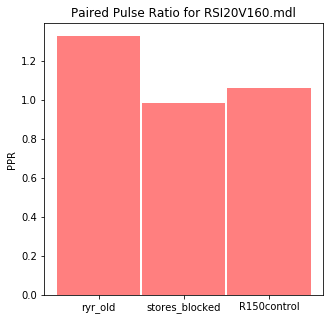

In [33]:
plt.figure(figsize=(5,5))
npoints=3

ydata=[result[sim_type][fname][4] for sim_type in sims[0:npoints]]
print(sims[0:npoints],'\n',ydata)

#plt.plot(range(npoints),ydata,'o-',markersize=15)
plt.bar(range(npoints),ydata,0.98,color='red',alpha=0.5)

#plt.ylim(3,5)
#plt.xlabel("Number of VDCCs")
plt.ylabel("PPR")
plt.title("Paired Pulse Ratio for "+fname)
plt.xticks(range(3),sims[0:npoints])

a=1
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/PPRRSI20V80.eps")

In [9]:
fnames
VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]
print(VDCC_range)

[40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160]


In [ ]:
result[sim_type]['RSIV40'][0]

Text(0, 0.5, 'P1')

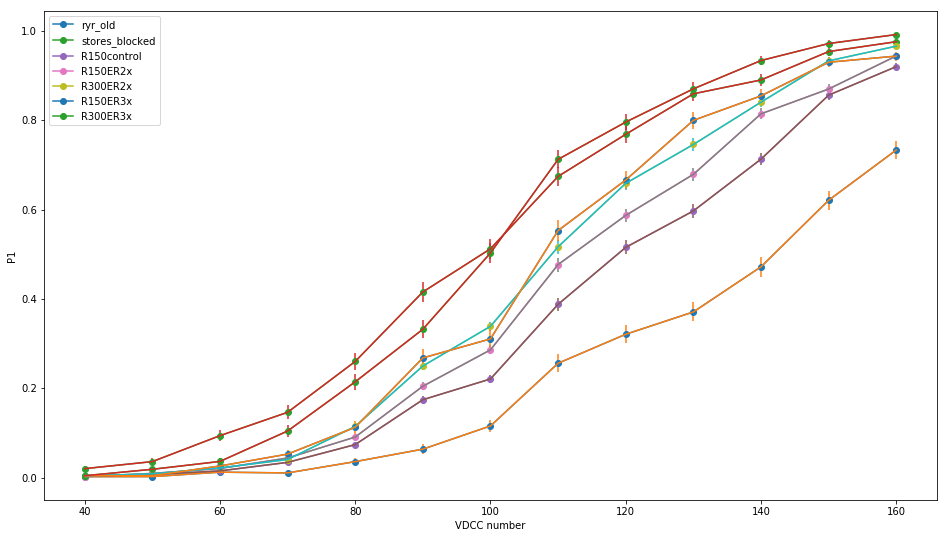

In [10]:
plt.figure(figsize=(16,9))
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]

for sim_type in sims:
    ydata=[result[sim_type][fname][0] for fname in fnames]
    yerr=[result[sim_type][fname][1] for fname in fnames]
    plt.plot(VDCC_range,ydata,label=sim_type,marker='o',linestyle='-')
    plt.errorbar(VDCC_range,ydata,yerr=yerr)
plt.legend()
plt.xlabel("VDCC number")
plt.ylabel("P1")
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP1.pdf")

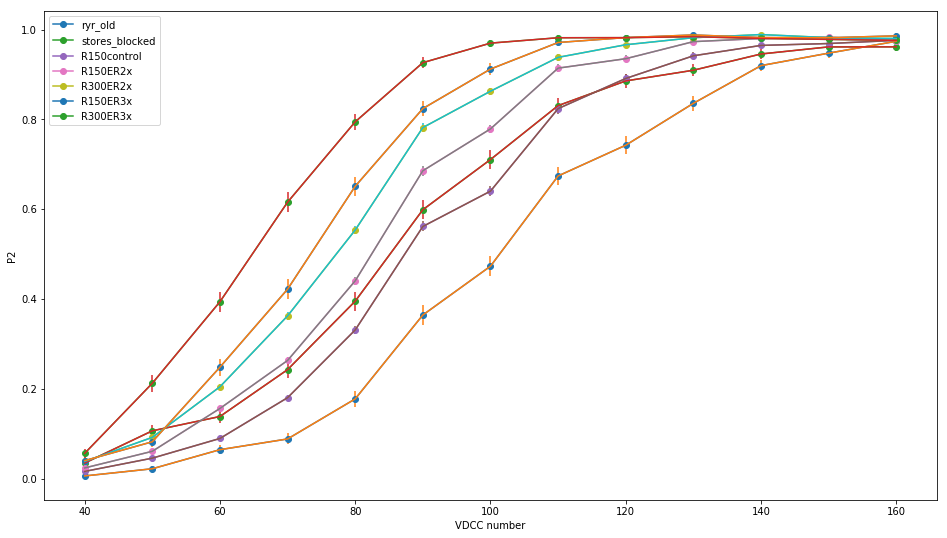

In [12]:
plt.figure(figsize=(16,9))
#VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]
for sim_type in sims:
    ydata=[result[sim_type][fname][2] for fname in fnames]
    yerr=[result[sim_type][fname][3] for fname in fnames]
    plt.plot(VDCC_range,ydata,label=sim_type,marker='o',linestyle='-')
    plt.errorbar(VDCC_range,ydata,yerr=yerr)
plt.legend()
plt.xlabel("VDCC number")
plt.ylabel("P2")
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangeP2.pdf")

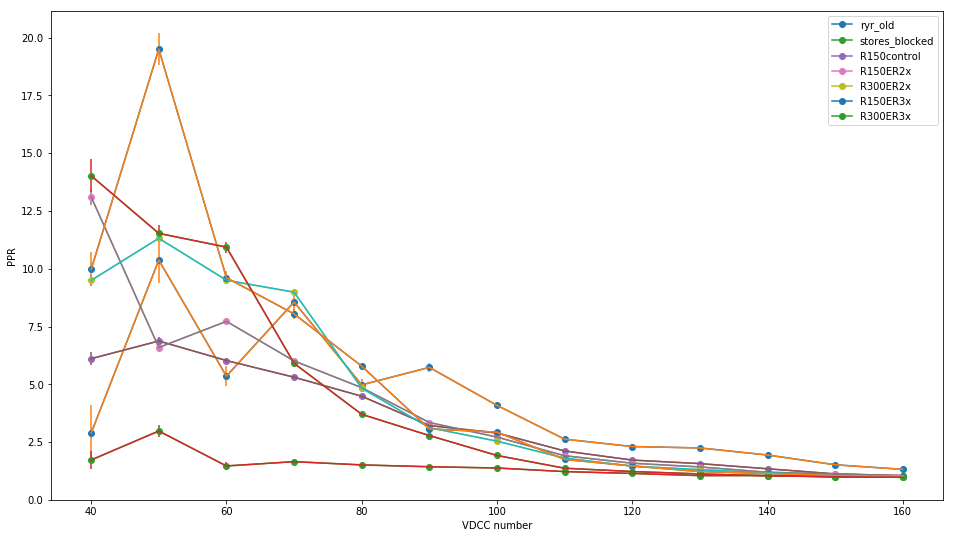

In [15]:
plt.figure(figsize=(16,9))
VDCC_range=[int(a.split('V')[1].split('.')[0]) for a in fnames]
sims=["ryr_old","stores_blocked","R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"] #
for sim_type in sims:
    ydata=[result[sim_type][fname][2]/result[sim_type][fname][0] for fname in fnames]
    yerr=[np.sqrt((result[sim_type][fname][1]/result[sim_type][fname][0])**2+(result[sim_type][fname][3]/result[sim_type][fname][2])**2) for fname in fnames]
    plt.plot(VDCC_range,ydata,label=sim_type,marker='o',linestyle='-')
    plt.errorbar(VDCC_range,ydata,yerr=yerr)
plt.legend()
plt.xlabel("VDCC number")
plt.ylabel("PPR")
#plt.xlim((50,160))
#plt.ylim((0,6))
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangePPR.pdf")

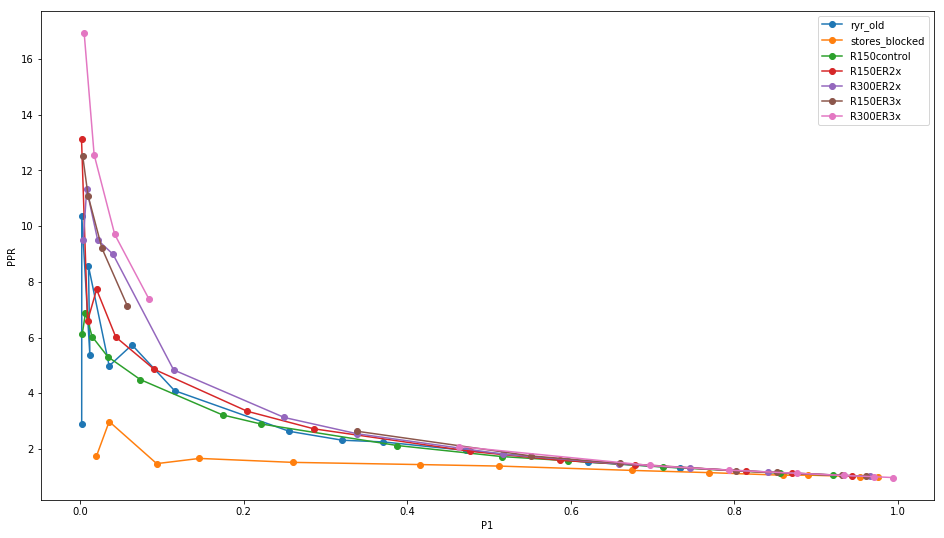

In [54]:
plt.figure(figsize=(16,9))
#print(list(range(40,170,10)))
for sim_type in sims:
    plt.plot([result[sim_type][fname][0] for fname in fnames],[result[sim_type][fname][2]/result[sim_type][fname][0] for fname in fnames],label=sim_type,marker='o',linestyle='-')
plt.legend()
#plt.ylim((0,3))
#plt.xlim((0,0.4))
plt.xlabel("P1")
plt.ylabel("PPR")
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/VDCCrangePPR_P1.pdf")

['R150control', 'R150ER2x', 'R300ER2x'] 
 [0.05589999999999995, 0.03170000000000006, 0.01419999999999999]


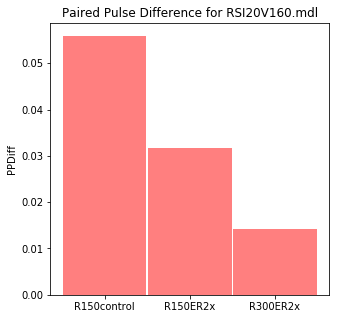

In [89]:
plt.figure(figsize=(5,5))
npoints=3
#fname=fnames[0].replace('.mdl','')
ydata=[result[sim_type][fname][2]-result[sim_type][fname][0] for sim_type in sims[0:npoints]]
print(sims[0:npoints],'\n',ydata)

#plt.plot(range(npoints),ydata,'o-',markersize=15)
plt.bar(range(npoints),ydata,0.98,color='red',alpha=0.5)

#plt.ylim(3,5)
#plt.xlabel("Number of VDCCs")
plt.ylabel("PPDiff")
plt.title("Paired Pulse Difference for "+fname)
plt.xticks(range(3),sims[0:npoints])

a=1
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/PPRRSI20V80.eps")

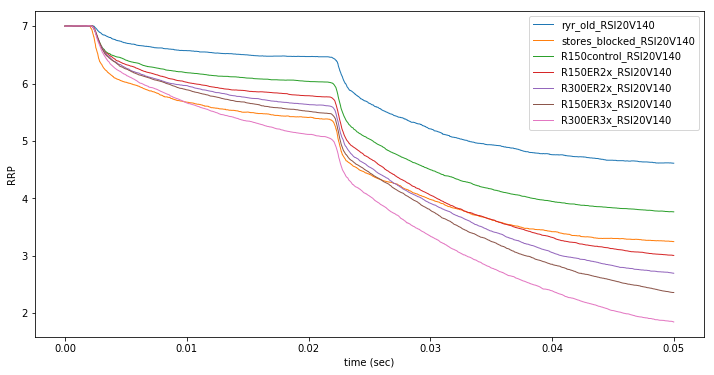

In [15]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
fnames=["RSI20V140"]
for (name,sim_type) in product(fnames,sims):
    #name="RSI20V90"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'rrp.dat'
    data[sim_type+name]=np.loadtxt(loc)
    


plt.figure(figsize=(12,6))
for (name,sim_type) in product(fnames,sims):
    xdata=data[sim_type+name].T[0]
    ydata=data[sim_type+name].T[1]
    plt.plot(xdata,ydata,label=sim_type+'_'+name,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("RRP")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ca_cytRSI20V90.eps")

In [4]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims:
    data[sim_type]={}
    name="RSI20V100"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'CaConc'
    data[sim_type][name]=np.loadtxt(loc)
    

plt.figure(figsize=(12,8))
for sim_type in sims:
    xdata=data[sim_type][name].T[0]
    ydata=data[sim_type][name].T[1]
    plt.plot(xdata,ydata,label=sim_type)

plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration at Active Zone")
plt.legend()
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/azRSI20V80.eps")
#plt.xlim((0,0.005))
#plt.ylim((8,9))

NameError: name 'sims' is not defined

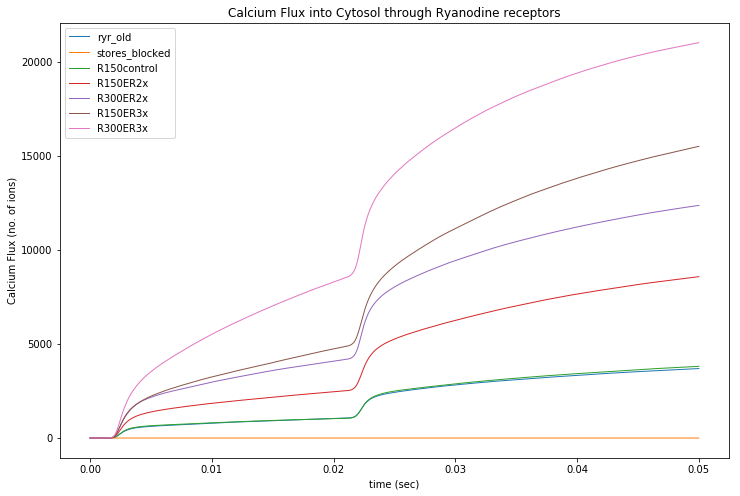

In [25]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
for sim_type in sims:
    data[sim_type]={}
    name="RSI20V130"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ryr_ca_flux.dat'
    loc2=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ryrCaFlux.dat'
    if os.path.isfile(loc1):
        data[sim_type][name]=np.loadtxt(loc1)
    else:
        data[sim_type][name]=np.loadtxt(loc2)
    

plt.figure(figsize=(12,8))
for sim_type in sims:
    xdata=data[sim_type][name].T[0]
    ydata=data[sim_type][name].T[1]
    plt.plot(xdata,ydata,label=sim_type,lw="1")

plt.xlabel("time (sec)")
plt.ylabel("Calcium Flux (no. of ions)")
plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

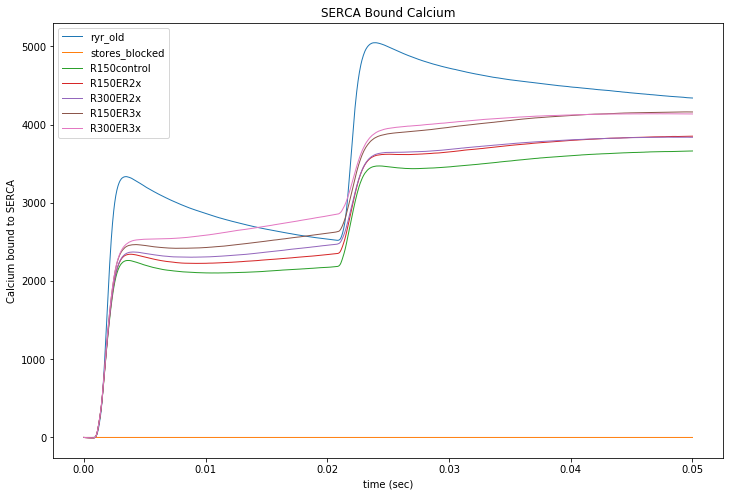

In [26]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
for sim_type in sims:
    name="RSI20V160"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'serca_mol.dat'
    loc2=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'sercaMol.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[4]*2+data_bound[sim_type].T[5]+data_bound[sim_type].T[2]+data_bound[sim_type].T[3]*2
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(12,8))
for sim_type in sims:
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Calcium bound to SERCA")
plt.title("SERCA Bound Calcium")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/serca_boundRSI20V80.eps")

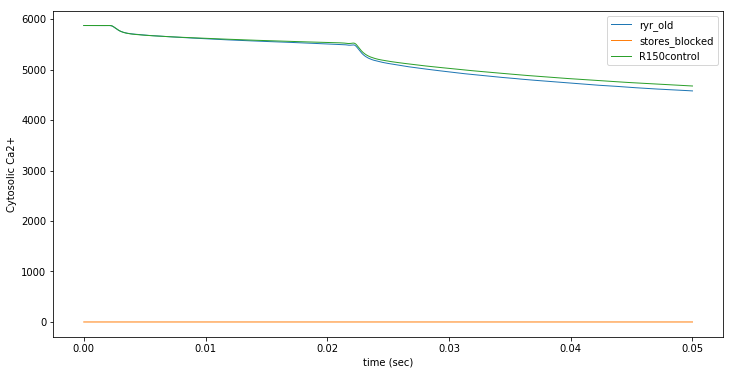

In [6]:
### res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
for sim_type in sims[0:3]:
    name="RSI20V80"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'ca.dat'
    data[sim_type]=np.loadtxt(loc)
 

plt.figure(figsize=(12,6))
for sim_type in sims[0:3]:
    xdata=data[sim_type].T[0]
    ydata=data[sim_type].T[3]#/602.3
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Cytosolic Ca2+")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.xlim((0,0.01))
#plt.ylim((0,2))
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ca_cytRSI20V90.eps")

In [10]:
sims

['ryr_old',
 'stores_blocked',
 'R150control',
 'R150ER2x',
 'R300ER2x',
 'R150ER3x',
 'R300ER3x']

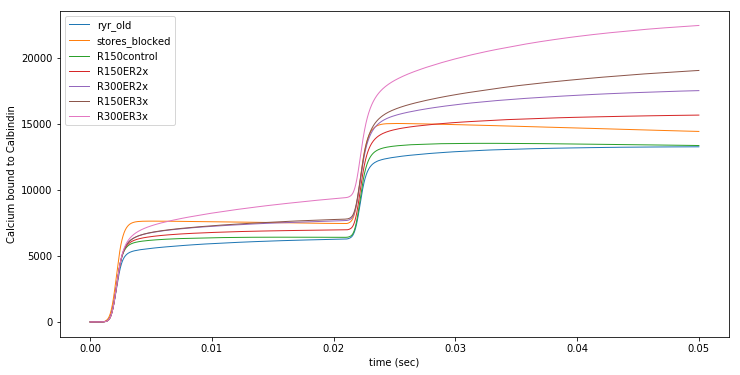

In [29]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data_bound={}
bnd_cal={}
for sim_type in sims:
    name="RSI20V100"
    loc1=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'calbindin_mol.dat'
    loc2=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'calB.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[2]+data_bound[sim_type].T[4]+2*(data_bound[sim_type].T[3]+data_bound[sim_type].T[5]+data_bound[sim_type].T[7])+3*(data_bound[sim_type].T[6]+data_bound[sim_type].T[8])+4*data_bound[sim_type].T[9]
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(12,6))
for sim_type in sims:
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Calcium bound to Calbindin")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/calb_boundRSI20V80.eps")

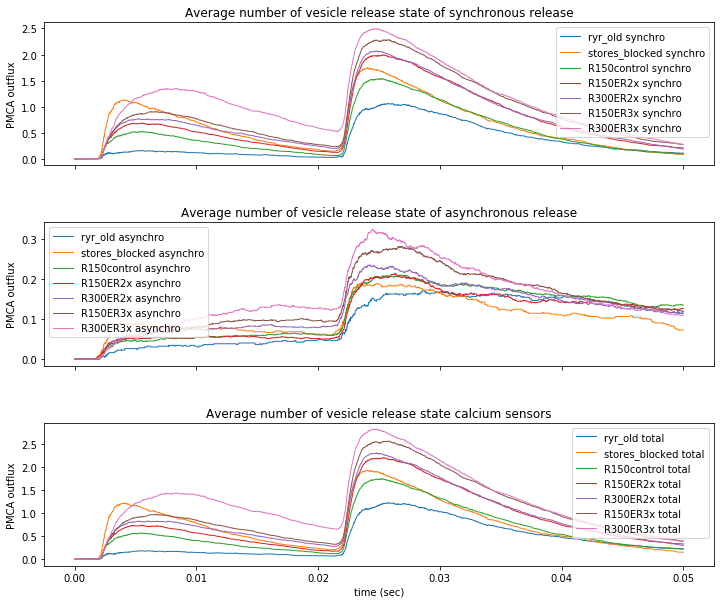

In [30]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}
synchro={}
asynchro={}
for sim_type in sims:
    name="RSI20V160"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
    data[sim_type]=np.loadtxt(loc)
    synchro[sim_type]=data[sim_type].T[6]+data[sim_type].T[12]+data[sim_type].T[18]
    asynchro[sim_type]=np.sum(data[sim_type].T[13:19],axis=0)

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,10))
f.subplots_adjust(hspace=0.4)
for sim_type in sims:
    xdata=data[sim_type].T[0]
    ax[0].plot(xdata,synchro[sim_type],label=sim_type+" synchro",lw="1")
    ax[1].plot(xdata,asynchro[sim_type],label=sim_type+" asynchro",lw="1")
    ax[2].plot(xdata,asynchro[sim_type]+synchro[sim_type],label=sim_type+" total",lw="1")
titles=["Average number of vesicle release state of synchronous release",
        "Average number of vesicle release state of asynchronous release",
        "Average number of vesicle release state calcium sensors"]
for xis,title in zip(ax,titles):
    #xis.set_ylabel()
    xis.legend()
    xis.set_title(title)
    
ax[-1].set_xlabel("time (sec)")

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/releaseRSI20V80.eps")

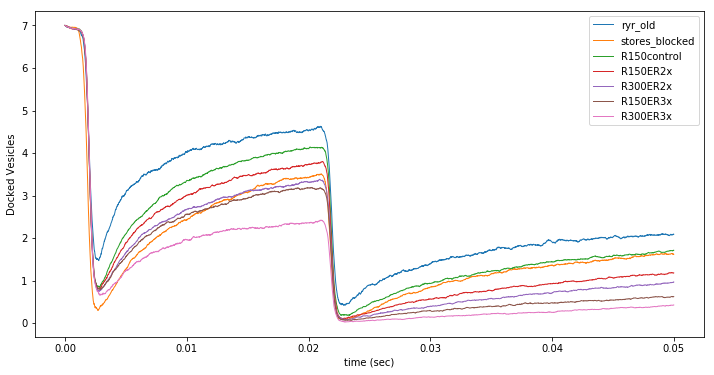

In [31]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/ppf/"
data={}

 

plt.figure(figsize=(12,6))
for sim_type in sims:
    name="RSI20V150"
    loc=res_loc+sim_type+'/'+name.replace(".mdl","")+'/'+'az.dat'
    data[sim_type]=np.loadtxt(loc)
    xdata=data[sim_type].T[0]
    ydata=data[sim_type].T[1]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Docked Vesicles")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ca_cytRSI20V90.eps")

In [391]:
def faverage(data_file):
    dataDirName="RSI20V90"
    dataType="ppf/R150ER2x/"
    M=analysis(dataDirName,dataType)
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    
data_files=['az.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']

p=Pool(ncores-1)
p.starmap(faverage,product(data_files[5:6]))


Calculating Average of /dat/serca_mol.dat
RSI20V90
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER2x/RSI20V90/serca_mol.dat


[None]

In [255]:
name="RSI60V90"
outfolder="R150ER2x"
data_loc="/data/kabir/output/ppf/"+outfolder+'/'+name
seed_folders=os.listdir(data_loc)
for s in seed_folders:
    file=data_loc+'/'+s+'/'+'dat/ca.dat'
    print(s,file_len(file))
    

s_01547 9002
s_00027 9002
s_00119 9002
s_00499 9002
s_01843 9002
s_00387 9002
s_00089 9002
s_00342 9002
s_01922 9002
s_01393 9002
s_00784 9002
s_01093 9002
s_01405 9002
s_01973 9002
s_00830 9002
s_00056 9002
s_00606 9002
s_01255 9002
s_00066 9002
s_01114 9002
s_00340 9002
s_01363 9002
s_00270 9002
s_01443 9002
s_00087 9002
s_01070 9002
s_00508 9002
s_00095 9002
s_00249 9002
s_00217 9002
s_01373 9002
s_01277 9002
s_01178 9002
s_00012 9002
s_00695 9002
s_01647 9002
s_00223 9002
s_00931 9002
s_01012 9002
s_00793 9002
s_00505 9002
s_00669 9002
s_00461 9002
s_01418 9002
s_00116 9002
s_01251 9002
s_00068 9002
s_00584 9002
s_00051 9002
s_00082 9002
s_00380 9002
s_00825 9002
s_01716 9002
s_01407 9002
s_00305 9002
s_00715 9002
s_01154 9002
s_00679 9002
s_00837 9002
s_00246 9002
s_00859 9002
s_00378 9002
s_01458 9002
s_00968 9002
s_00419 9002
s_00561 9002
s_01553 9002
s_01250 9002
s_00997 9002
s_00638 9002
s_01768 9002
s_01753 9002
s_00757 9002
s_01958 9002
s_01482 9002
s_00120 9002
s_00438 9002

Process ForkPoolWorker-267:
Process ForkPoolWorker-269:
Process ForkPoolWorker-271:
Process ForkPoolWorker-273:
Process ForkPoolWorker-264:
Process ForkPoolWorker-268:
Process ForkPoolWorker-272:
Process ForkPoolWorker-270:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Fo

s_01651 9002
s_00189 9002
s_00832 9002
s_00058 9002
s_00779 9002
s_01386 9002
s_01124 9002
s_00398 9002
s_01077 9002
s_01604 9002
s_01536 9002
s_01613 9002


  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


In [237]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [246]:
"hi.bye".split('.')[0]

'hi'

In [281]:
#combine glutamate release data for each seed
data_loc="/data/kabir/output/ppf/"+outfolder+'/'
#get seed folders
seed_folders=os.listdir(data_loc)

count=0
if "Average" in seed_folders:
    seed_folders.remove("Average")
for s in seed_folders:
    s=data_loc+s+"/dat/"
    file_names=os.listdir(s)
    output=[]
    for f_name in file_names:
        if 'vdcc.' in f_name:
            with open(s+f_name,'r') as f:
                output=output+f.readlines()
    with open(s+'rel.dat','w') as f:
        f.writelines(output)
    count+=len(output)

count/500

0.67

In [4]:
%run testLocal.py norm/RSI20V90
norm_ppf=ppf(resample=10)
%run testLocal.py AD/RSI20V90
AD_ppf=ppf(resample=10)
print("normal PPR = ",norm_ppf[4])
print("AD PPR     = ",AD_ppf[4])

dataPath :  /data/kabir/output/ppf/norm/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/norm/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.0382, 0.008072174428244226, 0.34719999999999995, 0.02584879107424562, 9.611293613731359, 2.5516180832777358, 20.0, 90.0]
dataPath :  /data/kabir/output/ppf/AD/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.09159999999999999, 0.016044936896105262, 0.49840000000000007, 0.020293841430345325, 5.623162580693527, 1.070975085559397, 20.0, 90.0]
normal PPR =  9.611293613731359
AD PPR     =  5.623162580693527


In [9]:
%run testLocal.py AD/RSI40V90

dataPath :  /data/kabir/output/ppf/AD/RSI40V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI40V90


In [10]:
AD_ppf=ppf(resample=10)

isi:  40 vdcc:  90
seeds:  500
[0.0922, 0.014462364951832738, 0.403, 0.01782694589659148, 4.509857438817555, 0.8958789564708997, 40.0, 90.0]


In [261]:
%run averaging1.ipynb

averager("/data/kabir/output/ppf/norm/RSI40V90","ca.dat",[2,3])

In [208]:
outfolder='norm/RSI20V40'
data_file="/data/kabir/output/ppf/norm/RSI20V40/Average/ca.dat"
data1=np.loadtxt(data_file)

outfolder='AD/RSI40V90/'
data_file="/data/kabir/output/ppf/AD/RSI40V90/Average/ca.dat"
data2=np.loadtxt(data_file)

In [3]:
#plt.plot(data1.T[0,:],data1.T[1,:],label='normal')#*1e15/N_avo/vol_er*1e6)
plt.plot(data2.T[0,:],data2.T[1,:],label='AD')#*1e15/N_avo/vol_er*1e6)
plt.legend()

NameError: name 'plt' is not defined

In [11]:
data1.T[:,0]

array([   0.,    0.,   57., 5872.])

In [73]:
a=np.array([[1,2,3],[1,2,3],[1,2,3]])
def kmax(a,k):
    klargest=[(0,0),(0,0)]
    for i,row in enumerate(a):
        print(row)
        for j,ele in enumerate(row):
            print(ele)
            for k_ord,k in enumerate(klargest):
                print('k:',k)
                if ele>=a[k[0],k[1]]:
                    
                    klargest.append((i,j))
                    
    return klargest
kmax(a,2)

[1 2 3]
1
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)


k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: (0, 0)
k: 

KeyboardInterrupt: 

In [60]:
a=np.array([[1,2,3],[1,2,3],[1,2,3]])
a.shape

(3, 3)

In [76]:
np.amax(a,3)

AxisError: axis 3 is out of bounds for array of dimension 2

In [130]:
def my_kmax(R,k):
    N=len(R)
    f=R.flatten()
    indices=np.array(heapq.nlargest(k, range(len(f)), f.__getitem__))
    j=np.mod(indices,N)
    i=np.floor(indices/N)
    return i,j

In [134]:
R=np.random.randint(25,size=(5,5))
R[1:4,2:4]=0

In [135]:
my_kmax(R,3)

(array([0., 4., 4.]), array([3, 3, 0]))

In [100]:
np.wherenp.max(R)

24

In [112]:
R.flatten()

array([24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,
        7,  6,  5,  4,  3,  2,  1,  0])

In [103]:
import heapq

In [113]:
f=R.flatten()
heapq.nlargest(3, range(len(f)), f.__getitem__)

[0, 1, 2]

In [109]:
print([1,2].reverse())

None


In [115]:
np.mod(6,3)

2